In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import ExcelWriter
import openpyxl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate


import openpyxl
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'
import copy

from sigma import SigmaToolbox

In [2]:
121*(1/917.1)

0.1319376294842438

In [6]:
coreNames = np.array(['Crete', 'Site A', 'Site B', 'Site D', 'Site E', 'Site G', 'B19', 'B22', 'B23'])
LakiDepth = np.array([74.75, 80.85, 83.70, 93.80, 62.95, 69.40, 37.12, 52.04, 45.38]) # Ice depth
TambDepth = np.array([64.70, 70.90, 73.00, 81.50, 53.40, 60.50, 32.58, 45.44, 39.48]) # Ice depth
Accum0 = np.array([0.28, 0.307, 0.327, 0.365, 0.225, 0.251, 0.103, 0.158, 0.139])#, 94, 145, 121, 0.53, 0.38]) # In meters of ice per year
T0 = np.array([-30.4, -29.41, -29.77, -28.3, -30.37, -30.10, -30.9, -29.8, -29.3]) + 273.15# in Kelvin
zs = np.array([80, 85, 85, 95, 65, 75, 40, 55, 50])

In [4]:

sigma_inst = SigmaToolbox()

0.0 330.0 0.0
0.01 330.1387681161483 0.0
0.02 330.2775617529136 0.0
0.03 330.4163808873872 0.0
0.04 330.5552254966406 0.0
0.05 330.69409555772637 0.0
0.06 330.8329910476769 0.0
0.07 330.971911943506 0.0
0.08 331.1108582222074 0.0
0.09 331.24982986075634 0.0
0.1 331.3888268361076 0.0
0.11 331.5278491251978 0.0
0.12 331.6668967049431 0.0
0.13 331.80596955224127 0.0
0.14 331.9450676439703 0.0
0.15 332.084190956989 0.0
0.16 332.2233394681369 0.0
0.17 332.36251315423414 0.0
0.18 332.50171199208194 0.0
0.19 332.6409359584621 0.0
0.2 332.7801850301369 0.0
0.21 332.9194591838499 0.0
0.22 333.0587583963252 0.0
0.23 333.19808264426763 0.0
0.24 333.33743190436303 0.0
0.25 333.47680615327806 0.0
0.26 333.6162053676602 0.0
0.27 333.7556295241376 0.0
0.28 333.89507859931945 0.0
0.29 334.03455256979584 0.0
0.3 334.17405141213777 0.0
0.31 334.31357510289723 0.0
0.32 334.4531236186067 0.0
0.33 334.59269693578017 0.0
0.34 334.7322950309122 0.0
0.35000000000000003 334.8719178804784 0.0
0.36 335.011565460

2.08 359.3778792230891 0.030016933655874715
2.09 359.5214347266427 0.030004948011599062
2.1 359.665010587463 0.029992970237523692
2.11 359.8086067789005 0.02998100032848076
2.12 359.95222327429 0.029969038279305787
2.13 360.0958600469495 0.02995708408483772
2.14 360.23951707018074 0.02994513773991888
2.15 360.3831943172696 0.02993319923939496
2.16 360.52689176148533 0.02992126857811506
2.17 360.6706093760809 0.029909345750931668
2.18 360.81434713429354 0.029897430752700613
2.19 360.9581050093438 0.029885523578281132
2.2 361.10188297443625 0.02987362422253584
2.21 361.2456810027593 0.029861732680330714
2.22 361.38949906748513 0.029849848946535106
2.23 361.53333714176995 0.036523796124443966
2.24 361.67719519875374 0.03650926868833828
2.25 361.82107321156036 0.03649475079146379
2.2600000000000002 361.96497115329794 0.03648024242755669
2.27 362.10888899705805 0.0364657435903573
2.2800000000000002 362.2528267159164 0.03645125427361006
2.29 362.39678428293314 0.03643677447106347
2.300000000

5.7 412.4556734028639 0.05193178087795855
5.71 412.60474283867296 0.05191301851177057
5.72 412.75382207611335 0.05189426846561948
5.73 412.9029110839883 0.05187553073141552
5.74 413.0520098310925 0.051856805301074234
5.75 413.2011182862129 0.051838092166516435
5.76 413.35023641812774 0.051819391319668284
5.7700000000000005 413.49936419560703 0.051800702752461264
5.78 413.6485015874128 0.051782026456832095
5.79 413.79764856229883 0.051763362424722834
5.8 413.9468050890106 0.051744710648080824
5.8100000000000005 414.09597113628575 0.051726071118858664
5.82 414.24514667285354 0.0517074438290143
5.83 414.3943316674353 0.05168882877051089
5.84 414.54352608874444 0.05167022593531691
5.8500000000000005 414.692729905486 0.051651635315406105
5.86 414.8419430863572 0.05163305690275748
5.87 414.99116560004757 0.051614490689355315
5.88 415.1403974152382 0.051595936667189146
5.89 415.28963850060256 0.051577394828253784
5.9 415.4388888248062 0.05155886516454928
5.91 415.5881483565068 0.0515403476680

9.3 466.50906350228274 0.05981057780164682
9.31 466.6595998333182 0.05979128394174854
9.32 466.81013440466717 0.059772002750884824
9.33 466.9606671838866 0.05975273422073675
9.34 467.11119813853526 0.059733478342990795
9.35 467.26172723617316 0.059714235109339014
9.36 467.4122544443624 0.05969500451147878
9.370000000000001 467.5627797306662 0.059675786541113024
9.38 467.71330306264974 0.059656581189950056
9.39 467.8638244078797 0.0596373884497037
9.4 468.0143437339247 0.059618208312093135
9.41 468.16486100835493 0.059599040768843044
9.42 468.31537619874246 0.05957988581168351
9.43 468.465889272661 0.05956074343235008
9.44 468.61640019768623 0.05954161362258368
9.450000000000001 468.7669089413958 0.059522496374130686
9.46 468.9174154713687 0.05950339167874293
9.47 469.0679197551866 0.05948429952817757
9.48 469.2184217604324 0.05946521991419728
9.49 469.3689214546914 0.059446152828570055
9.5 469.5194188055508 0.059427098263069356
9.51 469.66991378059987 0.059408056209473994
9.52 469.8204

12.870000000000001 519.8970815881968 0.06407060359116365
12.88 520.0449580442306 0.06405238490901233
12.89 520.1928214625927 0.06403417818989562
12.9 520.3406718131137 0.06401598342595817
12.91 520.4885090656344 0.0639978006093498
12.92 520.6363331900071 0.06397962973222546
12.93 520.7841441560952 0.06396147078674527
12.94 520.9319419337731 0.06394332376507446
12.950000000000001 521.0797264929258 0.06392518865938347
12.96 521.2274978034501 0.06390706546184781
12.97 521.3752558352534 0.06388895416464818
12.98 521.5230005582542 0.06387085475997041
12.99 521.6707319423825 0.06385276724000544
13.0 521.8184499575797 0.06383469159694931
13.01 521.9661545737974 0.06381662782300325
13.02 522.1138457609998 0.06379857591037358
13.030000000000001 522.261523489161 0.06378053585127172
13.040000000000001 522.4091877282672 0.06376250763791426
13.05 522.556838448316 0.06374449126252282
13.06 522.7044756193155 0.0637264867173242
13.07 522.8520992112863 0.06370849399455024
13.08 522.9997091942594 0.0636

16.46 558.6833025706023 0.06675959032140036
16.47 558.7397095977556 0.06675285067150738
16.48 558.7961134384853 0.06674611276287311
16.490000000000002 558.852514091179 0.06673937659504765
16.5 558.9089115542241 0.06673264216758128
16.51 558.9653058260088 0.06672590948002433
16.52 559.0216969049211 0.06671917853192728
16.53 559.0780847893499 0.06671244932284078
16.54 559.1344694776845 0.06760023139837579
16.55 559.1908509683143 0.06759341547532097
16.56 559.2472292596294 0.06758660131323081
16.57 559.3036043500201 0.06757978891165034
16.580000000000002 559.359976237877 0.06757297827012475
16.59 559.4163449215914 0.06756616938819929
16.6 559.472710399555 0.06755936226541931
16.61 559.5290726701593 0.06755255690133039
16.62 559.5854317317971 0.06754575329547807
16.63 559.6417875828607 0.0675389514474082
16.64 559.6981402217435 0.06753215135666654
16.65 559.754489646839 0.06752535302279912
16.66 559.8108358565412 0.067518556445352
16.67 559.8671788492442 0.06751176162387143
16.68 559.92351

18.28 568.8953217849544 0.06895499371602287
18.29 568.9511227160648 0.06894823082778793
18.3 569.0069201738871 0.06894146968681558
18.31 569.0627141568831 0.0689347102926544
18.32 569.1185046635153 0.068927952644853
18.330000000000002 569.1742916922459 0.06892119674296027
18.34 569.2300752415377 0.06891444258652514
18.35 569.2858553098548 0.06890769017509657
18.36 569.3416318956604 0.06969957590895216
18.37 569.3974049974191 0.06969274875887105
18.38 569.4531746135955 0.06968592337265524
18.39 569.5089407426547 0.069679099749849
18.400000000000002 569.5647033830624 0.06967227788999672
18.41 569.6204625332842 0.06966545779264297
18.42 569.676218191787 0.06965863945733233
18.43 569.7319703570373 0.0696518228836096
18.44 569.7877190275024 0.06964500807101964
18.45 569.84346420165 0.06963819501910745
18.46 569.8992058779481 0.06963138372741814
18.47 569.9549440548655 0.06962457419549693
18.48 570.0106787308707 0.06961776642288917
18.490000000000002 570.0664099044335 0.06961096040914032
18.

21.900000000000002 588.8565544182685 0.07298211804193061
21.91 588.911000925926 0.07297537063622316
21.92 588.9654434321924 0.07296862497377818
21.93 589.019881935691 0.07296188105414532
21.94 589.0743164350465 0.0729551388768743
21.95 589.1287469288835 0.07294839844151492
21.96 589.1831734158271 0.07294165974761721
21.97 589.2375958945032 0.0729349227947312
21.98 589.2920143635376 0.0729281875824071
21.990000000000002 589.3464288215574 0.07292145411019518
22.0 589.4008392671893 0.0729147223776459
22.01 589.4552456990609 0.07290799238430982
22.02 589.5096481158005 0.07290126412973755
22.03 589.5640465160363 0.07289453761347987
22.04 589.6184408983974 0.0728878128350877
22.05 589.6728312615131 0.07288108979411204
22.06 589.7272176040137 0.07287436849010394
22.07 589.7815999245291 0.07286764892261473
22.080000000000002 589.8359782216907 0.0728609310911957
22.09 589.8903524941292 0.07285421499539836
22.1 589.9447227404767 0.07284750063477428
22.11 589.9990889593655 0.07284078800887514
22.

25.5 608.1884430652931 0.07522613418687957
25.51 608.2413638314943 0.07521958904724217
25.52 608.2942801319668 0.07521304559860972
25.53 608.3471919655101 0.07520650384054534
25.54 608.4000993309231 0.07519996377261223
25.55 608.4530022270061 0.07519342539437374
25.560000000000002 608.505900652559 0.07518688870539336
25.57 608.5587946063833 0.07518035370523458
25.580000000000002 608.6116840872802 0.07517382039346113
25.59 608.6645690940514 0.07516728876963678
25.6 608.7174496254997 0.07516075883332543
25.61 608.7703256804278 0.07515423058409108
25.62 608.8231972576393 0.07514770402149788
25.63 608.8760643559381 0.07514117914511007
25.64 608.9289269741284 0.07513465595449197
25.650000000000002 608.9817851110155 0.07512813444920806
25.66 609.0346387654046 0.07512161462882293
25.67 609.0874879361015 0.07511509649290127
25.68 609.140332621913 0.07510858004100786
25.69 609.1931728216458 0.07510206527270763
25.7 609.2460085341075 0.07509555218756558
25.71 609.2988397581059 0.0750890407851469

27.3 617.6411113182521 0.07606050939721343
27.310000000000002 617.6932093855025 0.07605409422949996
27.32 617.7453027789606 0.07604768071921186
27.330000000000002 617.7973914975166 0.0760412688659209
27.34 617.8494755400613 0.07603485866919894
27.35 617.9015549054853 0.07602845012861807
27.36 617.9536295926806 0.07602204324375035
27.37 618.0056996005393 0.07601563801416802
27.38 618.0577649279538 0.07600923443944343
27.39 618.1098255738176 0.076002832519149
27.400000000000002 618.1618815370239 0.07599643225285733
27.41 618.2139328164671 0.07599003364014108
27.42 618.265979411042 0.07598363668057302
27.43 618.3180213196438 0.0764488675131186
27.44 618.3700585411679 0.07644243417017274
27.45 618.4220910745106 0.07643600248934801
27.46 618.4741189185689 0.07642957247021494
27.47 618.5261420722397 0.07642314411234424
27.48 618.5781605344212 0.07641671741530671
27.490000000000002 618.6301743040112 0.07641029237867325
27.5 618.6821833799087 0.07640386900201489
27.51 618.7341877610129 0.07639

29.09 626.8911851328859 0.07717367219922985
29.1 626.9424293915274 0.07716736427136742
29.11 626.9936687858859 0.07716105797322383
29.12 627.0449033149438 0.077154753304378
29.13 627.0961329776837 0.077148450264409
29.14 627.1473577730891 0.07714214885289597
29.150000000000002 627.1985777001438 0.07713584906941819
29.16 627.2497927578318 0.07712955091355507
29.17 627.3010029451383 0.07712325438488603
29.18 627.3522082610484 0.07711695948299074
29.19 627.4034087045483 0.07711066620744887
29.2 627.4546042746241 0.07710437455784024
29.21 627.5057949702629 0.07709808453374478
29.22 627.5569807904519 0.07709179613474251
29.23 627.6081617341794 0.07708550936041358
29.240000000000002 627.6593378004336 0.07707922421033823
29.25 627.7105089882036 0.07707294068409683
29.26 627.7616752964789 0.07706665878126984
29.27 627.8128367242496 0.0770603785014378
29.28 627.8639932705061 0.07705409984418145
29.29 627.9151449342394 0.07704782280908157
29.3 627.9662917144412 0.07704154739571903
29.31000000000

32.67 644.9184194465147 0.07807619076602222
32.68 644.9678611975287 0.07807020562503116
32.69 645.0172977531578 0.07806422203036353
32.7 645.0667291125704 0.07805823998161988
32.71 645.1161552749361 0.0780522594784008
32.72 645.1655762394245 0.07839578615028144
32.730000000000004 645.2149920052058 0.07838978196895482
32.74 645.264402571451 0.07838377933887096
32.75 645.3138079373315 0.07837777825962905
32.76 645.3632081020191 0.07837177873082841
32.77 645.4126030646863 0.07836578075206849
32.78 645.4619928245057 0.07835978432294884
32.79 645.5113773806511 0.07835378944306905
32.8 645.5607567322965 0.07834779611202884
32.81 645.6101308786159 0.07834180432942814
32.82 645.6594998187846 0.07833581409486683
32.83 645.7088635519784 0.07832982540794495
32.84 645.758222077373 0.07832383826826267
32.85 645.8075753941451 0.07831785267542025
32.86 645.8569235014717 0.07831186862901807
32.87 645.9062663985304 0.07830588612865653
32.88 645.9556040844996 0.07829990517393623
32.89 646.0049365585575 

34.5 653.8789295160295 0.07866532642499728
34.51 653.92740719231 0.07865949471923454
34.52 653.9758795297607 0.0786536645201537
34.53 654.0243465276457 0.07864783582736545
34.54 654.0728081852292 0.07864200864048067
34.550000000000004 654.1212645017764 0.07863618295911028
34.56 654.1697154765529 0.07863035878286527
34.57 654.2181611088243 0.07862453611135688
34.58 654.2666013978578 0.07861871494419624
34.59 654.3150363429203 0.07861289528099473
34.6 654.3634659432793 0.07860707712136378
34.61 654.4118901982027 0.07860126046491495
34.62 654.4603091069597 0.07859544531125982
34.63 654.508722668819 0.07858963166001019
34.64 654.5571308830506 0.07858381951077786
34.65 654.6055337489244 0.0785780088631748
34.660000000000004 654.6539312657112 0.07857219971681303
34.67 654.7023234326825 0.07856639207130467
34.68 654.7507102491098 0.07856058592626199
34.69 654.7990917142654 0.07886721741539938
34.7 654.8474678274222 0.07886139118926049
34.71 654.8958385878533 0.07885556646838776
34.72 654.9442

38.12 671.0735962077484 0.07918786815114576
38.13 671.1200971797028 0.07918238133462588
38.14 671.1665925800174 0.07917689593568213
38.15 671.2130824081414 0.07917141195394829
38.160000000000004 671.2595666635245 0.07916592938905823
38.17 671.3060453456172 0.07916044824064587
38.18 671.3525184538705 0.07940984062023715
38.19 671.3989859877358 0.07940434466397973
38.2 671.4454479466651 0.07939885012765982
38.21 671.4919043301107 0.07939335701091055
38.22 671.5383551375256 0.07938786531336518
38.230000000000004 671.5848003683631 0.07938237503465703
38.24 671.6312400220775 0.07937688617441951
38.25 671.6776740981227 0.0793713987322862
38.26 671.7241025959539 0.07936591270789069
38.27 671.7705255150267 0.07936042810086665
38.28 671.8169428547969 0.07935494491084792
38.29 671.8633546147211 0.0793494631374684
38.300000000000004 671.9097607942559 0.07934398278036213
38.31 671.956161392859 0.07933850383916315
38.32 672.0025564099886 0.07933302631350563
38.33 672.0489458451028 0.079327550203023

41.74 687.5389259777476 0.0795701480697312
41.75 687.5833779483459 0.07956500389377243
41.76 687.6278241804325 0.07955986104686502
41.77 687.6722646736348 0.07955471952866565
41.78 687.7166994275809 0.079549579338831
41.79 687.7611284418992 0.07954444047701793
41.800000000000004 687.8055517162194 0.07953930294288328
41.81 687.8499692501705 0.07953416673608404
41.82 687.8943810433827 0.0795290318562773
41.83 687.9387870954866 0.0795238983031202
41.84 687.9831874061132 0.07951876607627
41.85 688.0275819748939 0.07951363517538403
41.86 688.0719708014609 0.07950850560011967
41.87 688.1163538854462 0.07950337735013453
41.88 688.1607312264831 0.07949825042508613
41.89 688.205102824205 0.07949312482463215
41.9 688.2494686782458 0.07948800054843042
41.910000000000004 688.2938287882394 0.0794828775961388
41.92 688.3381831538209 0.07947775596741523
41.93 688.3825317746259 0.07947263566191771
41.94 688.4268746502898 0.07946751667930445
41.95 688.4712117804493 0.0796655065834738
41.96 688.51554316

45.36 703.2529927346 0.07960758212614004
45.37 703.2953467328052 0.07960278798182192
45.38 703.3376948883542 0.07959799507612088
45.39 703.3800372010422 0.07959320340871692
45.4 703.4223736706653 0.0795884129792901
45.410000000000004 703.4647042970197 0.0795836237875206
45.42 703.507029079902 0.07957883583308863
45.43 703.54934801911 0.0795740491156745
45.44 703.5916611144406 0.07956926363495868
45.45 703.6339683656925 0.07956447939062161
45.46 703.6762697726641 0.07955969638234384
45.47 703.7185653351545 0.07955491460980604
45.480000000000004 703.760855052963 0.07955013407268896
45.49 703.8031389258895 0.07954535477067343
45.5 703.8454169537346 0.0795405767034403
45.51 703.887689136299 0.07953579987067054
45.52 703.9299554733836 0.0795310242720453
45.53 703.9722159647906 0.07952624990724563
45.54 704.014470610322 0.07952147677595281
45.550000000000004 704.0567194097802 0.07951670487784815
45.56 704.0989623629682 0.07951193421261303
45.57 704.1411994696898 0.07950716477992893
45.58 704

48.97 718.1618453377919 0.0793910238672411
48.980000000000004 718.2020802455338 0.079386576246427
48.99 718.2423092649831 0.07938212977470202
49.0 718.2825323960896 0.07937768445176929
49.01 718.3227496388034 0.07937324027733202
49.02 718.3629609930753 0.07936879725109346
49.03 718.4031664588562 0.07936435537275699
49.04 718.4433660360975 0.07935991464202602
49.050000000000004 718.4835597247512 0.07935547505860405
49.06 718.5237475247696 0.07935103662219467
49.07 718.5639294361052 0.07934659933250154
49.08 718.6041054587113 0.07934216318922838
49.09 718.6442755925411 0.07933772819207902
49.1 718.6844398375488 0.07933329434075732
49.11 718.7245981936884 0.07932886163496726
49.120000000000005 718.7647506609148 0.07932443007441288
49.13 718.804897239183 0.07931999965879832
49.14 718.8450379284486 0.07931557038782772
49.15 718.8851727286674 0.07931114226120539
49.160000000000004 718.9253016397959 0.07930671527863567
49.17 718.9654246617907 0.07930228943982295
49.18 719.0055417946088 0.0792

52.550000000000004 732.1895511277063 0.07899389184618753
52.56 732.2276778340968 0.07898977867618286
52.57 732.265798659405 0.07898566656885848
52.58 732.3039136037198 0.07898155552393982
52.59 732.3420226671295 0.07897744554115241
52.6 732.3801258497233 0.07897333662022184
52.61 732.4182231515906 0.07896922876087373
52.620000000000005 732.456314572821 0.07896512196283388
52.63 732.4944001135048 0.07896101622582805
52.64 732.5324797737326 0.07895691154958208
52.65 732.5705535535951 0.07895280793382196
52.660000000000004 732.6086214531837 0.07894870537827368
52.67 732.6466834725899 0.07894460388266333
52.68 732.6847396119057 0.07894050344671705
52.69 732.7227898712233 0.0789364040701611
52.7 732.7608342506358 0.07893230575272173
52.71 732.7988727502354 0.07892820849412537
52.72 732.8369053701166 0.07892411229409838
52.730000000000004 732.8749321103728 0.07892001715236728
52.74 732.9129529710978 0.0789159230686587
52.75 732.9509679523862 0.07891183004269928
52.76 732.9889770543334 0.0789

56.13 745.464002981899 0.07845313272023574
56.14 745.5000325922215 0.0784493411230836
56.15 745.5360563754891 0.07844555050553005
56.160000000000004 745.5720743319129 0.07844176086732199
56.17 745.6080864617043 0.07843797220820642
56.18 745.6440927650751 0.07843418452793037
56.19 745.6800932422377 0.07843039782624092
56.2 745.7160878934043 0.07842661210288528
56.21 745.7520767187877 0.07842282735761068
56.22 745.7880597186012 0.07841904359016441
56.230000000000004 745.8240368930581 0.07841526080029385
56.24 745.860008242372 0.07841147898774642
56.25 745.8959737667572 0.07848246302961383
56.26 745.931933466428 0.07847867956670879
56.27 745.9678873415992 0.07847489708130073
56.28 746.0038353924856 0.07847111557313717
56.29 746.0397776193026 0.0784673350419656
56.300000000000004 746.0757140222661 0.0784635554875336
56.31 746.1116446015917 0.07845977690958884
56.32 746.1475693574961 0.07845599930787903
56.33 746.1834882901957 0.07845222268215192
56.34 746.2194013999073 0.0784484470321554
5

59.71 757.9920483843815 0.07786409262396762
59.72 758.0260077506069 0.07786060433305123
59.730000000000004 758.0599613849116 0.07785711694337108
59.74 758.0939092876133 0.07785363045469436
59.75 758.1278514590301 0.07785014486678826
59.76 758.1617878994804 0.0778466601794201
59.77 758.1957186092831 0.07784317639235717
59.78 758.2296435887569 0.07783969350536692
59.79 758.2635628382212 0.07783621151821675
59.800000000000004 758.2974763579957 0.07783273043067421
59.81 758.3313841483998 0.07782925024250688
59.82 758.3652862097542 0.07782577095348235
59.83 758.3991825423786 0.0778222925633684
59.84 758.4330731465939 0.07781881507193274
59.85 758.4669580227212 0.07781533847894316
59.86 758.5008371710813 0.07781186278416759
59.870000000000005 758.534710591996 0.07780838798737394
59.88 758.568578285787 0.0778049140883302
59.89 758.602440252776 0.07780144108680444
59.9 758.6362964932855 0.07779796898256476
59.910000000000004 758.670147007638 0.07779449777537936
59.92 758.7039917961563 0.077791

63.27 769.7219282743445 0.07713764590223066
63.28 769.7538691337477 0.0771344450833699
63.29 769.7858043908557 0.07713124509147401
63.300000000000004 769.8177340460762 0.07712804592632935
63.31 769.8496580998177 0.0771248475877223
63.32 769.8815765524886 0.07712165007543931
63.33 769.9134894044973 0.0771184533892669
63.34 769.9453966562529 0.07711525752899163
63.35 769.9772983081644 0.07711206249440014
63.36 770.0091943606413 0.07714691539214494
63.370000000000005 770.041084814093 0.07714372043259958
63.38 770.0729696689294 0.07714052629850526
63.39 770.1048489255604 0.07713733298964874
63.4 770.1367225843967 0.07713414050581678
63.410000000000004 770.1685906458482 0.07713094884679628
63.42 770.2004531103261 0.07712775801237408
63.43 770.2323099782411 0.07712456800233716
63.440000000000005 770.2641612500045 0.07712137881647255
63.45 770.2960069260276 0.0771181904545673
63.46 770.3278470067222 0.07711500291640853
63.47 770.3596814925 0.07711181620178344
63.480000000000004 770.3915103837

65.08 775.4123687621957 0.07677776070877436
65.09 775.4433024709692 0.07677469791761674
65.1 775.4742306549307 0.07677163591776308
65.11 775.5051533145278 0.07676857470900895
65.12 775.5360704502083 0.07676551429114999
65.13 775.5669820624208 0.0767624546639818
65.14 775.5978881516133 0.07675939582730015
65.15 775.6287887182345 0.07675633778090081
65.16 775.6596837627334 0.07675328052457958
65.17 775.6905732855588 0.07675022405813234
65.18 775.72145728716 0.07674716838135502
65.19 775.7523357679864 0.0767441134940436
65.2 775.7832087284876 0.07674105939599413
65.21000000000001 775.8140761691134 0.07673800608700267
65.22 775.844938090314 0.07673495356686535
65.23 775.8757944925395 0.0767319018353784
65.24 775.9066453762406 0.07672885089233804
65.25 775.9374907418677 0.07672580073754057
65.26 775.9683305898718 0.07672275137078233
65.27 775.999164920704 0.07671970279185976
65.28 776.0299937348157 0.07671665500056925
65.29 776.0608170326581 0.07671360799670736
65.3 776.0916348146832 0.0767

68.75 786.3977955908995 0.0759658723852611
68.76 786.4267333837059 0.07596307710302803
68.77 786.4556658290855 0.07596028254298524
68.78 786.4845929275555 0.0759574887049461
68.79 786.5135146796318 0.07595469558872411
68.8 786.5424310858316 0.07595190319413277
68.81 786.5713421466717 0.07594911152098564
68.82000000000001 786.6002478626697 0.07594632056909631
68.83 786.6291482343423 0.07594353033827847
68.84 786.6580432622075 0.07594074082834579
68.85000000000001 786.6869329467826 0.07593795203911204
68.86 786.7158172885856 0.075935163970391
68.87 786.7446962881344 0.07593237662199658
68.88 786.7735699459472 0.0759295899937426
68.89 786.8024382625423 0.07592680408544301
68.9 786.8313012384382 0.07592401889691186
68.91 786.8601588741533 0.07592123442796316
68.92 786.8890111702067 0.07591845067841098
68.93 786.9178581271174 0.07591566764806947
68.94 786.9466997454042 0.07591288533675283
68.95 786.9755360255866 0.07591010374427527
68.96000000000001 787.0043669681842 0.07590732287045109
68.

70.57000000000001 791.5769140120296 0.07554432118873614
70.58 791.6048872394532 0.07554165165181029
70.59 791.632855216076 0.07553898280458707
70.60000000000001 791.6608179424427 0.07554866020148089
70.61 791.6887754190985 0.07554599229716098
70.62 791.7167276465885 0.07554332508212193
70.63 791.7446746254581 0.07554065855618565
70.64 791.7726163562525 0.07553799271917411
70.65 791.8005528395176 0.07553532757090928
70.66 791.8284840757991 0.07553266311121326
70.67 791.8564100656428 0.07552999933990814
70.68 791.8843308095946 0.07552733625681607
70.69 791.9122463082011 0.07552467386175922
70.7 791.9401565620085 0.07552201215455984
70.71000000000001 791.9680615715629 0.07551935113504024
70.72 791.9959613374114 0.07551669080302272
70.73 792.0238558601003 0.07551403115832968
70.74 792.051745140177 0.07551137220078351
70.75 792.0796291781882 0.07550871393020672
70.76 792.1075079746813 0.07550605634642178
70.77 792.1353815302036 0.07550339944925129
70.78 792.1632498453025 0.07550074323851783

74.2 801.390608515563 0.07470824633378487
74.21000000000001 801.4167125802687 0.07470581290699736
74.22 801.4428116007134 0.074703380108911
74.23 801.468905577488 0.07470094793936333
74.24 801.4949945111836 0.07469851639819199
74.25 801.5210784023911 0.07469608548523461
74.26 801.5471572517021 0.0746936552003289
74.27 801.5732310597076 0.07469122554331259
74.28 801.5992998269994 0.07468879651402345
74.29 801.625363554169 0.07468636811229933
74.3 801.6514222418078 0.07468394033797807
74.31 801.677475890508 0.07468151319089755
74.32000000000001 801.7035245008615 0.07467908667089576
74.33 801.7295680734599 0.07467666077781068
74.34 801.7556066088957 0.07467423551148031
74.35000000000001 801.781640107761 0.07467181087174275
74.36 801.807668570648 0.0746693868584361
74.37 801.8336919981493 0.07466696347139853
74.38 801.8597103908577 0.0746645407104682
74.39 801.8857237493654 0.0746621185754834
74.4 801.9117320742653 0.07465969706628237
74.41 801.9377353661503 0.07465727618270346
74.42 801.9

77.84 810.5640177234332 0.07386756170977622
77.85000000000001 810.5883255116688 0.07386534658158968
77.86 810.6126284771331 0.07386313202570452
77.87 810.6369266204493 0.07386091804197294
77.88 810.6612199422419 0.07385870463024713
77.89 810.6855084431352 0.07385649179037926
77.9 810.7097921237533 0.07385427952222161
77.91 810.7340709847208 0.07385206782562645
77.92 810.758345026662 0.07384985670044612
77.93 810.7826142502015 0.07384764614653301
77.94 810.8068786559637 0.0738454361637395
77.95 810.8311382445734 0.07384322675191805
77.96000000000001 810.8553930166552 0.07384094774871543
77.97 810.8796429728341 0.07383873948049383
77.98 810.9038881137346 0.07383653178280133
77.99 810.9281284399821 0.07383432465549052
78.0 810.9523639522015 0.073832118098414
78.01 810.9765946510178 0.07382991211142446
78.02 811.0008205370561 0.07382770669437463
78.03 811.0250416109418 0.07382550184711727
78.04 811.0492578733005 0.07382329756950512
78.05 811.0734693247567 0.07382109386139106
78.06 811.0976

79.66 814.9092191939533 0.07347369030642834
79.67 814.9326595862459 0.07347157693901851
79.68 814.9560952704841 0.07346946411761916
79.69 814.979526247304 0.07346735184208919
79.7 815.0029525173419 0.0734652401122876
79.71000000000001 815.026374081234 0.07346312892807337
79.72 815.0497909396165 0.07346101828930557
79.73 815.0732030931258 0.07345890819584328
79.74 815.0966105423986 0.07345679864754558
79.75 815.1200132880713 0.07345468964427164
79.76 815.1434113307804 0.07345258118588065
79.77 815.1668046711626 0.07345047327223182
79.78 815.1901933098544 0.07344836590318445
79.79 815.213577247493 0.07344625907859777
79.8 815.2369564847145 0.07344415279833119
79.81 815.2603310221564 0.07344204706224401
79.82000000000001 815.2837008604553 0.07343994187019569
79.83 815.3070660002483 0.07343783722204564
79.84 815.3304264421722 0.07343573311765335
79.85000000000001 815.3537821868645 0.07343362955687831
79.86 815.3771332349619 0.07343145676646459
79.87 815.4004795871018 0.07342935429450054
79

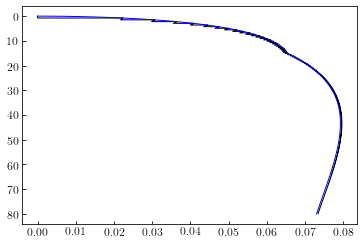

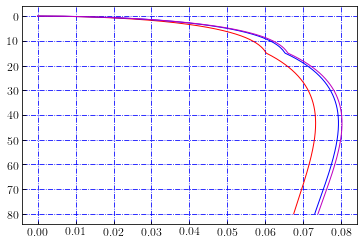

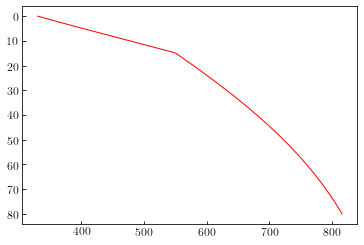

0.0 330.0 0.0
0.01 330.1416350053443 0.0
0.02 330.28329659609426 0.0
0.03 330.4249847478911 0.0
0.04 330.56669943635495 0.0
0.05 330.7084406370848 0.0
0.06 330.85020832565857 0.0
0.07 330.99200247763343 0.0
0.08 331.1338230685451 0.0
0.09 331.2756700739085 0.0
0.1 331.4175434692176 0.0
0.11 331.5594432299454 0.0
0.12 331.7013693315437 0.0
0.13 331.8433217494436 0.0
0.14 331.9853004590552 0.0
0.15 332.1273054357676 0.0
0.16 332.2693366549489 0.0
0.17 332.41139409194665 0.0
0.18 332.55347772208705 0.0
0.19 332.6955875206759 0.0
0.2 332.83772346299764 0.0
0.21 332.9798855243162 0.0
0.22 333.1220736798748 0.0
0.23 333.2642879048953 0.0
0.24 333.4065281745793 0.0
0.25 333.54879446410735 0.0
0.26 333.6910867486393 0.0
0.27 333.83340500331417 0.0
0.28 333.9757492032502 0.0
0.29 334.118119323545 0.0
0.3 334.26051533927546 0.0
0.31 334.4029372254976 0.0
0.32 334.545384957247 0.0
0.33 334.68785850953844 0.0
0.34 334.83035785736575 0.0
0.35000000000000003 334.97288297570265 0.0
0.36 335.115433839

2.11 360.4347448095026 0.031564972572047156
2.12 360.58141830358727 0.031552132906488096
2.13 360.72811279942744 0.03153930184601577
2.14 360.8748282685604 0.031526479384863054
2.15 361.0215646825055 0.03151366551726676
2.16 361.16832201276486 0.03150086023746751
2.17 361.31510023082296 0.031488063539709794
2.18 361.4618993081468 0.031475275418241966
2.19 361.60871921618576 0.03146249586731625
2.2 361.75555992637203 0.031449724881188676
2.21 361.9024214101199 0.0314369624541192
2.22 362.0493036388269 0.03142420858037154
2.23 362.1962065838724 0.03141146325421332
2.24 362.34313021661904 0.03139872646991597
2.25 362.49007450841157 0.031385998221754786
2.2600000000000002 362.6370394305778 0.031373278504008874
2.27 362.784024954428 0.03136056731096119
2.2800000000000002 362.93103105125505 0.031347864636898544
2.29 363.078057692335 0.03133517047611151
2.3000000000000003 363.2251048489259 0.031322484822894556
2.31 363.3721724922693 0.03130980767154593
2.32 363.5192605935891 0.031297139016367

5.73 414.6683822832066 0.05098063709601742
5.74 414.8206763955435 0.05096192045214042
5.75 414.9729802349191 0.05094321635207487
5.76 415.1252937680345 0.05092452478741395
5.7700000000000005 415.2776169615824 0.050905845749756484
5.78 415.42994978224664 0.05088717923070695
5.79 415.58229219670284 0.050868525221875405
5.8 415.7346441716178 0.05084988371487758
5.8100000000000005 415.88700567365 0.0508312547013348
5.82 416.0393766694496 0.050812638172873986
5.83 416.1917571256581 0.05079403412112771
5.84 416.34414700890875 0.05077544253773412
5.8500000000000005 416.4965462858263 0.050756863414337
5.86 416.64895492302736 0.050738296742585696
5.87 416.80137288712 0.050719742514135184
5.88 416.9538001447042 0.050701200720646024
5.89 417.1062366623715 0.050682671353784355
5.9 417.2586824067056 0.05066415440522189
5.91 417.41113734428154 0.05064564986663595
5.92 417.5636014416665 0.05062715772970943
5.93 417.71607466541934 0.05060867798613079
5.94 417.86855698209087 0.05059021062759408
5.95 41

7.53 442.20587587694337 0.05670453575694347
7.54 442.3593774315033 0.05668485891762827
7.55 442.5128826088764 0.05666519526564323
7.5600000000000005 442.66639137469224 0.05664554479215023
7.57 442.81990369457725 0.05662590748831715
7.58 442.97341953415446 0.056606283345317705
7.59 443.12693885904395 0.056586672354331576
7.6000000000000005 443.28046163486266 0.05656707450654432
7.61 443.43398782722426 0.05654748979314746
7.62 443.58751740173943 0.056527918205338375
7.63 443.741050324016 0.056508359734320335
7.640000000000001 443.8945865596586 0.05648881437130253
7.65 444.04812607426874 0.05646928210750007
7.66 444.20166883344547 0.05644976293413387
7.67 444.3552148027844 0.05643025684243081
7.68 444.5087639478786 0.05641076382362361
7.69 444.6623162343181 0.056391283868950884
7.7 444.81587162769034 0.056371816969657075
7.71 444.96943009357966 0.056352363116992564
7.72 445.1229915975678 0.05633292230221354
7.73 445.27655610523396 0.05631349451658206
7.74 445.43012358215435 0.056294079751

11.13 497.43479921566967 0.06240651471329376
11.14 497.58738041415285 0.06238737825368302
11.15 497.7399528923057 0.06236825461924236
11.16 497.8925166165912 0.06234914380137637
11.17 498.04507155347926 0.0623300457914955
11.18 498.1976176694483 0.062310960581015894
11.19 498.35015493098456 0.062291888161359395
11.200000000000001 498.50268330458204 0.06227282852395367
11.21 498.6552027567423 0.06225378166023213
11.22 498.8077132539751 0.06223474756163391
11.23 498.9602147627984 0.062215726219603876
11.24 499.1127072497378 0.06219671762559262
11.25 499.2651906813271 0.06217772177105648
11.26 499.41766502410803 0.06215873864745752
11.27 499.5701302446304 0.06213976824626353
11.28 499.72258630945214 0.062120810558948
11.290000000000001 499.8750331851395 0.06210186557699014
11.3 500.02747083826637 0.06208293329187491
11.31 500.17989923541575 0.06206401369509288
11.32 500.3323183431776 0.06204510677814046
11.33 500.48472812815135 0.062026212532519616
11.34 500.6371285569439 0.06200733094973

12.92 524.5767507882318 0.06363833927119453
12.93 524.7272452604154 0.06362008746825165
12.94 524.8777251597666 0.0636018478975859
12.950000000000001 525.0281904545895 0.0635836205509992
12.96 525.1786411132007 0.06356540542029909
12.97 525.3290771039296 0.06354720249729852
12.98 525.479498395118 0.06352901177381598
12.99 525.6299049551213 0.06351083324167532
13.0 525.7802967523071 0.06349266689270604
13.01 525.9306737550559 0.06347451271874298
13.02 526.081035931761 0.06345637071162658
13.030000000000001 526.2313832508293 0.06343824086320256
13.040000000000001 526.3817156806796 0.06342012316532229
13.05 526.5320331897444 0.06340201760984251
13.06 526.6823357464688 0.06338392418862547
13.07 526.832623319311 0.06336584289353879
13.08 526.9828958767421 0.06334777371645564
13.09 527.1331533872466 0.06332971664925455
13.1 527.2833958193215 0.06331167168381957
13.11 527.4336231414776 0.0632936388120401
13.120000000000001 527.5838353222384 0.06327561802581105
13.13 527.7340323301404 0.063257

16.51 560.6361845270095 0.0673058028606627
16.52 560.6923137384514 0.06729906508033744
16.53 560.74843972696 0.06729232903564122
16.54 560.8045624909495 0.06728559472612705
16.55 560.860682028836 0.0672788621513479
16.56 560.9167983390354 0.0672721313108569
16.57 560.9729114199638 0.0672654022042073
16.580000000000002 561.029021270038 0.06725867483095249
16.59 561.0851278876752 0.06725194919064596
16.6 561.1412312712926 0.0672452252828413
16.61 561.1973314193084 0.0672385031070922
16.62 561.2534283301407 0.06723178266295253
16.63 561.3095220022083 0.0672250639499762
16.64 561.3656124339301 0.06721834696771728
16.65 561.421699623726 0.06721163171572993
16.66 561.4777835700153 0.06720491819356847
16.67 561.5338642712188 0.06719820640078726
16.68 561.589941725757 0.06719149633694084
16.69 561.6460159320507 0.06718478800158387
16.7 561.7020868885216 0.06717808139427105
16.71 561.7581545935918 0.06717137651455726
16.72 561.8142190456831 0.0671646733619975
16.73 561.8702802432186 0.067157971

20.14 580.7870910560403 0.07103989408128358
20.150000000000002 580.8419494509727 0.07103318462345404
20.16 580.8968040748728 0.07102647689395783
20.17 580.9516549263093 0.07101977089234973
20.18 581.0065020038514 0.07101306661818459
20.19 581.0613453060682 0.07178865518240311
20.2 581.11618483153 0.07178188053752746
20.21 581.1710205788067 0.07177510763777706
20.22 581.2258525464696 0.07176833648270241
20.23 581.2806807330896 0.07176156707185408
20.240000000000002 581.3355051372388 0.07175479940478272
20.25 581.390325757489 0.0717480334810392
20.26 581.4451425924127 0.07174126930017444
20.27 581.4999556405834 0.07173450686173943
20.28 581.5547649005744 0.07172774616528536
20.29 581.6095703709597 0.0717209872103635
20.3 581.6643720503132 0.07171422999652527
20.31 581.7191699372105 0.0717074745233221
20.32 581.7739640302266 0.07170072079030566
20.330000000000002 581.8287543279371 0.07169396879702768
20.34 581.8835408289184 0.07168721854303998
20.35 581.938323531747 0.07168047002789457
20

23.76 600.3885238779058 0.07430968058608248
23.77 600.4419272155681 0.07430307147904973
23.78 600.4953262941242 0.07429646407450029
23.79 600.5487211123118 0.0742898583719956
23.8 600.602111668869 0.0742832543710972
23.81 600.6554979625342 0.0742766520713668
23.82 600.708879992047 0.07427005147236612
23.830000000000002 600.7622577561463 0.07426345257365709
23.84 600.8156312535721 0.07425685537480177
23.85 600.8690004830652 0.0742502598753622
23.86 600.9223654433664 0.07424366607490067
23.87 600.9757261332172 0.07423707397297952
23.88 601.0290825513596 0.0742304835691612
23.89 601.082434696536 0.07422389486300829
23.900000000000002 601.1357825674893 0.07421730785408347
23.91 601.1891261629628 0.07421072254194953
23.92 601.2424654817005 0.07420413892616942
23.93 601.2958005224467 0.07419755700630615
23.94 601.3491312839462 0.07419097678192285
23.95 601.4024577649445 0.07418439825258276
23.96 601.4557799641872 0.07417782141784927
23.97 601.5090978804209 0.07417124627728583
23.98 601.56241

25.560000000000002 609.9313243580959 0.07554084983527724
25.57 609.9839411851948 0.07553433372957952
25.580000000000002 610.036553533826 0.07552781930240825
25.59 610.0891614028156 0.07552130655333104
25.6 610.1417647909899 0.07551479548191568
25.61 610.194363697176 0.07550828608772996
25.62 610.2469581202012 0.07550177837034185
25.63 610.2995480588933 0.07549527232931942
25.64 610.352133512081 0.07548876796423082
25.650000000000002 610.4047144785932 0.07548226527464434
25.66 610.4572909572591 0.0754757642601284
25.67 610.5098629469092 0.07546926492025148
25.68 610.5624304463732 0.0754627672545822
25.69 610.6149934544825 0.07545627126268935
25.7 610.6675519700684 0.07544977694414168
25.71 610.7201059919627 0.0754432842985082
25.72 610.7726555189979 0.07543679332535798
25.73 610.8252005500071 0.07543030402426014
25.740000000000002 610.8777410838236 0.07542381639478399
25.75 610.9302771192813 0.07541733043649894
25.76 610.9828086552146 0.07541084614897449
25.77 611.0353356904583 0.075404

29.14 628.4733952631223 0.07738453895767025
29.150000000000002 628.5243375810952 0.07737826688902617
29.16 628.5752750324674 0.07737199643604549
29.17 628.6262076162457 0.07736572759831198
29.18 628.6771353314381 0.07735946037540956
29.19 628.7280581770528 0.07735319476692222
29.2 628.7789761520983 0.07734693077243415
29.21 628.8298892555836 0.0773406683915296
29.22 628.880797486519 0.07733440762379283
29.23 628.9317008439142 0.07732814846880838
29.240000000000002 628.9825993267801 0.07732189092616076
29.25 629.033492934128 0.07731563499543467
29.26 629.0843816649696 0.07730938067621486
29.27 629.1352655183172 0.07730312796808622
29.28 629.1861444931834 0.07729687687063375
29.29 629.2370185885818 0.07729062738344253
29.3 629.2878878035261 0.07728437950609775
29.310000000000002 629.3387521370306 0.07727813323818473
29.32 629.3896115881101 0.07727188857928892
29.330000000000002 629.44046615578 0.0772656455289958
29.34 629.4913158390559 0.07725940408689104
29.35 629.5421606369548 0.077253

30.93 637.5136283859905 0.07804729117157398
30.94 637.5636842480623 0.07804116358849722
30.95 637.6137350739999 0.07803503758386483
30.96 637.6637808629026 0.07802891315727022
30.970000000000002 637.7138216138704 0.07802279030830685
30.98 637.7638573260032 0.0780166690365684
30.990000000000002 637.8138879984019 0.07801054934164853
31.0 637.8639136301678 0.07800443122314107
31.01 637.9139342204026 0.07799831468063996
31.02 637.9639497682087 0.07799219971373919
31.03 638.0139602726891 0.07798608632203292
31.04 638.0639657329469 0.07797997450511537
31.05 638.1139661480861 0.07797386426258092
31.060000000000002 638.163961517211 0.07796775559402395
31.07 638.2139518394267 0.07796164849903904
31.080000000000002 638.2639371138384 0.07795554297722085
31.09 638.3139173395521 0.07794943902816413
31.1 638.3638925156741 0.07794333665146376
31.11 638.4138626413119 0.07793723584671466
31.12 638.4638277155722 0.07793113661351196
31.13 638.5137877375635 0.0779250389514508
31.14 638.5637427063944 0.077

32.730000000000004 646.4417122402772 0.07856187597304765
32.74 646.4908475797437 0.07855590502317339
32.75 646.5399777292455 0.07854993561139534
32.76 646.5891026879747 0.07854396773731728
32.77 646.6382224551239 0.07853800140054308
32.78 646.6873370298861 0.07853203660067677
32.79 646.7364464114547 0.07852607333732246
32.8 646.7855505990241 0.07852011161008432
32.81 646.8346495917888 0.07851415141856666
32.82 646.8837433889439 0.07850819276237388
32.83 646.9328319896852 0.0785022356411105
32.84 646.9819153932089 0.07849628005438108
32.85 647.0309935987115 0.07849032600179039
32.86 647.08006660539 0.07848437348294324
32.87 647.1291344124426 0.0784784224974445
32.88 647.1781970190672 0.0784724730448992
32.89 647.2272544244626 0.07846652512491248
32.9 647.2763066278281 0.07846057873708952
32.910000000000004 647.3253536283636 0.07845463388103567
32.92 647.3743954252693 0.07844869055635632
32.93 647.4234320177458 0.07844274876265706
32.94 647.4724634049946 0.07843680849954343
32.95 647.521

36.36 663.9308221054075 0.07922062914030843
36.37 663.9780244638239 0.0792149973266145
36.38 664.0252213726898 0.07920936696365644
36.39 664.0724128313826 0.07920373805106057
36.4 664.1195988392808 0.07919811058845327
36.410000000000004 664.1667793957631 0.079192484575461
36.42 664.2139545002084 0.0791868600117104
36.43 664.2611241519965 0.07918123689682811
36.44 664.3082883505073 0.07948401471954783
36.45 664.3554470951219 0.07947837260978942
36.46 664.4026003852213 0.07947273195341915
36.47 664.4497482201872 0.07946709275006258
36.480000000000004 664.4968905994018 0.07946145499934545
36.49 664.5440275222477 0.07945581870089358
36.5 664.5911589881083 0.07945018385433283
36.51 664.6382849963671 0.07944455045928923
36.52 664.6854055464086 0.07943891851538887
36.53 664.7325206376172 0.07943328802225791
36.54 664.7796302693782 0.07942765897952268
36.550000000000004 664.8267344410775 0.07942203138680953
36.56 664.8738331521013 0.07941640524374496
36.57 664.9209264018361 0.07941078054995554

39.980000000000004 680.6574702554293 0.0797645590052596
39.99 680.7026631405482 0.07975926331486953
40.0 680.7478503834617 0.07975396898863114
40.01 680.7930319837272 0.079748676026193
40.02 680.8382079409022 0.07974338442720386
40.03 680.8833782545449 0.07973809419131243
40.04 680.928542924214 0.07973280531816765
40.050000000000004 680.9737019494689 0.07972751780741841
40.06 681.0188553298691 0.0797222316587138
40.07 681.0640030649745 0.07971694687170296
40.08 681.1091451543459 0.07971166344603514
40.09 681.1542815975447 0.0797063813813596
40.1 681.199412394132 0.07970110067732585
40.11 681.24453754367 0.07969582133358331
40.12 681.2896570457216 0.0796905433497816
40.13 681.3347708998494 0.07968526672557041
40.14 681.3798791056173 0.07967999146059951
40.15 681.424981662589 0.07967471755451878
40.160000000000004 681.4700785703291 0.07966944500697816
40.17 681.5151698284027 0.07966417381762768
40.18 681.560255436375 0.07965890398611751
40.19 681.6053353938122 0.07965363551209784
40.2 68

43.6 696.6454932284045 0.07992923180288576
43.61 696.6886184551062 0.07992428416035181
43.62 696.7317379104234 0.07991933779231358
43.63 696.7748515940838 0.07991439269844282
43.64 696.8179595058158 0.07990944887841124
43.65 696.861061645348 0.07990450633189077
43.660000000000004 696.9041580124095 0.07989956505855329
43.67 696.9472486067302 0.07989462505807088
43.68 696.9903334280398 0.07988968633011566
43.69 697.033412476069 0.07988474887435981
43.7 697.0764857505488 0.0798798126904756
43.71 697.1195532512106 0.07987487777813543
43.72 697.1626149777863 0.07986994413701175
43.730000000000004 697.2056709300081 0.07986501176677711
43.74 697.2487211076092 0.07986008066710408
43.75 697.2917655103222 0.07985515083766544
43.76 697.3348041378814 0.07985022227813393
43.77 697.3778369900207 0.07984529498818246
43.78 697.4208640664748 0.07984036896748396
43.79 697.4638853669786 0.07983544421571151
43.800000000000004 697.506900891268 0.07983052073253818
43.81 697.5499106390785 0.07982559851763726

47.22 711.8778989642865 0.07980699679616164
47.230000000000004 711.9189206714203 0.07980239821175163
47.24 711.9599365376711 0.07979780081192114
47.25 712.000946562925 0.0797932045963651
47.26 712.0419507470692 0.07978860956477843
47.27 712.0829490899911 0.07978401571685612
47.28 712.1239415915782 0.07977942305229327
47.29 712.1649282517191 0.07977483157078503
47.300000000000004 712.2059090703019 0.0797702412720267
47.31 712.2468840472162 0.07976565215571356
47.32 712.287853182351 0.07976106422154104
47.33 712.3288164755965 0.07975647746920461
47.34 712.3697739268423 0.07975189189839989
47.35 712.41072553598 0.07974730750882243
47.36 712.4516713029003 0.079742724300168
47.37 712.4926112274946 0.07973814227213241
47.38 712.5335453096552 0.07973356142441151
47.39 712.5744735492743 0.07972898175670126
47.4 712.6153959462446 0.07972440326869772
47.410000000000004 712.6563125004593 0.07971982596009697
47.42 712.6972232118125 0.07971524983059519
47.43 712.7381280801975 0.0797106748798887
47.

49.02 719.1676187414415 0.0795958323519086
49.03 719.2075876581157 0.07959140892917854
49.04 719.2475507201401 0.079586986645907
49.050000000000004 719.2875079274753 0.07972350793308194
49.06 719.3274592800818 0.07971908009992283
49.07 719.367404777921 0.07971465340735832
49.08 719.4073444209542 0.07971022785509464
49.09 719.4472782091435 0.07970580344283805
49.1 719.4872061424512 0.07970138017029486
49.11 719.5271282208399 0.07969695803717153
49.120000000000005 719.5670444442733 0.07969253704317447
49.13 719.6069548127141 0.07968811718801033
49.14 719.6468593261269 0.07968369847138569
49.15 719.6867579844759 0.0796792808930073
49.160000000000004 719.7266507877256 0.07967486445258194
49.17 719.7665377358413 0.07967044914981648
49.18 719.8064188287885 0.07966603498441788
49.19 719.8462940665332 0.07966162195609314
49.2 719.8861634490418 0.07965721006454933
49.21 719.9260269762808 0.07965279930949366
49.22 719.9658846482176 0.07964838969063334
49.230000000000004 720.0057364648196 0.07964

52.6 733.1023243764336 0.07931597968309363
52.61 733.1401977516468 0.07931188228962352
52.620000000000005 733.1780652827113 0.07930778595162788
52.63 733.2159269697229 0.07930369066883486
52.64 733.2537828127784 0.07929959644097263
52.65 733.2916328119744 0.07929550326776946
52.660000000000004 733.3294769674084 0.07929141114895366
52.67 733.3673152791778 0.07928732008425364
52.68 733.405147747381 0.07928323007339781
52.69 733.4429743721158 0.07927914111611477
52.7 733.4807951534812 0.0792750532121331
52.71 733.5186100915763 0.07927096636118146
52.72 733.5564191865003 0.0792668805629886
52.730000000000004 733.5942224383531 0.07926279581728335
52.74 733.6320198472348 0.07925871212379457
52.75 733.6698114132458 0.07925462948225122
52.76 733.707597136487 0.07925054789238233
52.77 733.7453770170598 0.07924646735391695
52.78 733.7831510550653 0.07924238786658432
52.79 733.8209192506059 0.0792383094301136
52.800000000000004 733.8586816037835 0.07923423204423415
52.81 733.8964381147007 0.07923

56.18 746.2884986867446 0.07876071298371357
56.19 746.3242886370643 0.07875693601698777
56.2 746.3600727996298 0.07875316002319563
56.21 746.3958511746577 0.07874938500208652
56.22 746.4316237623644 0.0787456109534099
56.230000000000004 746.4673905629675 0.07874183787691529
56.24 746.5031515766842 0.07873806577235222
56.25 746.5389068037327 0.07873429463947033
56.26 746.5746562443309 0.07873052447801937
56.27 746.6103998986972 0.07872675528774904
56.28 746.6461377670506 0.07872298706840918
56.29 746.6818698496098 0.07871921981974972
56.300000000000004 746.7175961465945 0.07871545354152058
56.31 746.7533166582244 0.07871168823347177
56.32 746.7890313847195 0.0787079238953534
56.33 746.8247403262999 0.07870416052691562
56.34 746.8604434831864 0.07878118964402306
56.35 746.8961408556 0.07877742435282382
56.36 746.9318324437619 0.07877366003155067
56.370000000000005 746.9675182478938 0.07876989667995377
56.38 747.0031982682175 0.07876613429778331
56.39 747.0388725049551 0.07876237288478961

59.76 758.7332936926101 0.07816784370689396
59.77 758.7670277634674 0.07816436843782996
59.78 758.8007561432217 0.07816089406398335
59.79 758.8344788321941 0.07815742058512354
59.800000000000004 758.8681958307062 0.07815394800101993
59.81 758.901907139079 0.07815047631144209
59.82 758.9356127576347 0.07814700551615958
59.83 758.969312686695 0.07814353561494203
59.84 759.003006926583 0.0781400666075591
59.85 759.0366954776206 0.07813659849378056
59.86 759.0703783401307 0.07813313127337627
59.870000000000005 759.104055514437 0.07812966494611602
59.88 759.1377270008625 0.07812619951176981
59.89 759.171392799731 0.07812273497010758
59.9 759.2050529113665 0.07811927132089941
59.910000000000004 759.2387073360932 0.07811580856391537
59.92 759.2723560742355 0.07811234669892567
59.93 759.3059991261184 0.0781088857257005
59.94 759.3396364920668 0.07810542564401016
59.95 759.3732681724061 0.07810196645362498
59.96 759.4068941674618 0.07809850815431538
59.97 759.4405144775595 0.07809505074585182
5

63.32 770.3855671915321 0.07743540349731658
63.33 770.4172974410843 0.0774322142585945
63.34 770.4490221299096 0.0774290258414094
63.35 770.4807412584172 0.07742583824554962
63.36 770.5124548270162 0.0774226514708036
63.370000000000005 770.5441628361165 0.0774194655169598
63.38 770.5758652861274 0.0774162803838068
63.39 770.6075621774593 0.07745474776681847
63.4 770.6392535105223 0.07745156256155206
63.410000000000004 770.6709392857267 0.0774483781767836
63.42 770.7026195034834 0.07744519461230172
63.43 770.734294164203 0.07744201186789514
63.440000000000005 770.7659632682968 0.07743882994335259
63.45 770.7976268161763 0.07743564883846289
63.46 770.8292848082527 0.0774324685530149
63.47 770.8609372449381 0.07742928908679753
63.480000000000004 770.8925841266445 0.07742611043959972
63.49 770.924225453784 0.07742293261121054
63.5 770.955861226769 0.07741975560141905
63.51 770.9874914460122 0.0774165794100144
63.52 771.0191161119268 0.07741340403678573
63.53 771.0507352249256 0.07741022948

66.97 781.6011552997993 0.07666153715676399
66.98 781.6308847863218 0.07665862131991562
66.99 781.6606088754627 0.07665570623417681
67.0 781.6903275677055 0.07665279189935406
67.01 781.7200408635339 0.07667602495276529
67.02 781.7497487634317 0.07667311112557511
67.03 781.7794512678832 0.07667019804897682
67.04 781.8091483773727 0.07666728572277703
67.05 781.8388400923843 0.07666437414678251
67.06 781.868526413403 0.07666146332079998
67.07000000000001 781.8982073409135 0.07665855324463622
67.08 781.9278828754005 0.07665564391809811
67.09 781.9575530173496 0.07665273534099253
67.1 781.987217767246 0.0766498275131264
67.11 782.0168771255751 0.07664692043430678
67.12 782.0465310928229 0.07664401410434069
67.13 782.076179669475 0.07664110852303521
67.14 782.1058228560175 0.07663820369019754
67.15 782.135460652937 0.07663529960563481
67.16 782.1650930607198 0.0766323962691543
67.17 782.1947200798521 0.07662949368056332
67.18 782.2243417108214 0.07662659183966918
67.19 782.253957954114 0.076

70.61 792.0700851930465 0.07585912752670022
70.62 792.0978833520489 0.07585646530005741
70.63 792.1256763008405 0.07585380375919505
70.64 792.1534640399641 0.07585114290393648
70.65 792.181246569962 0.0758484827341051
70.66 792.2090238913775 0.07584582324952434
70.67 792.2367960047534 0.07584316445001768
70.68 792.264562910633 0.07584050633540863
70.69 792.2923246095595 0.07583784890552081
70.7 792.3200811020763 0.0758351921601778
70.71000000000001 792.347832388727 0.07583253609920329
70.72 792.3755784700554 0.07582988072242097
70.73 792.4033193466056 0.07582722602965457
70.74 792.4310550189211 0.07582457202072794
70.75 792.4587854875466 0.0758219186954649
70.76 792.486510753026 0.07581926605368934
70.77 792.5142308159038 0.07581661409522521
70.78 792.5419456767247 0.07581396281989648
70.79 792.5696553360334 0.07581131222752716
70.8 792.5973597943747 0.07580866231794135
70.81 792.6250590522935 0.07580601309096317
70.82000000000001 792.6527531103352 0.07580336454641676
70.83 792.6804419

72.43 797.0440751029018 0.07543495117331477
72.44 797.0709340766186 0.07543240923471901
72.45 797.0977879411171 0.07542986795091791
72.46000000000001 797.1246366969642 0.0754273273217428
72.47 797.1514803447267 0.07542478734702505
72.48 797.1783188849718 0.07542224802659608
72.49 797.2051523182663 0.07541970936028733
72.5 797.2319806451778 0.07541717134793031
72.51 797.2588038662736 0.07541463398935656
72.52 797.2856219821211 0.07541209728439768
72.53 797.3124349932882 0.0754095612328853
72.54 797.3392429003424 0.07540702583465107
72.55 797.3660457038513 0.07540449108952675
72.56 797.3928434043837 0.07540195699734405
72.57000000000001 797.4196360025071 0.0753994235579348
72.58 797.44642349879 0.07539689077113088
72.59 797.4732058938006 0.07539435863676412
72.60000000000001 797.4999831881074 0.0753918271546665
72.61 797.5267553822792 0.07538929632466998
72.62 797.5535224768846 0.07538676614660658
72.63 797.5802844724924 0.07538423662030838
72.64 797.6070413696718 0.07538170774560744
72.

74.25 801.848819801977 0.07500802079341395
74.26 801.8747583507613 0.0750055944803441
74.27 801.9006918954132 0.07500316879228418
74.28 801.9266204365197 0.07500074372907316
74.29 801.9525439746686 0.07499831929055012
74.3 801.978462510448 0.07499589547655412
74.31 802.0043760444457 0.07499347228692428
74.32000000000001 802.0302845772495 0.07499104972149978
74.33 802.0561881094478 0.0749886277801198
74.34 802.0820866416285 0.07498620646262363
74.35000000000001 802.1079801743801 0.07498378576885054
74.36 802.133868708291 0.07498136569863986
74.37 802.1597522439497 0.07497894625183095
74.38 802.1856307819447 0.07497652742826325
74.39 802.2115043228649 0.0749741092277762
74.4 802.2373728672992 0.0749716916502093
74.41 802.2632364158364 0.07496927469540207
74.42 802.2890949690657 0.07496685836319411
74.43 802.3149485275758 0.07496444265342506
74.44 802.3407970919566 0.07496202756593454
74.45 802.3666406627971 0.07495961310056226
74.46000000000001 802.3924792406867 0.07495719925714799
74.47

76.07000000000001 806.4877977995418 0.07458015181906953
76.08 806.5128353740574 0.07457783653526169
76.09 806.5378680530202 0.07457552184786302
76.10000000000001 806.5628958370354 0.0745732077567199
76.11 806.5879187267087 0.07457089426167868
76.12 806.612936722645 0.07456858136258586
76.13 806.6379498254497 0.07456626905928793
76.14 806.6629580357286 0.07456395735163138
76.15 806.6879613540873 0.07456164623946276
76.16 806.7129597811311 0.07455933572262878
76.17 806.7379533174665 0.07455702580097594
76.18 806.7629419636988 0.07455471647435102
76.19 806.7879257204344 0.0745524077426007
76.2 806.8129045882789 0.07455009960557178
76.21000000000001 806.8378785678389 0.07454779206311102
76.22 806.8628476597204 0.07454580560913568
76.23 806.8878118645297 0.07454349924543613
76.24 806.9127711828731 0.07454119347584796
76.25 806.9377256153577 0.07453888830021808
76.26 806.9626751625893 0.07453658371839357
76.27 806.9876198251751 0.07453427973022142
76.28 807.0125596037216 0.07453197633554873


79.7 815.2596277323737 0.07377801984648272
79.71000000000001 815.2829286169817 0.07377591126176113
79.72 815.3062248308073 0.07377380322020374
79.73 815.3295163744823 0.07377169572167062
79.74 815.3528032486377 0.07376958876602191
79.75 815.3760854539054 0.07376748235311772
79.76 815.3993629909166 0.07376537648281829
79.77 815.4226358603033 0.0737632711549838
79.78 815.4459040626969 0.07376116636947457
79.79 815.4691675987292 0.07375906212615084
79.8 815.4924264690321 0.07375695842487297
79.81 815.5156806742374 0.07375485526550132
79.82000000000001 815.538930214977 0.07375275264789632
79.83 815.5621750918826 0.0737506505719184
79.84 815.5854153055867 0.07374854903742804
79.85000000000001 815.6086508567209 0.07374644804428576
79.86 815.6318817459176 0.07374434759235211
79.87 815.655107973809 0.07374224768148765
79.88 815.6783295410271 0.07374014831155304
79.89 815.7015464482046 0.0737380494824089
79.9 815.7247586959735 0.07373595119391596
79.91 815.7479662849662 0.07373385344593494
79.9

81.52 819.4240826437135 0.07340275160825274
81.53 819.4465438982285 0.07340073961869924
81.54 819.4690005977315 0.07339872814742734
81.55 819.4914527428626 0.07339671719430356
81.56 819.5139003342626 0.07339470675919439
81.57000000000001 819.5363433725721 0.0733926968419664
81.58 819.5587818584313 0.07339068744248621
81.59 819.581215792481 0.07338867856062042
81.60000000000001 819.6036451753619 0.0733866701962357
81.61 819.6260700077145 0.07338466234919876
81.62 819.6484902901797 0.07338265501937631
81.63 819.6709060233978 0.07338064820663516
81.64 819.6933172080102 0.07337864191084208
81.65 819.7157238446574 0.07337663613186392
81.66 819.7381259339804 0.07337463086956751
81.67 819.76052347662 0.07337262612381983
81.68 819.7829164732176 0.07337062189448773
81.69 819.8053049244136 0.07336861818143826
81.7 819.8276888308493 0.07336661498453839
81.71000000000001 819.8500681931658 0.07336461230365517
81.72 819.8724430120044 0.07336261013865567
81.73 819.894813288006 0.07336060848940701
81.

83.34 823.4376400250025 0.07304528973566093
83.35000000000001 823.4592828543745 0.07304336989970171
83.36 823.4809212459172 0.07304145055828565
83.37 823.5025552002774 0.07303953171128535
83.38 823.5241847181022 0.07303761335857345
83.39 823.5458098000386 0.07303569550002263
83.4 823.5674304467335 0.0730337781355056
83.41 823.589046658834 0.07303186126489508
83.42 823.6106584369875 0.07302994488806386
83.43 823.6322657818406 0.07302802900488471
83.44 823.6538686940405 0.07302611361523054
83.45 823.6754671742347 0.07302419871897414
83.46000000000001 823.69706122307 0.07302228431598846
83.47 823.7186508411942 0.073020056470365
83.48 823.7402360292539 0.0730181430617659
83.49 823.7618167878968 0.07301623014605427
83.5 823.78339311777 0.07301431772310318
83.51 823.8049650195208 0.07301240579278569
83.52 823.8265324937968 0.07301049435497486
83.53 823.848095541245 0.07300858340954389
83.54 823.8696541625134 0.07300667295636587
83.55 823.8912083582488 0.07300476299531405
83.56 823.9127581290

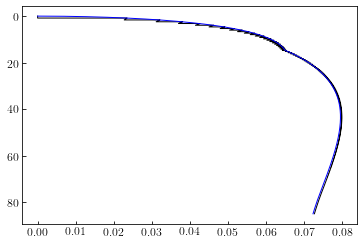

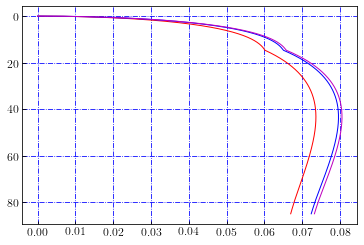

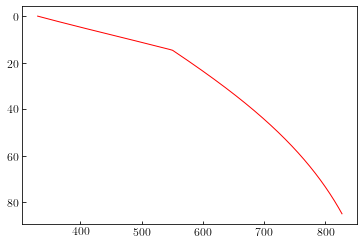

0.0 330.0 0.0
0.01 330.1405884163088 0.0
0.02 330.28120302679133 0.0
0.03 330.4218438076252 0.0
0.04 330.562510734967 0.0
0.05 330.70320378495336 0.0
0.06 330.84392293370024 0.0
0.07 330.9846681573033 0.0
0.08 331.1254394318376 0.0
0.09 331.266236733358 0.0
0.1 331.407060037899 0.0
0.11 331.54790932147444 0.0
0.12 331.688784560078 0.0
0.13 331.82968572968315 0.0
0.14 331.97061280624285 0.0
0.15 332.11156576568976 0.0
0.16 332.25254458393624 0.0
0.17 332.3935492368743 0.0
0.18 332.53457970037584 0.0
0.19 332.6756359502925 0.0
0.2 332.8167179624553 0.0
0.21 332.9578257126755 0.0
0.22 333.0989591767438 0.0
0.23 333.2401183304309 0.0
0.24 333.381303149487 0.0
0.25 333.5225136096426 0.0
0.26 333.6637496866075 0.0
0.27 333.8050113560717 0.0
0.28 333.946298593705 0.0
0.29 334.0876113751569 0.0
0.3 334.22894967605674 0.0
0.31 334.3703134720142 0.0
0.32 334.51170273861834 0.0
0.33 334.65311745143856 0.0
0.34 334.7945575860238 0.0
0.35000000000000003 334.9360231179033 0.0
0.36 335.07751402258606

3.93 387.01086469907324 0.040695793634312825
3.94 387.15972183281974 0.0406801467091439
3.95 387.3085943805156 0.04066451019301928
3.96 387.4574823115861 0.04064888407901444
3.97 387.6063855954436 0.04063326836020936
3.98 387.75530420148715 0.04061766302968872
3.99 387.90423809910266 0.040602068080541766
4.0 388.05318725766324 0.04058648350586231
4.01 388.2021516465287 0.04057090929874881
4.0200000000000005 388.351131235046 0.040555345452304284
4.03 388.5001259925491 0.04053979195963634
4.04 388.64913588835896 0.04052424881385718
4.05 388.7981608917836 0.040508716008083576
4.0600000000000005 388.9472009721179 0.040493193535436914
4.07 389.0962560986446 0.04047768138904309
4.08 389.2453262406324 0.04046217956203265
4.09 389.39441136733836 0.04044668804754064
4.1 389.54351144800586 0.04043120683870673
4.11 389.692626451866 0.04041573592867511
4.12 389.8417563481367 0.04040027531059456
4.13 389.9909011060235 0.04038482497761841
4.14 390.14006069471895 0.04036938492290454
4.15 390.28923508

5.75 414.32598864426785 0.050001272293973824
5.76 414.4771356426288 0.04998303837569086
5.7700000000000005 414.6282922988006 0.049964816587437365
5.78 414.77945858023605 0.04994660692114391
5.79 414.9306344543797 0.04992840936874641
5.8 415.0818198886676 0.04991022392218615
5.8100000000000005 415.2330148505277 0.04989205057340978
5.82 415.3842193073793 0.049873889314369306
5.83 415.5354332266337 0.049855740137022084
5.84 415.68665657569363 0.04983760303333083
5.8500000000000005 415.8378893219539 0.049819477995263595
5.86 415.9891314328009 0.04980136501479378
5.87 416.1403828756127 0.04978326408390013
5.88 416.2916436177597 0.04976517519456671
5.89 416.4429136266036 0.049747098338782936
5.9 416.59419286949844 0.049729033508543546
5.91 416.7454813137899 0.04971098069584859
5.92 416.8967789268158 0.049692939892703465
5.93 417.0480856759056 0.04967491109111888
5.94 417.19940152838143 0.04965689428311082
5.95 417.3507264515567 0.049638889460700664
5.96 417.50206041273736 0.04962089661591500

9.35 469.1076198453241 0.056935021085281305
9.36 469.2600952571126 0.056916521343085225
9.370000000000001 469.41256828768115 0.05689803390775673
9.38 469.5650389033251 0.056879558771108764
9.39 469.7175070703424 0.05686109592495966
9.4 469.86997275503245 0.05684264536113325
9.41 470.0224359236976 0.05682420707145877
9.42 470.17489654264233 0.056805781047770856
9.43 470.3273545781728 0.05678736728190967
9.44 470.4798099965979 0.056768965765720714
9.450000000000001 470.63226276422876 0.056750576491054985
9.46 470.78471284737896 0.056732199449768844
9.47 470.9371602123641 0.056713834633724106
9.48 471.0896048255029 0.05669548203478795
9.49 471.2420466531157 0.056677141644833035
9.5 471.39448566152566 0.05665881345573739
9.51 471.54692181705855 0.05664049745938443
9.52 471.69935508604243 0.05662219364766302
9.53 471.85178543480805 0.05660390201246737
9.540000000000001 472.00421282968887 0.0565856225456971
9.55 472.1566372370207 0.056567355239257225
9.56 472.30905862314194 0.056549100085058

12.91 522.9898495607875 0.060930333916709524
12.92 523.1393826626495 0.06091291771343751
12.93 523.2889017363368 0.060895513096213855
12.94 523.4384067507211 0.06087812005733101
12.950000000000001 523.5878976746865 0.0608607385890865
12.96 523.7373744771284 0.060843368683783046
12.97 523.8868371269546 0.06082601033372847
12.98 524.0362855930858 0.06080866353123564
12.99 524.1857198444538 0.06079132826862266
13.0 524.3351398500033 0.06077400453821265
13.01 524.4845455786912 0.06075669233233384
13.02 524.6339369994862 0.060739391643319623
13.030000000000001 524.7833140813697 0.06072210246350845
13.040000000000001 524.9326767933353 0.06070482478524386
13.05 525.0820251043889 0.06068755860087452
13.06 525.2313589835488 0.060670303902754144
13.07 525.3806783998452 0.060653060683241625
13.08 525.5299833223218 0.0606358289347008
13.09 525.6792737200335 0.060618608649500694
13.1 525.8285495620485 0.06060139982001537
13.11 525.977810817447 0.06058420243862396
13.120000000000001 526.127057455322

14.69 549.3575104442449 0.06169152670819053
14.700000000000001 549.5040683083073 0.061675073002191716
14.71 549.6506068158068 0.0616586302419444
14.72 549.7971259381372 0.06164219842016699
14.73 549.9436256467086 0.06162577752958273
14.74 550.0332771077271 0.06161573297187709
14.75 550.0873703600247 0.06160967394276875
14.76 550.1414609568842 0.06160361640253157
14.77 550.1955488968686 0.061597560350799635
14.780000000000001 550.2496341785396 0.06159150578720725
14.790000000000001 550.3037168004606 0.06158545271138868
14.8 550.3577967611945 0.06157940112297835
14.81 550.4118740593048 0.061573351021610774
14.82 550.4659486933549 0.06156730240692055
14.83 550.5200206619089 0.061561255278542365
14.84 550.5740899635314 0.06155520963611097
14.85 550.6281565967869 0.06154916547926122
14.86 550.68222056024 0.061543122807628095
14.870000000000001 550.7362818524564 0.06153708162084661
14.88 550.7903404720013 0.06153104191855192
14.89 550.8443964174405 0.061525003700379235
14.9 550.8984496873404

18.3 569.1121617862664 0.06643189532961843
18.31 569.1652211866077 0.06642570233609298
18.32 569.2182774397177 0.06641951086435738
18.330000000000002 569.2713305442738 0.06641332091403775
18.34 569.3243804989545 0.06640713248476023
18.35 569.3774273024384 0.06640094557615106
18.36 569.4304709534044 0.06639476018783655
18.37 569.4835114505321 0.06638857631944314
18.38 569.536548792501 0.06638239397059731
18.39 569.5895829779911 0.06637621314092569
18.400000000000002 569.6426140056826 0.066370033830055
18.41 569.6956418742565 0.066363856037612
18.42 569.7486665823938 0.06635767976322356
18.43 569.8016881287757 0.06635150500651668
18.44 569.8547065120842 0.0663453317671184
18.45 569.9077217310014 0.0663391600446559
18.46 569.9607337842095 0.0663329898387564
18.47 570.0137426703917 0.06632682114904727
18.48 570.0667483882308 0.0663206539751559
18.490000000000002 570.1197509364106 0.06631448831670983
18.5 570.1727503136146 0.0663083241733367
18.51 570.2257465185273 0.06630216154466417
18.52

21.92 588.103904972333 0.06981251058885722
21.93 588.1557414871285 0.06980635773344362
21.94 588.2075743996185 0.06980020638995688
21.95 588.259403708613 0.06979405655802548
21.96 588.3112294129232 0.06978790823727797
21.97 588.3630515113604 0.06978176142734302
21.98 588.4148700027356 0.06977561612784938
21.990000000000002 588.466684885861 0.06976947233842591
22.0 588.5184961595488 0.06976333005870154
22.01 588.5703038226117 0.0697571892883053
22.02 588.6221078738629 0.06975105002686625
22.03 588.6739083121157 0.06974491227401368
22.04 588.7257051361839 0.06973877602937684
22.05 588.777498344882 0.0697326412925851
22.06 588.8292879370242 0.06972650806326801
22.07 588.8810739114258 0.06972037634105507
22.080000000000002 588.932856266902 0.06971424612557599
22.09 588.9846350022685 0.06970811741646052
22.1 589.0364101163418 0.06970199021333846
22.11 589.0881816079378 0.06969586451583981
22.12 589.139949475874 0.06968974032359455
22.13 589.1917137189674 0.06968361763623282
22.14 589.243474

25.52 606.5233633037791 0.07221320079807529
25.53 606.5738291232693 0.07220719279347418
25.54 606.6242909375383 0.0722011862652061
25.55 606.6747487455392 0.07219518121290823
25.560000000000002 606.7252025462255 0.07218917763621792
25.57 606.7756523385515 0.07218317553477252
25.580000000000002 606.8260981214712 0.07217717490820957
25.59 606.8765398939393 0.07217117575616665
25.6 606.9269776549111 0.07216517807828139
25.61 606.9774114033421 0.07215918187419158
25.62 607.0278411381883 0.07215318714353507
25.63 607.0782668584059 0.07214719388594978
25.64 607.1286885629518 0.07214120210107376
25.650000000000002 607.1791062507832 0.0721352117885451
25.66 607.2295199208578 0.07212922294800199
25.67 607.2799295721335 0.07212323557908276
25.68 607.3303352035686 0.07211724968142579
25.69 607.3807368141221 0.07211126525466952
25.7 607.4311344027532 0.0721052822984525
25.71 607.4815279684216 0.07209930081241343
25.72 607.5319175100869 0.07209332079619103
25.73 607.5823030267102 0.0720873422494241

29.1 624.3265193589316 0.07389177809474518
29.11 624.3754875378571 0.07388598295082444
29.12 624.4244513632184 0.07388018923093094
29.13 624.4734108341177 0.07387439693471474
29.14 624.5223659496573 0.07386860606182605
29.150000000000002 624.5713167089405 0.07386281661191509
29.16 624.6202631110705 0.07385702858463218
29.17 624.6692051551511 0.07385124197962777
29.18 624.7181428402868 0.07384545679655234
29.19 624.7670761655818 0.07383967303505651
29.2 624.8160051301414 0.07383389069479096
29.21 624.8649297330713 0.07382810977540642
29.22 624.9138499734772 0.07382233027655376
29.23 624.9627658504656 0.07430406063050277
29.240000000000002 625.0116773631432 0.07429824582073977
29.25 625.0605845106172 0.07429243243983644
29.26 625.1094872919952 0.0742866204874417
29.27 625.1583857063853 0.07428080996320449
29.28 625.2072797528959 0.07427500086677391
29.29 625.2561694306359 0.07426919319779911
29.3 625.3050547387148 0.07426338695592925
29.310000000000002 625.353935676242 0.0742575821408137

32.68 641.5723983628687 0.07542380759237284
32.69 641.6197538079601 0.0754182408560655
32.7 641.6671046052038 0.07541267548765933
32.71 641.7144507538542 0.0754071114868182
32.72 641.7617922531659 0.07540154885320609
32.730000000000004 641.8091291023951 0.07539598758648695
32.74 641.8564613007969 0.07539042768632499
32.75 641.9037888476278 0.07538486915238438
32.76 641.9511117421443 0.07537931198432937
32.77 641.998429983604 0.07537375618182433
32.78 642.0457435712636 0.07536820174453376
32.79 642.0930525043815 0.07536264867212215
32.8 642.1403567822161 0.0753570969642541
32.81 642.1876564040261 0.07535154662059432
32.82 642.2349513690707 0.0753459976408076
32.83 642.2822416766097 0.07534045002455876
32.84 642.329527325903 0.07533490377151278
32.85 642.3768083162112 0.07532935888133464
32.86 642.4240846467949 0.07532381535368952
32.87 642.4713563169161 0.07531827318824252
32.88 642.5186233258361 0.07531273238465895
32.89 642.5658856728172 0.07530719294260418
32.9 642.6131433571219 0.07

36.32 658.4970797445152 0.07636027314832458
36.33 658.5426975225913 0.0763549836112795
36.34 658.5883104096226 0.07634969537402006
36.35 658.6339184050184 0.07634440843622688
36.36 658.6795215081886 0.07633912279758062
36.37 658.7251197185432 0.07633383845776207
36.38 658.7707130354929 0.07632855541645205
36.39 658.8163014584491 0.07632327367333147
36.4 658.8618849868225 0.07631799322808139
36.410000000000004 658.9074636200256 0.07631271408038282
36.42 658.9530373574705 0.07630743622991694
36.43 658.99860619857 0.07630215967636499
36.44 659.0441701427371 0.07629688441940827
36.45 659.0897291893856 0.07629161045872818
36.46 659.1352833379294 0.07628633779400618
36.47 659.1808325877827 0.07628106642492384
36.480000000000004 659.2263769383607 0.07627579635116276
36.49 659.2719163890781 0.07627052757240467
36.5 659.3174509393513 0.07626526008833133
36.51 659.362980588596 0.07625999389862459
36.52 659.4085053362286 0.07625472900296643
36.53 659.4540251816666 0.0762494654010388
36.54 659.499

39.94 674.6867939554817 0.07688086841964034
39.95 674.7306058698599 0.0768758763561483
39.96 674.7744127067099 0.07687088551934446
39.97 674.818214465592 0.07686589590892731
39.980000000000004 674.8620111460665 0.07686090752459554
39.99 674.9058027476942 0.07685592036604784
40.0 674.949589270036 0.07685093443298305
40.01 674.9933707126539 0.07684594972509998
40.02 675.0371470751098 0.07684096624209759
40.03 675.080918356966 0.0768359839836749
40.04 675.1246845577854 0.07683100294953098
40.050000000000004 675.1684456771312 0.076826023139365
40.06 675.212201714567 0.07682104455287621
40.07 675.2559526696568 0.07681606718976389
40.08 675.2996985419652 0.07681109104972744
40.09 675.3434393310571 0.0768061161324663
40.1 675.3871750364976 0.07680114243768002
40.11 675.4309056578523 0.07679616996506822
40.12 675.4746311946876 0.07679119871433053
40.13 675.5183516465698 0.07678622868516673
40.14 675.5620670130658 0.07678125987727664
40.15 675.6057772937428 0.07677629229036018
40.16000000000000

43.56 690.2117709251977 0.07707520607140994
43.57 690.2537191900433 0.07707052203847042
43.58 690.2956622443596 0.07706583915652744
43.59 690.3376000878511 0.07706115742529814
43.6 690.3795327202228 0.07705647684449975
43.61 690.4214601411791 0.07705179741384965
43.62 690.4633823504264 0.07704711913306514
43.63 690.5052993476702 0.07704244200186368
43.64 690.5472111326171 0.07703776601996279
43.65 690.5891177049734 0.07703309118708009
43.660000000000004 690.6310190644465 0.0770284175029332
43.67 690.6729152107438 0.07702374496723985
43.68 690.7148061435732 0.07701907357971784
43.69 690.7566918626432 0.077014403340085
43.7 690.7985723676618 0.07700973424805932
43.71 690.8404476583388 0.07700506630335874
43.72 690.8823177343833 0.07700039950570135
43.730000000000004 690.9241825955046 0.07699573385480535
43.74 690.9660422414139 0.07699106935038885
43.75 691.0078966718211 0.07698640599217019
43.76 691.0497458864372 0.07698174377986772
43.77 691.0915898849739 0.07697708271319982
43.78 691.1

47.18 705.0545334292945 0.0770200959874984
47.19 705.0945791619431 0.0770157216435967
47.2 705.1346196018684 0.07701134837459238
47.21 705.174654748911 0.07700697618022129
47.22 705.2146846029119 0.07700260506021933
47.230000000000004 705.2547091637117 0.07717443128048573
47.24 705.2947284311518 0.07717005231084303
47.25 705.3347424050742 0.07716567441723435
47.26 705.3747510853206 0.07716129759939531
47.27 705.4147544717338 0.07715692185706155
47.28 705.4547525641566 0.07715254718996875
47.29 705.4947453624319 0.07714817359785274
47.300000000000004 705.5347328664039 0.07714380108044931
47.31 705.5747150759157 0.07713942963749448
47.32 705.6146919908119 0.07713505926872416
47.33 705.6546636109373 0.07713068997387439
47.34 705.6946299361367 0.07712632175268126
47.35 705.7345909662557 0.07712195460488097
47.36 705.7745467011397 0.07711758853020978
47.37 705.8144971406349 0.07711322352840395
47.38 705.8544422845878 0.07710885959919989
47.39 705.8943821328452 0.07710449674233397
47.4 705.9

48.980000000000004 712.1773620694518 0.07708076457887282
48.99 712.2164528816038 0.07707653391321423
49.0 712.2555383780383 0.07707230428714727
49.01 712.2946185586595 0.0770680757004165
49.02 712.3336934233718 0.07706384815276655
49.03 712.37276297208 0.07705962164394203
49.04 712.4118272046892 0.0770553961736877
49.050000000000004 712.4508861211052 0.07705117174174836
49.06 712.4899397212336 0.07704694834786885
49.07 712.5289880049805 0.07704272599179413
49.08 712.568030972253 0.0770385046732691
49.09 712.6070686229575 0.07703428439203888
49.1 712.6461009570014 0.07703006514784855
49.11 712.6851279742923 0.07702584694044329
49.120000000000005 712.7241496747379 0.07702162976956835
49.13 712.7631660582468 0.07701741363496899
49.14 712.8021771247275 0.07701319853639058
49.15 712.841182874089 0.07700898447357854
49.160000000000004 712.8801833062406 0.07700477144627836
49.17 712.9191784210919 0.07700055945423559
49.18 712.958168218553 0.07699634849719583
49.19 712.9971526985343 0.07699213

52.56 725.8316849604108 0.07674275057715489
52.57 725.868869192702 0.07673881926065236
52.58 725.906048096473 0.07673488891018308
52.59 725.9432216717462 0.0767309595255097
52.6 725.9803899185447 0.0767270311063949
52.61 726.0175528368924 0.07672310365260135
52.620000000000005 726.0547104268126 0.07671917716389191
52.63 726.0918626883293 0.07671525164002942
52.64 726.129009621467 0.07671132708077678
52.65 726.1661512262507 0.07670740348589696
52.660000000000004 726.2032875027049 0.07670348085515297
52.67 726.2404184508549 0.07682298671485595
52.68 726.2775440707268 0.07681905970234472
52.69 726.314664362346 0.07681513365480915
52.7 726.3517793257389 0.07681120857201212
52.71 726.3888889609321 0.07680728445371657
52.72 726.4259932679528 0.07680336129968547
52.730000000000004 726.4630922468277 0.07679943910968189
52.74 726.5001858975845 0.07679551788346893
52.75 726.537274220251 0.0767915976208098
52.76 726.5743572148552 0.07678767832146768
52.77 726.6114348814258 0.0767837599852059
52.7

56.14 738.8035121514254 0.07638066703405634
56.15 738.8387925567697 0.0763770197690229
56.160000000000004 738.8740676611822 0.07637337340022342
56.17 738.9093374647922 0.07636972792743768
56.18 738.9446019677296 0.07636608335044551
56.19 738.9798611701248 0.07636243966902675
56.2 739.0151150721083 0.07635879688296134
56.21 739.0503636738104 0.0763551549920293
56.22 739.0856069753625 0.07635151399601064
56.230000000000004 739.1208449768958 0.07634787389468548
56.24 739.1560776785417 0.07634423468783395
56.25 739.1913050804324 0.07634059637523626
56.26 739.2265271826997 0.07633695895667265
56.27 739.2617439854761 0.07633332243192348
56.28 739.2969554888942 0.07632968680076907
56.29 739.3321616930873 0.07632605206298985
56.300000000000004 739.3673625981884 0.0763224182183663
56.31 739.4025582043312 0.07631878526667892
56.32 739.4377485116493 0.07631515320770833
56.33 739.4729335202769 0.07631152204123513
56.34 739.5081132303483 0.07630789176704005
56.35 739.5432876419983 0.076399628133650

57.93 745.0343888672456 0.07610393486959562
57.94 745.0687227307427 0.07610042788825055
57.95 745.1030513208947 0.07609692176866785
57.96 745.1373746378798 0.07609341651063577
57.97 745.1716926818766 0.07617424291267721
57.980000000000004 745.206005453064 0.07617073549412677
57.99 745.2403129516214 0.07616722893744611
58.0 745.274615177728 0.07616372324242346
58.01 745.3089121315637 0.07616021840884711
58.02 745.3432038133083 0.07615671443650536
58.03 745.3774902231418 0.07615321132518661
58.04 745.4117713612452 0.07614970907467923
58.050000000000004 745.4460472277988 0.07614620768477173
58.06 745.4803178229838 0.07614270715525265
58.07 745.5145831469815 0.07613920748591053
58.08 745.5488431999732 0.07613570867653405
58.09 745.5830979821411 0.07613221072691184
58.1 745.6173474936669 0.07612871363683268
58.11 745.6515917347332 0.07612521740608531
58.120000000000005 745.6858307055223 0.0761217220344586
58.13 745.7200644062171 0.07611822752174145
58.14 745.7542928370011 0.0761147338677227

61.51 756.9904548068464 0.07556349658838774
61.52 757.0229141443979 0.0755602566058238
61.53 757.0553682885624 0.07555701741941326
61.54 757.0878172396062 0.07555377902896047
61.550000000000004 757.1202609977967 0.07555054143426983
61.56 757.1526995634001 0.07560952660006919
61.57 757.1851329366841 0.07560628793109198
61.58 757.2175611179156 0.07560305005794539
61.59 757.2499841073625 0.07559981298043382
61.6 757.2824019052925 0.0755965766983618
61.61 757.3148145119737 0.07559334121153384
61.620000000000005 757.3472219276745 0.07559010651975454
61.63 757.3796241526629 0.07558687262282855
61.64 757.4120211872083 0.0755836395205605
61.65 757.4444130315794 0.07558040721275518
61.660000000000004 757.4767996860452 0.07557717569921733
61.67 757.5091811508754 0.0755739449797518
61.68 757.5415574263395 0.07557071505416343
61.690000000000005 757.5739285127075 0.07556748592225718
61.7 757.6062944102493 0.075564257583838
61.71 757.6386551192353 0.07556103003871094
61.72 757.6710106399362 0.075557

65.09 768.2811942258821 0.0749364138236858
65.1 768.3118130237821 0.07497814205828215
65.11 768.3424267375343 0.07497515464108538
65.12 768.3730353674811 0.07497216795797969
65.13 768.4036389139642 0.0749691820087847
65.14 768.4342373773264 0.07496619679332003
65.15 768.4648307579099 0.07496321231140544
65.16 768.4954190560577 0.07496022856286064
65.17 768.5260022721125 0.07495724554750544
65.18 768.5565804064172 0.07495426326515967
65.19 768.5871534593153 0.07495128171564322
65.2 768.6177214311506 0.07494830089877598
65.21000000000001 768.6482843222662 0.07494532081437796
65.22 768.6788421330065 0.07494234146226915
65.23 768.7093948637155 0.07493936284226958
65.24 768.7399425147371 0.0749363849541994
65.25 768.770485086416 0.07493340779787873
65.26 768.8010225790968 0.07493043137312776
65.27 768.8315549931244 0.07492745567976672
65.28 768.8620823288437 0.0749244807176159
65.29 768.8926045866001 0.0749215064864956
65.3 768.923121766739 0.0749185329862262
65.31 768.9536338696057 0.07491

68.76 779.1797694301928 0.07425415852183896
68.77 779.2085468210755 0.07425141619957727
68.78 779.2373192655185 0.07424867455118005
68.79 779.2660867639286 0.07424593357648171
68.8 779.2948493167121 0.07424319327531671
68.81 779.3236069242762 0.07424045364751955
68.82000000000001 779.3523595870278 0.07423771469292476
68.83 779.381107305374 0.07423497641136691
68.84 779.4098500797226 0.07423223880268062
68.85000000000001 779.4385879104806 0.07422950186670056
68.86 779.4673207980559 0.07422676560326141
68.87 779.4960487428565 0.0742240300121979
68.88 779.5247717452902 0.07422129509334485
68.89 779.5534898057651 0.07421856084653704
68.9 779.5822029246897 0.07421582727160933
68.91 779.6109111024725 0.07421309436839663
68.92 779.6396143395218 0.0742103621367339
68.93 779.6683126362467 0.07420763057645609
68.94 779.6970059930559 0.07420489968739825
68.95 779.7256944103588 0.07420216946939542
68.96000000000001 779.7543778885642 0.07419943992228273
68.97 779.7830564280821 0.07422510915663726
6

70.58 784.3361904421915 0.0738925646760484
70.59 784.3640744306513 0.07388993780991843
70.60000000000001 784.391953549194 0.07388731158928219
70.61 784.419827798254 0.07388468601398102
70.62 784.4476971782652 0.07388206108385637
70.63 784.4755616896622 0.07387943679874968
70.64 784.5034213328789 0.07387681315850249
70.65 784.5312761083503 0.07387419016295632
70.66 784.5591260165108 0.07387156781195274
70.67 784.5869710577956 0.07386894610533337
70.68 784.6148112326395 0.07386632504293987
70.69 784.6426465414776 0.07386370462461395
70.7 784.670476984745 0.07386108485019732
70.71000000000001 784.6983025628773 0.07385846571953178
70.72 784.7261232763102 0.07385584723245912
70.73 784.7539391254792 0.07385322938882122
70.74 784.7817501108202 0.07385061218845994
70.75 784.8095562327692 0.07384799563121722
70.76 784.8373574917622 0.07384537971693501
70.77 784.8651538882357 0.07384276444545536
70.78 784.8929454226259 0.07384014981662028
70.79 784.9207320953693 0.07383753583027187
70.8 784.9485

72.4 789.3312990005736 0.07350199010471051
72.41 789.3583039493486 0.07351547961404833
72.42 789.3853041094528 0.07351296508824023
72.43 789.4122994813446 0.07351045118032073
72.44 789.4392900654826 0.07350793789013797
72.45 789.4662758623257 0.07350542521754015
72.46000000000001 789.4932568723326 0.07350291316237553
72.47 789.5202330959622 0.07350040172449242
72.48 789.5472045336737 0.07349789090373907
72.49 789.5741711859265 0.07349538069996386
72.5 789.6011330531796 0.07349287111301522
72.51 789.628090135893 0.0734903621427415
72.52 789.6550424345257 0.07348785378899125
72.53 789.6819899495379 0.07348534605161292
72.54 789.7089326813892 0.07348283893045507
72.55 789.7358706305396 0.0734803324253663
72.56 789.7628037974495 0.07347782653619514
72.57000000000001 789.7897321825786 0.07347532126279034
72.58 789.8166557863877 0.07347281660500055
72.59 789.8435746093373 0.07347031256267447
72.60000000000001 789.8704886518876 0.07346780913566092
72.61 789.8973979144997 0.07346530632380867
7

74.22 794.1677840322349 0.07312327687871498
74.23 794.1939251157053 0.07312087000852362
74.24 794.2200614959468 0.07311846372976691
74.25 794.24619317344 0.07311605804229945
74.26 794.2723201486649 0.07311365294597601
74.27 794.2984424221016 0.0731112484406513
74.28 794.3245599942311 0.07310884452618006
74.29 794.3506728655335 0.07310644120241716
74.3 794.3767810364895 0.07310403846921741
74.31 794.4028845075801 0.07311233905522428
74.32000000000001 794.4289832792861 0.07310993715110692
74.33 794.4550773520882 0.07310753583720388
74.34 794.4811667264679 0.07310513511337012
74.35000000000001 794.5072514029064 0.07310273497946064
74.36 794.5333313818846 0.0731003354353305
74.37 794.5594066638845 0.07309793648083475
74.38 794.585477249387 0.07309553811582853
74.39 794.6115431388745 0.07309314034016694
74.4 794.6376043328283 0.07309074315370519
74.41 794.6636608317302 0.07308834655629852
74.42 794.6897126360626 0.07308595054780215
74.43 794.7157597463073 0.07308355512807137
74.44 794.74180

77.86 803.3763181217328 0.07234429496623031
77.87 803.4007797771001 0.07234209225339283
77.88 803.4252369107028 0.07233989008182283
77.89 803.4496895230558 0.07233768845138737
77.9 803.4741376146744 0.07233548736195343
77.91 803.4985811860747 0.07233328681338805
77.92 803.5230202377719 0.07233108680555836
77.93 803.5474547702814 0.0723288873383315
77.94 803.5718847841191 0.0723266884115746
77.95 803.5963102798008 0.07232449002515486
77.96000000000001 803.6207312578425 0.0723222921789395
77.97 803.6451477187601 0.07232009487279578
77.98 803.6695596630695 0.07231789810659099
77.99 803.6939670912868 0.07231570188019247
78.0 803.7183700039284 0.07231350619346753
78.01 803.7427684015105 0.0723113110462836
78.02 803.7671622845495 0.07230911643850807
78.03 803.7915516535618 0.07230692237000842
78.04 803.8159365090638 0.07230472884065213
78.05 803.8403168515723 0.0723025358503067
78.06 803.8646926816041 0.0723013602221649
78.07000000000001 803.8890639996757 0.07229916827861711
78.08 803.913430

79.68 807.7543741933392 0.07195332628841385
79.69 807.7780214532876 0.07195121989412519
79.7 807.8016642865415 0.07194911401743592
79.71000000000001 807.8253026936304 0.07194700865821883
79.72 807.8489366750833 0.07194490381634676
79.73 807.8725662314293 0.0719427994916926
79.74 807.8961913631981 0.07194069568412924
79.75 807.9198120709189 0.07193859239352961
79.76 807.9434283551209 0.0719364896197667
79.77 807.9670402163337 0.07193438736271351
79.78 807.9906476550873 0.07193228562224303
79.79 808.014250671911 0.07193018439822836
79.8 808.0378492673344 0.07192808369054259
79.81 808.0614434418875 0.07192598349905885
79.82000000000001 808.0850331961003 0.07192388382365024
79.83 808.1086185305023 0.07192178466419002
79.84 808.1321994456239 0.07191968602055138
79.85000000000001 808.155775941995 0.07191758789260753
79.86 808.1793480201457 0.07191549028023182
79.87 808.2029156806063 0.07191339318329748
79.88 808.2264789239068 0.07191129660167794
79.89 808.2500377505781 0.07190920053524649
79

81.5 811.9857892620468 0.07157815650564145
81.51 812.008639643742 0.07157614225589416
81.52 812.0314856961094 0.07157412850110381
81.53 812.05432741969 0.07157211524114873
81.54 812.0771648150242 0.07157010247590734
81.55 812.0999978826525 0.07156809020525809
81.56 812.122826623116 0.0715660784290794
81.57000000000001 812.1456510369552 0.0715640671472498
81.58 812.1684711247109 0.07156205635964782
81.59 812.1912868869243 0.07156004606615199
81.60000000000001 812.2140983241359 0.07155803626664092
81.61 812.236905436887 0.0715560269609932
81.62 812.2597082257182 0.07155401814908752
81.63 812.2825066911713 0.07155200983080248
81.64 812.3053008337871 0.07155000200601683
81.65 812.3280906541067 0.0715479946746093
81.66 812.3508761526715 0.07154598783645866
81.67 812.373657330023 0.07154398149144368
81.68 812.3964341867022 0.0715419756394432
81.69 812.4192067232508 0.07153997028033607
81.7 812.4419749402103 0.07153796541400118
81.71000000000001 812.4647388381222 0.07153596104031741
81.72 812

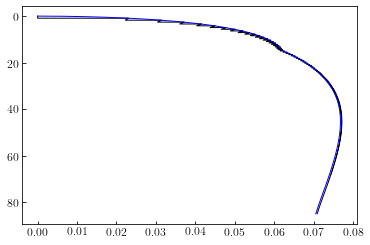

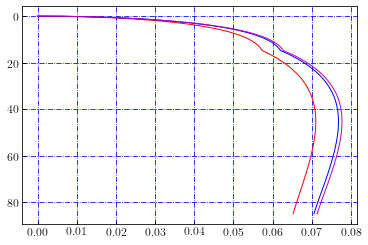

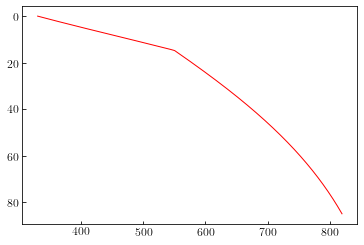

0.0 330.0 0.0
0.01 330.14489139932135 0.0
0.02 330.2898106198697 0.0
0.03 330.4347576355664 0.0
0.04 330.5797324203101 0.0
0.05 330.72473494797606 0.0
0.06 330.86976519241654 0.0
0.07 331.01482312746083 0.0
0.08 331.15990872691515 0.0
0.09 331.3050219645627 0.0
0.1 331.45016281416383 0.0
0.11 331.5953312494558 0.0
0.12 331.7405272441528 0.0
0.13 331.8857507719464 0.0
0.14 332.0310018065047 0.0
0.15 332.17628032147354 0.0
0.16 332.32158629047535 0.0
0.17 332.46691968710985 0.0
0.18 332.612280484954 0.0
0.19 332.7576686575617 0.0
0.2 332.90308417846404 0.0
0.21 333.0485270211695 0.0
0.22 333.19399715916353 0.0
0.23 333.3394945659088 0.0
0.24 333.48501921484547 0.0
0.25 333.63057107939056 0.0
0.26 333.77615013293837 0.0
0.27 333.9217563488609 0.0
0.28 334.06738970050696 0.0
0.29 334.21305016120283 0.0
0.3 334.35873770425223 0.0
0.31 334.50445230293604 0.0
0.32 334.65019393051244 0.0
0.33 334.7959625602172 0.0
0.34 334.9417581652633 0.0
0.35000000000000003 335.0875807188412 0.0
0.36 335.23

3.96 389.26309481775326 0.043730912039092365
3.97 389.4167446221926 0.043713657398208136
3.98 389.5704103050074 0.043696414587063505
3.99 389.72409183251403 0.043679183597548
4.0 389.87778917101423 0.04366196442155678
4.01 390.0315022867955 0.04364475705099051
4.0200000000000005 390.18523114613106 0.043627561477755414
4.03 390.33897571527973 0.04361037769376327
4.04 390.4927359604862 0.0435932056909314
4.05 390.6465118479805 0.04357604546118268
4.0600000000000005 390.8003033439789 0.043558896996445516
4.07 390.9541104146832 0.04354176028865383
4.08 391.10793302628116 0.0435246353297471
4.09 391.26177114494635 0.0435075221116703
4.1 391.4156247368382 0.04349042062637396
4.11 391.5694937681019 0.04347333086581413
4.12 391.72337820486894 0.04345625282195234
4.13 391.87727801325656 0.04343918648675564
4.14 392.03119315936794 0.04342213185219662
4.15 392.1851236092925 0.043405088910253346
4.16 392.33906932910537 0.04338805765290939
4.17 392.49303028486815 0.04337103807215382
4.18 392.647006

5.78 417.45501272135317 0.04971538893177429
5.79 417.6109846502278 0.04969682092137357
5.8 417.76696611903265 0.049678265641155364
5.8100000000000005 417.9229570919554 0.049659723082391895
5.82 418.07895753317496 0.04964119323636137
5.83 418.2349674068614 0.04962267609434796
5.84 418.3909866771758 0.04960417164764184
5.8500000000000005 418.54701530827106 0.049585679887539105
5.86 418.7030532642908 0.049567200805341875
5.87 418.85910050937025 0.049548734392358205
5.88 419.0151570076358 0.04953028063990213
5.89 419.1712227232057 0.04951183953929359
5.9 419.327297620189 0.04949341108185854
5.91 419.48338166268667 0.04947499525892884
5.92 419.639474814791 0.04945659206184228
5.93 419.7955770405857 0.049438201481942654
5.94 419.9516883041464 0.049419823510579615
5.95 420.10780856953977 0.04940145813910881
5.96 420.26393780082464 0.04938310535889176
5.97 420.42007596205104 0.04936476516129596
5.98 420.57622301726127 0.04934643753769475
5.99 420.7323789304886 0.04932812247946746
6.0 420.88854

7.58 445.64909201696577 0.05344156269380065
7.59 445.80619714947477 0.053422729524046204
7.6000000000000005 445.96330526506495 0.05340390926626688
7.61 446.12041632687095 0.053385101911610264
7.62 446.2775302980249 0.05336630745123
7.63 446.4346471416557 0.053347525876285815
7.640000000000001 446.5917668208901 0.05332875717794349
7.65 446.7488892988519 0.05331000134737484
7.66 446.9060145386625 0.05329125837575774
7.67 447.0631425034402 0.05327252825427616
7.68 447.2202731563014 0.05325381097412005
7.69 447.3774064603594 0.053235106526485436
7.7 447.5345423787254 0.05321641490257438
7.71 447.6916808745079 0.05319773609359497
7.72 447.8488219108131 0.0531790700907613
7.73 448.00596545074484 0.053160416885293535
7.74 448.16311145740445 0.05314177646841782
7.75 448.3202598938912 0.05312314883136631
7.76 448.4774107233018 0.05611928856525599
7.7700000000000005 448.63456390873074 0.056099630416572135
7.78 448.79171941327064 0.056079985745466916
7.79 448.94887720001145 0.056060354542700176
7

9.4 474.25486014570964 0.05818396610935546
9.41 474.41189978915514 0.058164706075414234
9.42 474.5689356948959 0.05814545924610518
9.43 474.72596782613454 0.05812622561237524
9.44 474.882996146077 0.058107005165177535
9.450000000000001 475.0400206179332 0.05808779789547142
9.46 475.19704120491616 0.058068603794222455
9.47 475.3540578702431 0.05804942285240235
9.48 475.5110705771344 0.058030255060989064
9.49 475.6680792888145 0.05801110041096669
9.5 475.82508396851165 0.0579919588933255
9.51 475.9820845794574 0.05797283049906201
9.52 476.13908108488755 0.05795371521917885
9.53 476.2960734480418 0.05793461304468482
9.540000000000001 476.45306163216344 0.057915523966594905
9.55 476.6100456004999 0.057896447975930236
9.56 476.7670253163025 0.05787738506371811
9.57 476.9240007428263 0.057858335220992
9.58 477.0809718433309 0.05783929843879146
9.59 477.2379385810797 0.05782027470816223
9.6 477.3949009193399 0.057801264020156215
9.61 477.5518588213835 0.05778226636583137
9.620000000000001 477

11.200000000000001 502.42680910942727 0.05914077700984923
11.21 502.5825879892636 0.05912244592513716
11.22 502.738356597451 0.05910412740817194
11.23 502.8941148983749 0.05908582145033717
11.24 503.04986285643037 0.0590675280430223
11.25 503.2056004360217 0.05904924717762276
11.26 503.3613276015633 0.059030978845539823
11.27 503.5170443174788 0.05901272303818068
11.28 503.6727505482017 0.060907023820862514
11.290000000000001 503.8284462581751 0.06088820201279156
11.3 503.98413141185216 0.060869393108906183
11.31 504.13980597369556 0.06085059710035931
11.32 504.29546990817795 0.06083181397830991
11.33 504.45112317978146 0.06081304373392307
11.34 504.60676575299857 0.06079428635836987
11.35 504.7623975923315 0.06077554184282748
11.36 504.91801866229235 0.0607568101784791
11.370000000000001 505.07362892740326 0.060738091356513986
11.38 505.2292283521965 0.06071938536812741
11.39 505.38481690121404 0.060700692204520734
11.4 505.5403945390081 0.06068201185690132
11.41 505.69596123014105 0.

14.76 552.5268654209317 0.06282549544247173
14.77 552.5812967246518 0.06281930689855238
14.780000000000001 552.6357252600807 0.06281311988834862
14.790000000000001 552.6901510257568 0.06280693441148046
14.8 552.7445740202207 0.06280075046756779
14.81 552.7989942420121 0.06279456805623075
14.82 552.8534116896712 0.06278838717708951
14.83 552.907826361739 0.06278220782976432
14.84 552.9622382567562 0.06277603001387556
14.85 553.016647373264 0.06276985372904373
14.86 553.0710537098045 0.06276367897488933
14.870000000000001 553.1254572649191 0.06275750575103303
14.88 553.1798580371504 0.06275133405709558
14.89 553.2342560250408 0.06274516389269783
14.9 553.2886512271334 0.06273899525746068
14.91 553.343043641971 0.0627328281510052
14.92 553.3974332680975 0.06272666257295248
14.93 553.4518201040569 0.0627204985229237
14.94 553.5062041483931 0.06271433600054023
14.950000000000001 553.5605853996506 0.06270817500542344
14.96 553.6149638563742 0.06270201553719484
14.97 553.6693395171092 0.06269

18.38 572.0388931757766 0.06733875023862447
18.39 572.0922295163214 0.06733247222551875
18.400000000000002 572.14556258173 0.06732619576830194
18.41 572.198892370666 0.06731992086658846
18.42 572.2522188817934 0.06731364751999279
18.43 572.3055421137763 0.06730737572812955
18.44 572.3588620652795 0.06730110549061337
18.45 572.4121787349679 0.06729483680705908
18.46 572.4654921215067 0.06728856967708159
18.47 572.5188022235621 0.06728230410029579
18.48 572.5721090397998 0.0672760400763168
18.490000000000002 572.6254125688862 0.0672697776047598
18.5 572.6787128094885 0.06726351668524001
18.51 572.7320097602736 0.06725725731737282
18.52 572.7853034199089 0.06725099950077369
18.53 572.8385937870628 0.06724474323505814
18.54 572.8918808604034 0.0672384885198418
18.55 572.9451646385992 0.06723223535474043
18.56 572.9984451203194 0.06722598373936986
18.57 573.0517223042331 0.06721973367334605
18.580000000000002 573.1049961890104 0.06721348515628496
18.59 573.1582667733215 0.06720723818780273


22.0 591.1224313511574 0.07055132006869264
22.01 591.1744977081623 0.07054510642072218
22.02 591.2265603309472 0.07053889431268894
22.03 591.2786192183145 0.07053268374421126
22.04 591.3306743690674 0.0705264747149076
22.05 591.3827257820092 0.07052026722439651
22.06 591.4347734559439 0.07132612879278284
22.07 591.4868173896756 0.07131985292625277
22.080000000000002 591.5388575820087 0.07131357861507967
22.09 591.5908940317489 0.07130730585887798
22.1 591.6429267377013 0.0713010346572624
22.11 591.6949556986716 0.07129476500984762
22.12 591.7469809134661 0.0712884969162485
22.13 591.7990023808917 0.07128223037607992
22.14 591.8510200997553 0.0712759653889569
22.150000000000002 591.9030340688643 0.07126970195449456
22.16 591.9550442870265 0.07126344007230809
22.17 592.0070507530505 0.07125717974201276
22.18 592.0590534657445 0.07125092096322404
22.19 592.111052423918 0.07124466373555734
22.2 592.16304762638 0.07123840805862829
22.21 592.215039071941 0.07123215393205252
22.22 592.2670267

25.6 609.6160613261866 0.07351377991602662
25.61 609.6667091378523 0.07350767278892878
25.62 609.7173528107606 0.07350156717536897
25.63 609.7679923438637 0.07349546307497203
25.64 609.8186277361137 0.07348936048736297
25.650000000000002 609.8692589864631 0.07348325941216688
25.66 609.9198860938653 0.07347715984900893
25.67 609.9705090572736 0.07347106179751439
25.68 610.0211278756419 0.07346496525730864
25.69 610.0717425479246 0.07345887022801711
25.7 610.1223530730766 0.07345277670926537
25.71 610.1729594500531 0.07344668470067904
25.72 610.2235616778097 0.07344059420188385
25.73 610.2741597553024 0.07343450521250565
25.740000000000002 610.324753681488 0.07342841773217033
25.75 610.3753434553231 0.07342233176050393
25.76 610.4259290757651 0.07341624729713254
25.77 610.4765105417717 0.07341016434168239
25.78 610.5270878523015 0.0734040828937797
25.79 610.5776610063127 0.07339800295305092
25.8 610.6282300027646 0.07339192451912249
25.810000000000002 610.6787948406165 0.0733858475916209

29.18 627.4758390603888 0.07501132904463094
29.19 627.5249414736322 0.07500545957708749
29.2 627.5740394004071 0.0755473826184939
29.21 627.6231328398201 0.07554147321098909
29.22 627.6722217909785 0.07553556526802117
29.23 627.7213062529904 0.07552965878922714
29.240000000000002 627.7703862249639 0.07552375377424414
29.25 627.8194617060074 0.07551785022270942
29.26 627.8685326952301 0.07551194813426028
29.27 627.9175991917417 0.07550604750853408
29.28 627.966661194652 0.07550014834516838
29.29 628.0157187030715 0.0754942506438007
29.3 628.0647717161108 0.07548835440406876
29.310000000000002 628.1138202328815 0.07548245962561029
29.32 628.1628642524951 0.07547656630806315
29.330000000000002 628.2119037740639 0.07547067445106526
29.34 628.2609387967003 0.07546478405425469
29.35 628.3099693195176 0.07545889511726954
29.36 628.358995341629 0.07545300763974801
29.37 628.4080168621484 0.07544712162132843
29.38 628.4570338801905 0.07544123706164915
29.39 628.5060463948698 0.07543535396034866

32.76 644.7613277907633 0.0764643961786723
32.77 644.8087703148983 0.07645877022547784
32.78 644.8562080609902 0.07645314566657134
32.79 644.9036410283038 0.07644752250160729
32.8 644.9510692161042 0.07644190073024021
32.81 644.9984926236574 0.07643628035212471
32.82 645.0459112502292 0.07643066136691554
32.83 645.0933250950865 0.07642504377426744
32.84 645.140734157496 0.07641942757383532
32.85 645.1881384367256 0.07641381276527413
32.86 645.2355379320428 0.07640819934823895
32.87 645.2829326427159 0.07640258732238492
32.88 645.3303225680139 0.07684339386609663
32.89 645.3777077072062 0.07683775184457826
32.9 645.4250880595621 0.07683211122133016
32.910000000000004 645.4724636243519 0.07682647199600572
32.92 645.5198344008462 0.07682083416825848
32.93 645.5672003883159 0.07681519773774213
32.94 645.6145615860323 0.07680956270411039
32.95 645.6619179932676 0.07680392906701702
32.96 645.7092696092938 0.07679829682611597
32.97 645.7566164333838 0.07679266598106119
32.980000000000004 645.

36.4 661.7091966991197 0.0773422800141627
36.410000000000004 661.754854957296 0.07733694372722445
36.42 661.8005081988975 0.07733160876278583
36.43 661.8461564233495 0.07732627512051901
36.44 661.8917996300767 0.07732094280009633
36.45 661.9374378185046 0.0773156118011902
36.46 661.983070988059 0.07731028212347313
36.47 662.0286991381664 0.07767194344937184
36.480000000000004 662.0743222682534 0.07766659112401966
36.49 662.1199403777472 0.0776612401251419
36.5 662.1655534660756 0.07765589045240978
36.51 662.2111615326666 0.07765054210549469
36.52 662.2567645769486 0.07764519508406799
36.53 662.3023625983508 0.07763984938780122
36.54 662.3479555963021 0.07763450501636597
36.550000000000004 662.3935435702327 0.0776291619694339
36.56 662.4391265195728 0.07762382024667673
36.57 662.484704443753 0.0776184798477663
36.58 662.5302773422043 0.07761314077237456
36.59 662.5758452143584 0.07760780302017345
36.6 662.6214080596473 0.07760246659083506
36.61 662.6669658775033 0.07759713148403154
36.6

40.02 677.9054905197453 0.07812179519190161
40.03 677.9492985627052 0.07811674708142032
40.04 677.9931014088994 0.0781117002220194
40.050000000000004 678.0368990579074 0.07810665461338881
40.06 678.0806915093086 0.07810161025521861
40.07 678.1244787626836 0.07809656714719886
40.08 678.1682608176127 0.07809152528901975
40.09 678.2120376736772 0.07808648468037152
40.1 678.2558093304585 0.07808144532094448
40.11 678.2995757875383 0.07807640721042909
40.12 678.343337044499 0.07807137034851579
40.13 678.3870931009236 0.07806633473489509
40.14 678.4308439563947 0.07806130036925772
40.15 678.4745896104962 0.07805626725129435
40.160000000000004 678.518330062812 0.07805123538069575
40.17 678.5620653129265 0.07804620475715279
40.18 678.6057953604244 0.07804117538035643
40.19 678.6495202048911 0.07803614724999766
40.2 678.6932398459121 0.07803112036576759
40.21 678.7369542830736 0.0780260947273574
40.22 678.7806635159619 0.0780210703344583
40.230000000000004 678.8243675441639 0.07801604718676168


43.64 693.4214340572727 0.07823287959552166
43.65 693.4633366315451 0.07822815236788809
43.660000000000004 693.5052338837048 0.07822342631181006
43.67 693.5471258134787 0.07821870142699724
43.68 693.5890124205946 0.07821397771315934
43.69 693.6308937047802 0.07820925517000618
43.7 693.6727696657642 0.07820453379724757
43.71 693.714640303275 0.0781998135945935
43.72 693.756505617042 0.07819509456175396
43.730000000000004 693.7983656067943 0.07819037669843905
43.74 693.8402202722621 0.07818566000435892
43.75 693.8820696131758 0.07818094447922379
43.76 693.923913629266 0.07817623012274393
43.77 693.9657523202638 0.07817151693462976
43.78 694.0075856859007 0.0781668049145917
43.79 694.0494137259085 0.07816209406234029
43.800000000000004 694.0912364400194 0.07815738437758608
43.81 694.1330538279665 0.07815267586003974
43.82 694.1748658894826 0.078147968509412
43.83 694.2166726243013 0.07814326232541365
43.84 694.2584740321563 0.07813855730775558
43.85 694.300270112782 0.07813385345614873
43

47.26 708.2405494533848 0.07830705084761062
47.27 708.2805106486971 0.07830263276281765
47.28 708.3204664484244 0.07829821577296492
47.29 708.360416852432 0.07829379987778108
47.300000000000004 708.4003618605863 0.07828938507699479
47.31 708.4403014727533 0.07828497137033487
47.32 708.4802356887996 0.07828055875753018
47.33 708.5201645085926 0.07827614723830954
47.34 708.5600879319993 0.07827173681240204
47.35 708.6000059588881 0.07826732747953662
47.36 708.6399185891265 0.07826291923944247
47.37 708.6798258225836 0.07825851209184871
47.38 708.7197276591281 0.0782541060364846
47.39 708.7596240986292 0.07824970107307945
47.4 708.7995151409564 0.07824529720136267
47.410000000000004 708.8394007859799 0.07824089442106368
47.42 708.8792810335701 0.07823649273191197
47.43 708.9191558835977 0.07823209213363716
47.44 708.9590253359336 0.07822769262596888
47.45 708.9988893904496 0.07822329420863683
47.46 709.0387480470172 0.0782188968813708
47.47 709.0786013055088 0.07821450064390066
47.4800000

50.84 722.2010874108881 0.0779898571009883
50.85 722.2391111275026 0.07798575116961526
50.86 722.277129423247 0.07798164625582105
50.870000000000005 722.3151422981127 0.07797754235935347
50.88 722.3531497520922 0.07797343947996038
50.89 722.3911517851773 0.07796933761738974
50.9 722.4291483973608 0.07796523677138952
50.910000000000004 722.4671395886355 0.07796113694170778
50.92 722.5051253589947 0.07795703812809267
50.93 722.5431057084319 0.07795294033029238
50.94 722.581080636941 0.07794884354805513
50.95 722.6190501445163 0.07809766063426148
50.96 722.6570142311525 0.07809355784926664
50.97 722.6949728968443 0.07808945608107086
50.980000000000004 722.7329261415871 0.07808535532942211
50.99 722.7708739653766 0.07808125559406846
51.0 722.8088163682085 0.07807715687475808
51.01 722.8467533500791 0.07807305917123912
51.02 722.8846849109851 0.07806896248325985
51.03 722.9226110509234 0.0780648668105686
51.04 722.9605317698911 0.07806077215291374
51.050000000000004 722.9984470678861 0.0780

54.42 735.4673253355132 0.07766627549659323
54.43 735.5034103206465 0.07766246506368793
54.44 735.539489902593 0.07765865557512762
54.45 735.5755640814581 0.0776548470306783
54.46 735.6116328573477 0.07765103943010596
54.47 735.6476962303677 0.07764723277317667
54.480000000000004 735.6837542006245 0.0776434270596566
54.49 735.7198067682249 0.07763962228931191
54.5 735.7558539332757 0.07763581846190887
54.51 735.7918956958839 0.0776320155772138
54.52 735.8279320561574 0.07762821363499305
54.53 735.8639630142039 0.07762441263501302
54.54 735.8999885701317 0.07762061257704024
54.550000000000004 735.936008724049 0.07761681346084123
54.56 735.9720234760645 0.0776130152861826
54.57 736.0080328262875 0.07760921805283098
54.58 736.0440367748272 0.07760542176055311
54.59 736.0800353217933 0.07760162640911575
54.6 736.1160284672956 0.07759783199828575
54.61 736.1520162114444 0.07759403852782996
54.620000000000005 736.1879985543503 0.07770851448993107
54.63 736.223975496124 0.07770471712011676
54

58.0 748.04146704292 0.07719207311508015
58.01 748.0756266344142 0.07718854827134734
58.02 748.1097808788919 0.07718502430118158
58.03 748.1439297765594 0.07718150120436636
58.04 748.1780733276236 0.07717797898068522
58.050000000000004 748.2122115322912 0.0771744576299218
58.06 748.24634439077 0.07717093715185971
58.07 748.2804719032667 0.07716741754628277
58.08 748.31459406999 0.07716389881297464
58.09 748.3487108911473 0.07716038095171919
58.1 748.382822366947 0.07715686396230031
58.11 748.4169284975978 0.07715334784450194
58.120000000000005 748.4510292833087 0.07714983259810801
58.13 748.4851247242884 0.0771463182229026
58.14 748.5192148207465 0.0771428047186698
58.15 748.5532995728925 0.07713929208519377
58.160000000000004 748.5873789809364 0.07713578032225865
58.17 748.6214530450883 0.07713226942964876
58.18 748.6555217655587 0.07712875940714836
58.19 748.6895851425579 0.07712525025454185
58.2 748.7236431762973 0.0771217419716136
58.21 748.7576958669877 0.07711823455814813
58.22 7

59.800000000000004 754.1042614267561 0.07690789843232403
59.81 754.1374621291442 0.07690451258242878
59.82 754.1706575258298 0.07690112757165356
59.83 754.2038476170653 0.07689774339979036
59.84 754.2370324031033 0.0768943600666313
59.85 754.2702118841967 0.07689097757196849
59.86 754.3033860605981 0.07688759591559416
59.870000000000005 754.3365549325612 0.07688421509730052
59.88 754.3697185003392 0.0768808351168799
59.89 754.4028767641862 0.07687745597412463
59.9 754.4360297243558 0.0768740776688271
59.910000000000004 754.4691773811026 0.0768707002007798
59.92 754.5023197346807 0.0768673235697752
59.93 754.5354567853452 0.07686394777560586
59.94 754.5685885333509 0.0768605728180644
59.95 754.6017149789529 0.07685719869694346
59.96 754.6348361224071 0.07685382541203574
59.97 754.6679519639688 0.07685045296313404
59.980000000000004 754.7010625038939 0.07684708135003115
59.99 754.7341677424389 0.07684371057251993
60.0 754.7672676798602 0.07684034063039329
60.01 754.8003623164144 0.076914

61.59 759.962909133729 0.0766038153638398
61.6 759.9951643608099 0.07660056419386438
61.61 760.0274143311581 0.07659731382963103
61.620000000000005 760.0596590450677 0.07659406427094011
61.63 760.0918985028339 0.07659081551759189
61.64 760.1241327047514 0.07658756756938687
61.65 760.1563616511157 0.07658432042612544
61.660000000000004 760.188585342222 0.07658107408760814
61.67 760.220803778366 0.07657782855363557
61.68 760.2530169598436 0.07657458382400828
61.690000000000005 760.2852248869511 0.07657133989852695
61.7 760.3174275599848 0.07656809677699228
61.71 760.3496249792411 0.07656485445920505
61.72 760.3818171450171 0.07656161294496604
61.730000000000004 760.4140040576098 0.07655837223407609
61.74 760.4461857173161 0.07655513232633616
61.75 760.4783621244338 0.07655189322154717
61.76 760.5105332792608 0.0765486549195101
61.77 760.5426991820945 0.07661140813758904
61.78 760.5748598332336 0.07660816865006385
61.79 760.607015232976 0.07660492996538552
61.800000000000004 760.639165381

65.17 771.1767408505985 0.07593966055140461
65.18 771.2071346415881 0.07593666771839394
65.19 771.2375232950191 0.07593367562710131
65.2 771.2679068112604 0.07593068427734292
65.21000000000001 771.2982851906818 0.07592769366893502
65.22 771.3286584336528 0.07592470380169383
65.23 771.3590265405431 0.07592171467543572
65.24 771.389389511723 0.075918726289977
65.25 771.4197473475626 0.07591573864513412
65.26 771.4501000484327 0.0759127517407235
65.27 771.4804476147034 0.07595617274565665
65.28 771.5107900467456 0.07595318549643154
65.29 771.5411273449304 0.07595019898754067
65.3 771.571459509629 0.07594721321880055
65.31 771.6017865412128 0.07594422819002772
65.32000000000001 771.6321084400532 0.07594124390103882
65.33 771.662425206522 0.07593826035165052
65.34 771.6927368409914 0.0759352775416795
65.35 771.7230433438332 0.07593229547094252
65.36 771.7533447154199 0.07592931413925637
65.37 771.7836409561238 0.07592633354643791
65.38 771.813932066318 0.07592335369230396
65.39 771.84421804

67.01 776.6830882793435 0.07560935637120798
67.02 776.7125431669356 0.07560648907478999
67.03 776.7419929880265 0.07560362248897814
67.04 776.771437743019 0.07560075661359632
67.05 776.8008774323155 0.0755978914484685
67.06 776.8303120563195 0.0755950269934186
67.07000000000001 776.859741615434 0.07559216324827067
67.08 776.8891661100625 0.07558930021284878
67.09 776.9185855406085 0.07558643788697704
67.1 776.9479999074757 0.0755835762704796
67.11 776.9774092110684 0.0755807153631806
67.12 777.0068134517901 0.07557785516490438
67.13 777.0362126300454 0.07557499567547514
67.14 777.0656067462388 0.07557213689471723
67.15 777.0949958007749 0.07556927882245501
67.16 777.1243797940581 0.07556642145851293
67.17 777.1537587264938 0.07556356480271541
67.18 777.1831325984868 0.07556070885488694
67.19 777.2125014104427 0.07555785361485212
67.2 777.2418651627668 0.07555499908243545
67.21000000000001 777.2712238558646 0.07555214525746164
67.22 777.3005774901419 0.07554929213975534
67.23 777.329926

70.65 787.0732735218546 0.07484160120035034
70.66 787.100912115808 0.07483897318074757
70.67 787.1285458004908 0.07483634581245062
70.68 787.1561745763619 0.07483371909529811
70.69 787.1837984438808 0.07483109302912866
70.7 787.2114174035074 0.0748284676137809
70.71000000000001 787.239031455701 0.07482584284909356
70.72 787.2666406009216 0.07482321873490538
70.73 787.2942448396291 0.07482059527105518
70.74 787.3218441722836 0.07481797245738173
70.75 787.3494385993453 0.07481535029372394
70.76 787.3770281212747 0.07481272877992068
70.77 787.4046127385321 0.07481010791581094
70.78 787.4321924515783 0.07480748770123366
70.79 787.4597672608743 0.0748048681360279
70.8 787.4873371668805 0.07480224922003269
70.81 787.5149021700582 0.07479963095308718
70.82000000000001 787.542462270869 0.07479701333503046
70.83 787.5700174697735 0.07479439636570177
70.84 787.5975677672336 0.0747917800449403
70.85000000000001 787.625113163711 0.07480988044344077
70.86 787.6526536596673 0.07480726469498837
70.87

74.27 796.7613617949755 0.07406598347152075
74.28 796.7872542637183 0.07406357661680303
74.29 796.8131419977856 0.07406117035857954
74.3 796.8390249976806 0.07405876469670244
74.31 796.8649032639071 0.07405635963102396
74.32000000000001 796.8907767969689 0.07405395516139633
74.33 796.9166455973699 0.07405155128767181
74.34 796.9425096656141 0.07404914800970275
74.35000000000001 796.9683690022056 0.07404674532734147
74.36 796.9942236076483 0.0740443432404404
74.37 797.0200734824471 0.07404194174885191
74.38 797.0459186271058 0.07403954085242852
74.39 797.0717590421292 0.0740371405510227
74.4 797.0975947280219 0.074034740844487
74.41 797.1234256852885 0.07403234173267398
74.42 797.1492519144341 0.07402994321543623
74.43 797.1750734159633 0.07402754529262642
74.44 797.2008901903812 0.07402514796409726
74.45 797.2267022381932 0.07402275122970142
74.46000000000001 797.2525095599042 0.07402035508929168
74.47 797.2783121560198 0.07401795954272083
74.48 797.3041100270453 0.0740155645898417
74.

76.09 801.3963084891883 0.07366212242217232
76.10000000000001 801.4213476426835 0.07365982096464871
76.11 801.446382154824 0.0736575200774986
76.12 801.4714120261315 0.0736552197605806
76.13 801.4964372571274 0.07365292001375345
76.14 801.5214578483337 0.07365062083687582
76.15 801.5464738002723 0.07364832222980644
76.16 801.5714851134651 0.07364602419240414
76.17 801.5964917884342 0.07364372672452771
76.18 801.6214938257016 0.07364142982603601
76.19 801.6464912257896 0.07363913349678794
76.2 801.6714839892207 0.0736368377366424
76.21000000000001 801.6964721165172 0.07363454254545837
76.22 801.7214556082015 0.07363224792309483
76.23 801.7464344647964 0.07362995386941082
76.24 801.7714086868244 0.0736276603842654
76.25 801.7963782748085 0.07362536746751765
76.26 801.8213432292713 0.07362307511902674
76.27 801.846303550736 0.07362078333865181
76.28 801.8712592397256 0.07361849212625206
76.29 801.8962102967632 0.07361620148168674
76.3 801.9211567223721 0.07361391140481513
76.31 801.946098

77.91 805.8775060762084 0.0732582995864187
77.92 805.9017091814923 0.07325609946906245
77.93 805.925907741784 0.07325389989696442
77.94 805.9501017576209 0.07325170086998949
77.95 805.9742912295402 0.0732495023880025
77.96000000000001 805.9984761580783 0.0732473044508685
77.97 806.0226565437735 0.07324510705845232
77.98 806.0468323871625 0.07324291021061904
77.99 806.0710036887824 0.07324118586386723
78.0 806.0951704491712 0.07323899009064559
78.01 806.119332668866 0.07323679486160557
78.02 806.1434903484048 0.07323460017661228
78.03 806.167643488325 0.0732324060355309
78.04 806.1917920891646 0.07323021243822658
78.05 806.215936151461 0.07322801938456464
78.06 806.2400756757527 0.07322582687441029
78.07000000000001 806.2642106625774 0.07322363490762884
78.08 806.2883411124727 0.07322144348408567
78.09 806.3124670259776 0.07321925260364609
78.10000000000001 806.3365884036298 0.07321706226617554
78.11 806.3607052459677 0.07321487247153943
78.12 806.3848175535296 0.07321268321960324
78.13

81.54 814.3689105584663 0.07249490425679213
81.55 814.3914996728455 0.07249289343560253
81.56 814.4140844416634 0.0724908831127576
81.57000000000001 814.43666486548 0.07248887328813386
81.58 814.4592409448558 0.07248686396160782
81.59 814.4818126803514 0.072484855133056
81.60000000000001 814.5043800725269 0.07248284680235502
81.61 814.526943121943 0.07248083896938151
81.62 814.5495018291601 0.07247883163401209
81.63 814.5720561947388 0.07247682479612345
81.64 814.5946062192398 0.07247481845559232
81.65 814.6171519032238 0.0724728126122954
81.66 814.6396932472516 0.0724708072661095
81.67 814.662230251884 0.07246880241691135
81.68 814.6847629176817 0.07246679806457784
81.69 814.7072912452056 0.07246479420898584
81.7 814.7298152350168 0.07246279085001223
81.71000000000001 814.752334887676 0.07246032105968235
81.72 814.7748502037449 0.07245831870647924
81.73 814.7973611837837 0.07245631684952224
81.74 814.8198678283543 0.07245431548868825
81.75 814.8423701380175 0.07245231462385436
81.76 8

85.17 822.2877055422898 0.07179630118773626
85.18 822.3087543889847 0.07179446339952243
85.19 822.329799096354 0.07179262606677024
85.2 822.3508396649722 0.07179078918936685
85.21000000000001 822.3718760954143 0.07178895276719938
85.22 822.3929083882547 0.07178711680015504
85.23 822.4139365440681 0.07178528128812102
85.24 822.4349605634293 0.07178344623098457
85.25 822.4559804469131 0.07178161162863292
85.26 822.4769961950946 0.07177977748095339
85.27 822.4980078085481 0.0717779437878333
85.28 822.5190152878489 0.07177611054915997
85.29 822.5400186335717 0.07177427776482079
85.3 822.5610178462913 0.07177244543470317
85.31 822.5820129265829 0.07177061355869452
85.32000000000001 822.6030038750215 0.0717687821366823
85.33 822.6239906921819 0.071766951168554
85.34 822.6449733786392 0.07176512065419714
85.35000000000001 822.6659519349685 0.07176329059349926
85.36 822.6869263617448 0.07176146098634793
85.37 822.7078966595433 0.07175963183263073
85.38 822.7288628289391 0.07175780313223531
85.

88.8 829.6610311529328 0.07115869491737238
88.81 829.6806153620125 0.07115701525084371
88.82000000000001 829.7001956417613 0.07115533600058921
88.83 829.7197719927605 0.07115365716650565
88.84 829.7393444155911 0.07115197874848996
88.85000000000001 829.7589129108343 0.07115030074643898
88.86 829.7784774790712 0.07114862316024964
88.87 829.7980381208831 0.07114694598981885
88.88 829.8175948368512 0.07114526923504362
88.89 829.8371476275565 0.07114359289582091
88.9 829.8566964935807 0.07114191697204772
88.91 829.8762414355045 0.0711402414636211
88.92 829.8957824539095 0.07113856637043812
88.93 829.9153195493766 0.07113689169239588
88.94 829.9348527224871 0.07113521742939148
88.95 829.9543819738228 0.07113354358132204
88.96000000000001 829.9739073039642 0.07113187014808475
88.97 829.993428713493 0.07113019712957681
88.98 830.0129462029903 0.07112852452569544
88.99 830.0324597730374 0.07112685233633785
89.0 830.0519694242157 0.07112518056140134
89.01 830.0714751571065 0.07112350920078317
8

90.61 833.1423293370218 0.07086135720366489
90.62 833.1612118099679 0.07085975122676469
90.63 833.1800904588557 0.07085814564787603
90.64 833.1989652842675 0.07085608387661015
90.65 833.2178362867849 0.07085447910378967
90.66 833.2367034669894 0.07085287472868235
90.67 833.2555668254635 0.07085127075118956
90.68 833.2744263627883 0.07084966717121283
90.69 833.2932820795462 0.07084806398865356
90.7 833.3121339763186 0.07084646120341334
90.71000000000001 833.3309820536875 0.07084485881539365
90.72 833.3498263122348 0.07084325682449606
90.73 833.3686667525419 0.07084165523062216
90.74 833.387503375191 0.07084005403367356
90.75 833.4063361807638 0.07083845323355185
90.76 833.4251651698421 0.07083685283015873
90.77 833.4439903430074 0.07083525282339587
90.78 833.4628117008422 0.07083365321316493
90.79 833.4816292439275 0.07083205399936769
90.8 833.5004429728457 0.07083045518190587
90.81 833.5192528881781 0.07082885676068126
90.82000000000001 833.538058990507 0.07082725873559567
90.83 833.55

94.25 839.767544515175 0.07030230756861226
94.26 839.7850734298612 0.07030084014177818
94.27 839.8025987318554 0.07029937307861858
94.28 839.8201204217362 0.07029790637904335
94.29 839.8376385000824 0.07029644004296233
94.3 839.8551529674723 0.0702949740702855
94.31 839.8726638244846 0.07029350846092274
94.32000000000001 839.8901710716976 0.07029204321478402
94.33 839.9076747096899 0.07029057833177937
94.34 839.9251747390399 0.07028911381181875
94.35000000000001 839.9426711603263 0.07028764965481217
94.36 839.9601639741272 0.07028618586066972
94.37 839.9776531810212 0.07028472242930146
94.38 839.9951387815867 0.07028325936061747
94.39 840.012620776402 0.07028179665452788
94.4 840.0300991660455 0.07028033431094281
94.41 840.0475739510957 0.07027887232977244
94.42 840.0650451321308 0.07027741071092693
94.43 840.0825127097291 0.07027594945431649
94.44 840.0999766844687 0.0702744885598514
94.45 840.1174370569286 0.07027302802744181
94.46000000000001 840.1348938276864 0.07027156785699806
94

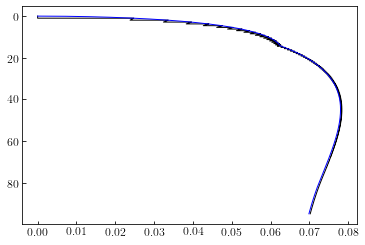

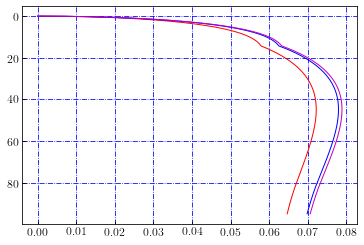

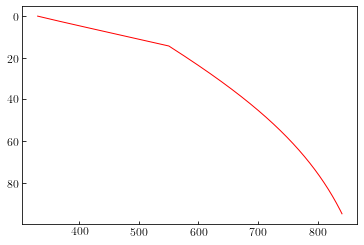

0.0 330.0 0.0
0.01 330.13885447314794 0.0
0.02 330.27773449866925 0.0
0.03 330.4166400536123 0.0
0.04 330.55557111500565 0.0
0.05 330.6945276598589 0.0
0.06 330.83350966516184 0.0
0.07 330.97251710788487 0.0
0.08 331.1115499649791 0.0
0.09 331.25060821337615 0.0
0.1 331.3896918299881 0.0
0.11 331.528800791708 0.0
0.12 331.6679350754093 0.0
0.13 331.80709465794587 0.0
0.14 331.94627951615263 0.0
0.15 332.08548962684506 0.0
0.16 332.2247249668192 0.0
0.17 332.36398551285185 0.0
0.18 332.50327124170036 0.0
0.19 332.6425821301031 0.0
0.2 332.78191815477885 0.0
0.21 332.9212792924275 0.0
0.22 333.06066551972924 0.0
0.23 333.2000768133453 0.0
0.24 333.33951314991754 0.0
0.25 333.47897450606894 0.0
0.26 333.6184608584027 0.0
0.27 333.7579721835035 0.0
0.28 333.8975084579362 0.0
0.29 334.03706965824716 0.0
0.3 334.17665576096283 0.0
0.31 334.31626674259127 0.0
0.32 334.4559025796209 0.0
0.33 334.5955632485212 0.0
0.34 334.7352487257425 0.0
0.35000000000000003 334.8749589877164 0.0
0.36 335.014

3.8200000000000003 384.674224438627 0.04854288968908848
3.83 384.82100258403045 0.04852437449560048
3.84 384.9677962327953 0.04850587146740969
3.85 385.114605355666 0.048487380596523
3.86 385.26142992337435 0.048468901874952536
3.87 385.4082699066396 0.04845043529471561
3.88 385.55512527616764 0.04843198084783489
3.89 385.7019960026519 0.04841353852633821
3.9 385.8488820567732 0.04839510832225863
3.91 385.99578340919925 0.0483766902276345
3.92 386.1427000305853 0.048358284234509365
3.93 386.2896318915738 0.048339890334932016
3.94 386.43657896279444 0.04832150852095646
3.95 386.5835412148645 0.0483031387846419
3.96 386.7305186183884 0.048284781118052816
3.97 386.87751114395803 0.04826643551325885
3.98 387.0245187621527 0.04824810196233489
3.99 387.17154144353924 0.048229780457360975
4.0 387.3185791586719 0.048211470990422396
4.01 387.46563187809227 0.048193173553609664
4.0200000000000005 387.6126995723295 0.048174888139018435
4.03 387.7597822119005 0.05196114238015437
4.04 387.906879767

7.43 438.4332766349576 0.062040160993733724
7.44 438.58366702482937 0.06201888741539269
7.45 438.7340617084189 0.061997627814729145
7.46 438.88446065342407 0.06197638218255918
7.47 439.0348638275392 0.06195515050970485
7.48 439.185271198455 0.06193393278699428
7.49 439.33568273385833 0.06191272900526162
7.5 439.48609840143274 0.06189153915534701
7.51 439.63651816885806 0.061870363228096664
7.5200000000000005 439.7869420038107 0.06405249214221927
7.53 439.93736987396323 0.064030590661166
7.54 440.0878017469854 0.06400870357034995
7.55 440.23823759054284 0.0639868308603161
7.5600000000000005 440.3886773722981 0.06396497252161568
7.57 440.53912105991014 0.06394312854480608
7.58 440.6895686210349 0.06392129892045087
7.59 440.84002002332466 0.0638994836391199
7.6000000000000005 440.99047523442846 0.06387768269138913
7.61 441.14093422199215 0.06385589606784078
7.62 441.2913969536581 0.06383412375906326
7.63 441.4418633970658 0.06381236575565108
7.640000000000001 441.5923335198513 0.063790622

9.26 465.9936454516019 0.06615566509211968
9.27 466.1442812366863 0.06613428671003913
9.28 466.2949153711009 0.06611292237449674
9.290000000000001 466.44554782233683 0.06609157207626336
9.3 466.59617855788696 0.06607023580611585
9.31 466.74680754524564 0.06604891355483711
9.32 466.89743475190886 0.06602760531321615
9.33 467.0480601453739 0.06600631107204799
9.34 467.1986836931397 0.06772711732302701
9.35 467.3493053627067 0.06770528959937556
9.36 467.4999251215773 0.06768347621749947
9.370000000000001 467.65054293725524 0.06766167716797555
9.38 467.80115877724586 0.06763989244138688
9.39 467.9517726090564 0.06761812202832262
9.4 468.102384400196 0.06759636591937815
9.41 468.2529941181752 0.06757462410515502
9.42 468.4036017305065 0.067552896576261
9.43 468.55420720470414 0.06753118332331
9.44 468.7048105082844 0.06750948433692207
9.450000000000001 468.8554116087654 0.06748779960772346
9.46 469.00601047366666 0.06746612912634659
9.47 469.15660707051046 0.06744447288342997
9.48 469.30720

11.07 493.2003413944647 0.07014376410541334
11.08 493.3501514627871 0.07012246434081032
11.09 493.4999540471288 0.07010117857109034
11.1 493.6497491156966 0.07007990678705815
11.11 493.7995366367034 0.07005864897952452
11.120000000000001 493.94931657836867 0.07003740513930627
11.13 494.09908890891813 0.07001617525722631
11.14 494.2488535965847 0.06999495932411347
11.15 494.39861060960715 0.06997375733080269
11.16 494.548359916231 0.0699525692681349
11.17 494.69810148470856 0.06993139512695706
11.18 494.8478352832986 0.06991023489812215
11.19 494.99756128026667 0.0698890885724891
11.200000000000001 495.14727944388466 0.06986795614092296
11.21 495.2969897424317 0.06984683759429466
11.22 495.44669214419326 0.06982573292348121
11.23 495.5963866174616 0.0698046421193656
11.24 495.7460731305358 0.06978356517283679
11.25 495.89575165172175 0.06976250207478975
11.26 496.0454221493324 0.06974145281612537
11.27 496.1950845916873 0.06972041738775062
11.28 496.3447389471129 0.06969939578057835
11.

14.65 546.11856901746 0.0729718698307603
14.66 546.2637342428807 0.07295247813903831
14.67 546.4088812063072 0.07293309918851146
14.68 546.5540098798405 0.07291373297080826
14.69 546.6991202355963 0.07289437947756261
14.700000000000001 546.8442122457049 0.07287503870041406
14.71 546.9892858823121 0.07285571063100753
14.72 547.1343411175783 0.0728363952609935
14.73 547.279377923679 0.07281709258202793
14.74 547.4243962728049 0.0727978025857722
14.75 547.5693961371618 0.07277852526389321
14.76 547.7143774889702 0.07275926060806338
14.77 547.8593403004662 0.07274000860996048
14.780000000000001 548.0042845439003 0.07272076926126791
14.790000000000001 548.1492101915388 0.07270154255367442
14.8 548.294117215663 0.07268232847887421
14.81 548.4390055885689 0.07266312702856706
14.82 548.5838752825682 0.07264393819445808
14.83 548.7287262699879 0.07262476196825784
14.84 548.8735585231695 0.07260559834168244
14.85 549.0183720144709 0.07258644730645333
14.86 549.1631667162638 0.07256730885429749
1

16.45 559.6900368338564 0.0745755373689086
16.46 559.7529799720288 0.07456715149420878
16.47 559.8159190983769 0.07455876803956021
16.48 559.8788542106632 0.07455038700426443
16.490000000000002 559.9417853066506 0.07454200838762326
16.5 560.0047123841019 0.0753325267988362
16.51 560.0676354407817 0.07532406326237447
16.52 560.1305544744547 0.07531560216837604
16.53 560.1934694828859 0.07530714351613613
16.54 560.2563804638411 0.07529868730495008
16.55 560.3192874150873 0.07529023353411338
16.56 560.3821903343912 0.07528178220292181
16.57 560.4450892195206 0.07527333331067135
16.580000000000002 560.5079840682444 0.07526488685665807
16.59 560.5708748783309 0.07525644284017842
16.6 560.6337616475502 0.07524800126052891
16.61 560.6966443736725 0.07523956211700629
16.62 560.7595230544687 0.07523112540890754
16.63 560.8223976877099 0.0752226911355299
16.64 560.8852682711688 0.07521425929617064
16.65 560.9481348026178 0.07520582989012739
16.66 561.0109972798306 0.07519740291669788
16.67 561.0

18.27 571.0774255285687 0.07684846595113629
18.28 571.1396022804321 0.07684009989145586
18.29 571.2017746236694 0.07683173624610833
18.3 571.2639425561601 0.0768233750143969
18.31 571.3261060757848 0.076815016195625
18.32 571.3882651804237 0.07751349318981901
18.330000000000002 571.4504198679585 0.07750506231501089
18.34 571.5125701362712 0.07749663387324046
18.35 571.5747159832448 0.0774882078638055
18.36 571.6368574067628 0.07747978428600409
18.37 571.6989944047094 0.07747136313913451
18.38 571.7611269749692 0.07746294442249521
18.39 571.8232551154279 0.07745452813538488
18.400000000000002 571.8853788239715 0.07744611427710237
18.41 571.947498098487 0.07743770284694673
18.42 572.0096129368618 0.07742929384421729
18.43 572.0717233369842 0.07742088726821349
18.44 572.1338292967431 0.077412483118235
18.45 572.1959308140276 0.07740408139358176
18.46 572.2580278867284 0.07739568209355378
18.47 572.3201205127361 0.0773872852174514
18.48 572.3822086899423 0.07737889076457509
18.490000000000

21.89 593.2812009352635 0.08079298791607775
21.900000000000002 593.3416486109137 0.08078475699492164
21.91 593.4020911557678 0.0807765284490992
21.92 593.4625285679618 0.080768302277925
21.93 593.5229608456327 0.08076007848071368
21.94 593.5833879869175 0.08075185705678016
21.95 593.6438099899543 0.08074363800543961
21.96 593.7042268528825 0.08073542132600724
21.97 593.7646385738414 0.08072720701779859
21.98 593.8250451509712 0.08071899508012938
21.990000000000002 593.8854465824134 0.08071078551231546
22.0 593.9458428663097 0.08070257831367295
22.01 594.0062340008028 0.08069437348351813
22.02 594.066619984036 0.08068617102116749
22.03 594.1270008141535 0.08067797092593772
22.04 594.1873764893 0.08066977319714567
22.05 594.2477470076215 0.08066157783410846
22.06 594.308112367264 0.08065338483614332
22.07 594.3684725663746 0.08064519420256774
22.080000000000002 594.4288276031014 0.08063700593269942
22.09 594.4891774755927 0.0806288200258562
22.1 594.5495221819981 0.08062063648135612
22.1

25.490000000000002 614.6969575072161 0.08290911130866761
25.5 614.7554434846634 0.08290122358605277
25.51 614.8139237094988 0.08289333813972913
25.52 614.8723981801356 0.08288545496903975
25.53 614.9308668949878 0.08287757407332792
25.54 614.9893298524702 0.08286969545193712
25.55 615.047787050998 0.08286181910421103
25.560000000000002 615.1062384889879 0.08285394502949348
25.57 615.1646841648567 0.08284607322712853
25.580000000000002 615.2231240770226 0.08283820369646036
25.59 615.2815582239042 0.08283033643683343
25.6 615.3399866039208 0.08282247144759237
25.61 615.3984092154932 0.08281460872808191
25.62 615.4568260570419 0.0832530464949862
25.63 615.5152371269892 0.08324514596023284
25.64 615.5736424237574 0.0832372477054681
25.650000000000002 615.6320419457704 0.08322935173003394
25.66 615.690435691452 0.08322145803327267
25.67 615.7488236592277 0.08321356661452661
25.68 615.8072058475229 0.0832056774731384
25.69 615.8655822547644 0.08319779060845084
25.7 615.9239528793798 0.083189

29.07 635.2558316271271 0.08458654862364848
29.080000000000002 635.3121628211497 0.08457904859207178
29.09 635.3684877456211 0.08457155072490384
29.1 635.4248063992425 0.08456405502152001
29.11 635.4811187807155 0.08455656148129585
29.12 635.5374248887425 0.08454907010360713
29.13 635.593724722027 0.08454158088782976
29.14 635.6500182792731 0.08453409383333982
29.150000000000002 635.7063055591858 0.0845266089395136
29.16 635.762586560471 0.08451912620572756
29.17 635.8188612818351 0.08451164563135835
29.18 635.8751297219853 0.08450416721578283
29.19 635.9313918796304 0.08449669095837792
29.2 635.9876477534788 0.08448921685852086
29.21 636.0438973422406 0.08448174491558899
29.22 636.1001406446265 0.08447427512895986
29.23 636.156377659348 0.08446680749801118
29.240000000000002 636.2126083851173 0.08445934202212084
29.25 636.2688328206474 0.0848074328948879
29.26 636.3250509646523 0.08479994031469176
29.27 636.3812628158468 0.08479244989675397
29.28 636.437468372946 0.08478496164045057
2

30.86 645.2380476689456 0.08529508199721876
30.87 645.293236680837 0.08528778709464262
30.88 645.3484192035793 0.08528049429727776
30.89 645.403595236019 0.08527320360451658
30.900000000000002 645.458764777003 0.08526591501575177
30.91 645.5139278253791 0.08525862853037618
30.92 645.5690843799965 0.08525134414778271
30.93 645.6242344397045 0.08524406186736457
30.94 645.6793780033533 0.08523678168851512
30.95 645.7345150697944 0.08522950361062784
30.96 645.7896456378796 0.08522222763309643
30.970000000000002 645.8447697064618 0.08521495375531478
30.98 645.8998872743944 0.0852076819766769
30.990000000000002 645.9549983405321 0.08520041229657702
31.0 646.0101029037301 0.08519314471440952
31.01 646.0652009628443 0.08518587922956897
31.02 646.1202925167315 0.08517861584145013
31.03 646.1753775642497 0.08517135454944787
31.04 646.2304561042572 0.08516409535295731
31.05 646.2855281356133 0.08515683825137373
31.060000000000002 646.3405936571781 0.08514958324409251
31.07 646.3956526678126 0.085

32.660000000000004 655.0664611647663 0.0855195842890665
32.67 655.1204643190981 0.08551253470420343
32.68 655.1744607896755 0.0855054871537562
32.69 655.2284505754905 0.08549844163713771
32.7 655.2824336755359 0.08549139815376103
32.71 655.3364100888055 0.08548435670303939
32.72 655.3903798142937 0.08547731728438616
32.730000000000004 655.4443428509959 0.08547027989721497
32.74 655.4982991979078 0.08546324454093954
32.75 655.5522488540265 0.08545621121497378
32.76 655.60619181835 0.08573477787459223
32.77 655.6601280898764 0.08572772511347318
32.78 655.7140576676051 0.08572067438768662
32.79 655.7679805505362 0.08571362569664515
32.8 655.8218967376708 0.08570657903976157
32.81 655.8758062280106 0.08569953441644887
32.82 655.9297090205577 0.08569249182612021
32.83 655.983605114316 0.08568545126818881
32.84 656.0374945082893 0.08567841274206824
32.85 656.0913772014827 0.0856713762471721
32.86 656.1452531929019 0.08566434178291422
32.87 656.1991224815534 0.08565730934870859
32.88 656.2529

34.49 664.8367575000656 0.08587918945425459
34.5 664.8895215497179 0.085872374286216
34.51 664.9422787445343 0.08586556108494366
34.52 664.9950290836533 0.08585874984987005
34.53 665.0477725662142 0.08585194058042774
34.54 665.1005091913577 0.08584513327604944
34.550000000000004 665.1532389582243 0.08583832793616811
34.56 665.2059618659563 0.08583152456021678
34.57 665.258677913696 0.08582472314762869
34.58 665.3113871005871 0.08581792369783725
34.59 665.3640894257737 0.085811126210276
34.6 665.4167848884006 0.08580433068437875
34.61 665.469473487614 0.0857975371195793
34.62 665.5221552225602 0.08579074551531173
34.63 665.5748300923868 0.08578395587101023
34.64 665.6274980962419 0.086030425054281
34.65 665.6801592332744 0.0860236192933763
34.660000000000004 665.7328135026341 0.08601681549652311
34.67 665.7854609034716 0.08601001366315465
34.68 665.8381014349385 0.08600321379270424
34.69 665.8907350961866 0.08599641588460546
34.7 665.9433618863691 0.08598961993829199
34.71 665.995981804

38.11 683.4832429119557 0.08622247573308099
38.12 683.533475400145 0.08621613929214608
38.13 683.5837007729137 0.0862098046798232
38.14 683.6339190296819 0.0862034718955847
38.15 683.6841301698707 0.08619714093890293
38.160000000000004 683.7343341929015 0.08619081180925056
38.17 683.7845310981968 0.0861844845061003
38.18 683.83472088518 0.08617815902892503
38.19 683.8849035532746 0.08617183537719784
38.2 683.9350791019056 0.08616551355039191
38.21 683.9852475304983 0.08615919354798057
38.22 684.0354088384788 0.08615287536943737
38.230000000000004 684.0855630252743 0.08614655901423593
38.24 684.1357100903122 0.08614024448185009
38.25 684.1858500330213 0.08613393177175376
38.26 684.2359828528305 0.0861276208834211
38.27 684.2861085491701 0.08612131181632633
38.28 684.3362271214705 0.0861150045699439
38.29 684.3863385691634 0.08610869914374837
38.300000000000004 684.4364428916809 0.08630127549753772
38.31 684.4865400884561 0.0862949591542244
38.32 684.5366301589228 0.08628864463372321
38.

41.730000000000004 701.1984541344307 0.08615094994580973
41.74 701.2460787900808 0.08614509906200561
41.75 701.2936961687637 0.08613924986668826
41.76 701.3413062701645 0.08613340235937039
41.77 701.3889090939684 0.08612755653956489
41.78 701.4365046398617 0.08612171240678473
41.79 701.4840929075312 0.0861158699605431
41.800000000000004 701.531673896665 0.08611002920035322
41.81 701.5792476069506 0.0861041901257286
41.82 701.6268140380772 0.08609835273618278
41.83 701.6743731897348 0.08609251703122947
41.84 701.7219250616137 0.08608668301038247
41.85 701.7694696534048 0.08608085067315582
41.86 701.8170069647999 0.08607502001906366
41.87 701.8645369954918 0.08622454093572902
41.88 701.9120597451733 0.08621870312853024
41.89 701.9595752135385 0.08621286700604448
41.9 702.0070834002822 0.08620703256778556
41.910000000000004 702.0545843050995 0.08620119981326742
41.92 702.1020779276862 0.0861953687420042
41.93 702.1495642677393 0.08618953935351009
41.94 702.1970433249558 0.0861837116472995

45.35 717.9611090770385 0.08577906002982007
45.36 718.0060842579352 0.0858938840343821
45.37 718.0510520922642 0.08588850494338868
45.38 718.0960125799521 0.08588312740472895
45.39 718.1409657209273 0.08587775141795491
45.4 718.1859115151183 0.0858723769826187
45.410000000000004 718.2308499624542 0.08586700409827261
45.42 718.275781062865 0.08586163276446902
45.43 718.320704816281 0.08585626298076052
45.44 718.3656212226339 0.08585089474669967
45.45 718.4105302818549 0.08584552806183936
45.46 718.4554319938765 0.08584016292573247
45.47 718.5003263586318 0.08583479933793209
45.480000000000004 718.5452133760544 0.08582943729799133
45.49 718.5900930460788 0.08582407680546356
45.5 718.6349653686397 0.08581871785990221
45.51 718.6798303436728 0.08581336046086079
45.52 718.7246879711145 0.08580800460789303
45.53 718.7695382509012 0.08580265030055279
45.54 718.8143811829705 0.08579729753839399
45.550000000000004 718.8592167672607 0.0857919463209707
45.56 718.9040450037104 0.08578659664783715


48.96 733.7196366496693 0.08528873544559419
48.97 733.7619597994662 0.08528381601923521
48.980000000000004 733.8042756161893 0.08527889801255682
48.99 733.8465840999818 0.08527398142514934
49.0 733.8888852509879 0.08526906625660319
49.01 733.9311790693522 0.0852641525065089
49.02 733.9734655552201 0.08525924017445713
49.03 734.0157447087371 0.08525432926003865
49.04 734.0580165300498 0.08524941976284434
49.050000000000004 734.100281019305 0.08524451168246522
49.06 734.1425381766501 0.08532860091851548
49.07 734.1847880022333 0.0853236905491303
49.08 734.227030496203 0.08531878159681203
49.09 734.2692656587085 0.08531387406115169
49.1 734.3114934898995 0.08530896794174046
49.11 734.353713989926 0.08530406323816965
49.120000000000005 734.3959271589391 0.08529915995003062
49.13 734.4381329970901 0.08529425807691496
49.14 734.4803315045308 0.08528935761841426
49.15 734.522522681414 0.0852844585741203
49.160000000000004 734.5647065278924 0.08527956094362497
49.17 734.6068830441197 0.0852746

52.54 748.4041746435432 0.08461168609749649
52.550000000000004 748.4438858345983 0.084607196741787
52.56 748.4835897781782 0.08460270868164545
52.57 748.5232864746131 0.084598221916698
52.58 748.5629759242339 0.08459373644657088
52.59 748.6026581273725 0.0845892522708904
52.6 748.6423330843604 0.08458476938928301
52.61 748.6820007955304 0.08458028780137526
52.620000000000005 748.7216612612154 0.08457580750679379
52.63 748.7613144817487 0.08457132850516538
52.64 748.8009604574643 0.08456685079611692
52.65 748.8405991886964 0.08456237437927536
52.660000000000004 748.88023067578 0.08455789925426778
52.67 748.9198549190505 0.08461835928224043
52.68 748.9594719188436 0.08461388330503758
52.69 748.9990816754957 0.08460940861954182
52.7 749.0386841893437 0.0846049352253804
52.71 749.0782794607247 0.08460046312218068
52.72 749.1178674899763 0.0845959923095701
52.730000000000004 749.157448277437 0.08459152278717622
52.74 749.1970218234454 0.08458705455462666
52.75 749.2365881283406 0.0845825876

56.120000000000005 762.1604665706727 0.08379569768422651
56.13 762.197607801071 0.08379161439233183
56.14 762.2347419315132 0.08378753227882056
56.15 762.2718689624885 0.0837834513433526
56.160000000000004 762.3089888944871 0.083779371585588
56.17 762.3461017279988 0.08377529300518691
56.18 762.383207463514 0.08377121560180953
56.19 762.4203061015241 0.08376713937511618
56.2 762.4573976425203 0.08376306432476731
56.21 762.4944820869943 0.08375899045042344
56.22 762.531559435438 0.08379961566066885
56.230000000000004 762.5686296883446 0.08379554196444652
56.24 762.6056928462066 0.08379146944383845
56.25 762.6427489095175 0.0837873980985053
56.26 762.6797978787713 0.08378332792810793
56.27 762.716839754462 0.08377925893230725
56.28 762.753874537084 0.08377519111076431
56.29 762.7909022271325 0.08377112446314025
56.300000000000004 762.827922825103 0.08376705898909625
56.31 762.864936331491 0.08376299468829367
56.32 762.9019427467929 0.08375893156039389
56.33 762.9389420715053 0.0837548696

59.7 775.0072910625962 0.08288748373237598
59.71 775.0419246988788 0.08291312656331024
59.72 775.0765514345816 0.08290942239897385
59.730000000000004 775.1111712703249 0.08290571930360971
59.74 775.1457842067293 0.08290201727690932
59.75 775.1803902444157 0.08289831631856433
59.76 775.2149893840053 0.08289461642826636
59.77 775.24958162612 0.08289091760570723
59.78 775.2841669713814 0.08288721985057876
59.79 775.3187454204118 0.08288352316257296
59.800000000000004 775.3533169738337 0.08287982754138185
59.81 775.3878816322701 0.08287613298669753
59.82 775.4224393963441 0.08287243949821227
59.83 775.4569902666796 0.08286874707561835
59.84 775.4915342439001 0.08286505571860815
59.85 775.5260713286297 0.08286136542687422
59.86 775.5606015214933 0.08285767620010907
59.870000000000005 775.5951248231153 0.08285398803800541
59.88 775.6296412341211 0.08285030094025597
59.89 775.6641507551362 0.0828466149065536
59.9 775.6986533867864 0.08284292993659122
59.910000000000004 775.7331491296981 0.082

61.49 781.0973750770276 0.08242235964972296
61.5 781.1307836903383 0.08241883448236408
61.51 781.1641855191203 0.08241531033232131
61.52 781.1975805640496 0.08241178719930108
61.53 781.2309688258019 0.08240826508300989
61.54 781.2643503050533 0.08240474398315432
61.550000000000004 781.2977250024805 0.08240122389944105
61.56 781.3310929187599 0.08239770483157685
61.57 781.3644540545689 0.08241587274254185
61.58 781.3978084105845 0.08241235477982016
61.59 781.4311559874848 0.08240883783233542
61.6 781.4644967859473 0.08240532189979466
61.61 781.4978308066502 0.082401806981905
61.620000000000005 781.5311580502726 0.08239829307837354
61.63 781.5644785174924 0.08239478018890768
61.64 781.5977922089891 0.08239126831321468
61.65 781.6310991254421 0.08238775745100202
61.660000000000004 781.6643992675312 0.08238424760197718
61.67 781.697692635936 0.0823807387658478
61.68 781.730979231337 0.08237723094232158
61.690000000000005 781.7642590544144 0.08237372413110627
61.7 781.7975321058492 0.082370

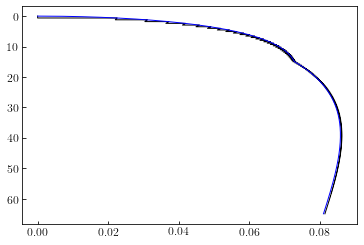

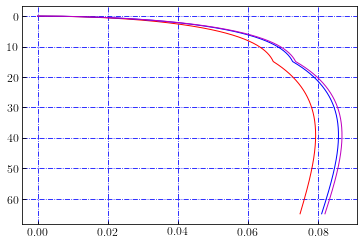

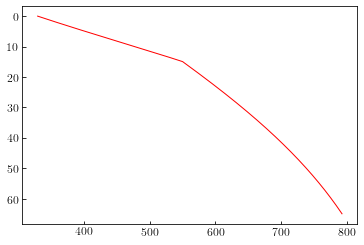

0.0 330.0 0.0
0.01 330.1396331437216 0.0
0.02 330.2792921270493 0.0
0.03 330.4189769266432 0.0
0.04 330.55868751914323 0.0
0.05 330.6984238811693 0.0
0.06 330.8381859893216 0.0
0.07 330.9779738201803 0.0
0.08 331.117787350306 0.0
0.09 331.25762655623913 0.0
0.1 331.3974914145004 0.0
0.11 331.5373819015907 0.0
0.12 331.67729799399126 0.0
0.13 331.8172396681632 0.0
0.14 331.9572069005482 0.0
0.15 332.0971996675678 0.0
0.16 332.23721794562414 0.0
0.17 332.3772617110993 0.0
0.18 332.51733094035586 0.0
0.19 332.65742560973666 0.0
0.2 332.79754569556445 0.0
0.21 332.937691174143 0.0
0.22 333.0778620217557 0.0
0.23 333.2180582146667 0.0
0.24 333.3582797291202 0.0
0.25 333.49852654134116 0.0
0.26 333.6387986275343 0.0
0.27 333.7790959638853 0.0
0.28 333.91941852656 0.0
0.29 334.05976629170453 0.0
0.3 334.20013923544565 0.0
0.31 334.3405373338903 0.0
0.32 334.48096056312636 0.0
0.33 334.6214088992215 0.0
0.34 334.76188231822425 0.0
0.35000000000000003 334.90238079616375 0.0
0.36 335.04290430904

2.05 359.1306919489469 0.03737583462655338
2.06 359.27510696285543 0.03736081095368312
2.07 359.41954263486 0.037345797207359886
2.08 359.5639989378385 0.03733079338102495
2.09 359.70847584465207 0.0373157994681239
2.1 359.85297332814497 0.03730081546210666
2.11 359.99749136114497 0.037285841356427485
2.12 360.14202991646295 0.03727087714454495
2.13 360.2865889668931 0.03725592281992199
2.14 360.4311684852132 0.03724097837602577
2.15 360.575768444184 0.03722604380632786
2.16 360.72038881654976 0.037211119104304115
2.17 360.8650295750384 0.03719620426343468
2.18 361.00969069236083 0.037181299277204025
2.19 361.15437214121164 0.037166404139100925
2.2 361.2990738942687 0.03715151884261846
2.21 361.44379592419347 0.03713664338125401
2.22 361.58853820363083 0.037121777748509235
2.23 361.73330070520916 0.03710692193789011
2.24 361.87808340154044 0.03709207594290687
2.25 362.02288626521994 0.03707723975707409
2.2600000000000002 362.16770926882685 0.03706241337391057
2.27 362.3125523849236 0.0

3.85 385.4315909823779 0.04489139188540253
3.86 385.57927231162626 0.044874197962125224
3.87 385.726969165662 0.049085236267693774
3.88 385.8746815146675 0.04906644650019172
3.89 386.02240932881205 0.049047669147597305
3.9 386.17015257825244 0.049028904201707614
3.91 386.31791123313184 0.049010151654325255
3.92 386.465685263581 0.04899141149725816
3.93 386.6134746397172 0.048972683722319735
3.94 386.7612793316453 0.04895396832132877
3.95 386.90909930945713 0.048935265286109454
3.96 387.0569345432314 0.0489165746084914
3.97 387.2047850030344 0.048897896280309605
3.98 387.3526506589193 0.048879230293404435
3.99 387.50053148092644 0.04886057663962172
4.0 387.6484274390836 0.0488419353108126
4.01 387.7963385034059 0.04882330629883362
4.0200000000000005 387.9442646438953 0.048804689595546756
4.03 388.0922058305412 0.048786085192819316
4.04 388.24016203332076 0.04876749308252396
4.05 388.388133222198 0.04874891325653877
4.0600000000000005 388.5361193671245 0.04873034570674715
4.07 388.684120

7.46 439.5136316596881 0.060277023923219056
7.47 439.66489563831044 0.06025628598723965
7.48 439.81616372403687 0.060235561753375445
7.49 439.9674358839924 0.060214851212573126
7.5 440.1187120852988 0.060194154355785304
7.51 440.2699922950745 0.06017347117397057
7.5200000000000005 440.421276480434 0.0601528016580935
7.53 440.5725646084887 0.06013214579912465
7.54 440.7238566463464 0.06011150358804052
7.55 440.8751525611113 0.06009087501582362
7.5600000000000005 441.0264523198848 0.06007026007346231
7.57 441.1777558897643 0.06004965875195105
7.58 441.3290632378443 0.060029071042290126
7.59 441.4803743312158 0.06000849693548585
7.6000000000000005 441.63168913696666 0.059987936422550424
7.61 441.78300762218134 0.059967389494502026
7.62 441.93432975394137 0.059946856142364745
7.63 442.0856554993248 0.05992633635716862
7.640000000000001 442.2369848254067 0.059905830129949586
7.65 442.3883176992589 0.05988533745174956
7.66 442.53965408795034 0.05986485831361628
7.67 442.6909939585466 0.05984

9.28 467.07872321651513 0.06481674946823618
9.290000000000001 467.23019096837936 0.06479573702615755
9.3 467.38165681404814 0.06477473846756777
9.31 467.53312072047413 0.06475375378329364
9.32 467.684582654612 0.064732782964168
9.33 467.8360425834177 0.06471182600102979
9.34 467.98750047384937 0.06469088288472395
9.35 468.13895629286657 0.06466995360610156
9.36 468.2904100074309 0.06464903815601965
9.370000000000001 468.44186158450583 0.06462813652534133
9.38 468.5933109910566 0.06460724870493573
9.39 468.74475819405 0.06458637468567809
9.4 468.8962031604555 0.06456551445844953
9.41 469.04764585724377 0.0645446680141374
9.42 469.19908625138794 0.06452383534363486
9.43 469.3505243098631 0.0645030164378412
9.44 469.50195999964615 0.06448221128766173
9.450000000000001 469.65339328771637 0.06446141988400769
9.46 469.8048241410546 0.06444064221779645
9.47 469.95625252664456 0.06441987827995127
9.48 470.1076784114715 0.06439912806140145
9.49 470.259101762523 0.06437839155308231
9.5 470.41052

11.09 494.4313306368697 0.06611170726697614
11.1 494.5819179132876 0.06609157797883178
11.11 494.732497357342 0.06607146199065252
11.120000000000001 494.8830689367561 0.06605135929365077
11.13 495.03363261926023 0.06603126987904467
11.14 495.1841883725913 0.0660111937380582
11.15 495.33473616449317 0.06599113086192109
11.16 495.48527596271674 0.06597108124186891
11.17 495.6358077350196 0.06595104486914302
11.18 495.7863314491666 0.0674197932256851
11.19 495.93684707292925 0.06739933148284181
11.200000000000001 496.0873545740861 0.0673788832596255
11.21 496.2378539204228 0.06735844854710335
11.22 496.3883450797321 0.06733802733634849
11.23 496.5388280198138 0.06731761961843992
11.24 496.6893027084747 0.06729722538446259
11.25 496.8397691135289 0.06727684462550726
11.26 496.99022720279754 0.06725647733267065
11.27 497.14067694410903 0.0672361234970553
11.28 497.2911183052989 0.0672157831097697
11.290000000000001 497.4415512542099 0.06719545616192814
11.3 497.5919757586923 0.0671751426446

12.88 521.2316586003276 0.0680439345268849
12.89 521.3803371957903 0.06802453088640695
12.9 521.5290023149777 0.06800514006643912
12.91 521.6776539272541 0.06798576205851053
12.92 521.8262920019959 0.06796639685415594
12.93 521.9749165085902 0.06794704444491563
12.94 522.1235274164361 0.06792770482233558
12.950000000000001 522.272124694944 0.06790837797796727
12.96 522.420708313536 0.06788906390336778
12.97 522.5692782416457 0.06786976259009982
12.98 522.7178344487188 0.06785047402973154
12.99 522.8663769042114 0.06903143835921942
13.0 523.0149055775927 0.06901183442852499
13.01 523.1634204383427 0.06899224345067782
13.02 523.3119214559533 0.06897266541711963
13.030000000000001 523.4604085999283 0.06895310031929777
13.040000000000001 523.6088818397831 0.06893354814866524
13.05 523.7573411450451 0.06891400889668067
13.06 523.9057864852531 0.06889448255480843
13.07 524.054217829958 0.0688749691145184
13.08 524.2026351487226 0.06885546856728618
13.09 524.3510384111214 0.06883598090459299


14.68 547.7479401366962 0.06907459155608034
14.69 547.8937114252391 0.0690562137356989
14.700000000000001 548.0394639302516 0.06903784805804043
14.71 548.1851976235343 0.06999883267462041
14.72 548.3309124769029 0.06998023100652719
14.73 548.4766084621895 0.06996164162905917
14.74 548.6222855512408 0.06994306453409568
14.75 548.7679437159197 0.0699244997135213
14.76 548.9135829281043 0.06990594715922605
14.77 549.0592031596886 0.06988740686310521
14.780000000000001 549.2048043825822 0.0698688788170595
14.790000000000001 549.3503865687098 0.06985036301299498
14.8 549.4959496900125 0.06983185944282302
14.81 549.6414937184467 0.06981336809846035
14.82 549.7870186259845 0.06979488897182906
14.83 549.9325243846134 0.0697764220548566
14.84 550.0326367740594 0.06976372192786073
14.85 550.0934982958164 0.06975600337402739
14.86 550.1543564558316 0.06974828695414352
14.870000000000001 550.2152112520571 0.06974057266761914
14.88 550.2760626824459 0.0697328605138644
14.89 550.336910744951 0.06972

18.3 570.876356496381 0.0739236444796341
18.31 570.9359360849589 0.07391593023352364
18.32 570.9955116337654 0.07390821812017162
18.330000000000002 571.0550831409339 0.07390050813898848
18.34 571.1146506045985 0.07389280028938472
18.35 571.1742140228943 0.07388509457077098
18.36 571.2337733939563 0.07387739098255813
18.37 571.2933287159204 0.0738696895241572
18.38 571.3528799869232 0.07386199019497934
18.39 571.4124272051014 0.0738542929944359
18.400000000000002 571.471970368593 0.0738465979219383
18.41 571.5315094755356 0.07459509347096947
18.42 571.591044524068 0.07458732389068543
18.43 571.6505755123296 0.07457955645845811
18.44 571.7101024384604 0.07457179117369363
18.45 571.7696253006003 0.07456402803579831
18.46 571.8291440968904 0.07455626704417861
18.47 571.8886588254725 0.07454850819824113
18.48 571.9481694844882 0.07454075149739267
18.490000000000002 572.0076760720804 0.07453299694104017
18.5 572.0671785863922 0.07452524452859073
18.51 572.1266770255676 0.0745174942594516
18.

21.92 592.1659758981746 0.077319761640837
21.93 592.2239756788786 0.07731218928746493
21.94 592.2819707823711 0.07730461902762224
21.95 592.3399612070009 0.07729705086073017
21.96 592.397946951118 0.07728948478621002
21.97 592.4559280130723 0.07788867206459185
21.98 592.5139043912145 0.07788105080360347
21.990000000000002 592.5718760838964 0.07787343164966595
22.0 592.6298430894698 0.07786581460219678
22.01 592.6878054062876 0.07785819966061358
22.02 592.7457630327027 0.07785058682433417
22.03 592.8037159670696 0.07784297609277643
22.04 592.8616642077426 0.0778353674653585
22.05 592.919607753077 0.07782776094149865
22.06 592.9775466014283 0.07782015652061533
22.07 593.0354807511534 0.07781255420212711
22.080000000000002 593.0934102006091 0.07780495398545272
22.09 593.1513349481534 0.07779735587001108
22.1 593.2092549921441 0.0777897598552213
22.11 593.2671703309406 0.07778216594050258
22.12 593.3250809629023 0.0777745741252743
22.13 593.3829868863895 0.07776698440895606
22.14 593.44088

23.740000000000002 602.6432937858349 0.07884200863889154
23.75 602.700415742376 0.07883453625348504
23.76 602.7575327316264 0.07882706593396975
23.77 602.8146447520506 0.07881959767977453
23.78 602.871751802114 0.07881213149032841
23.79 602.9288538802824 0.07880466736506053
23.8 602.9859509850227 0.0787972053034002
23.81 603.0430431148019 0.07878974530477692
23.82 603.1001302680882 0.07878228736862028
23.830000000000002 603.1572124433501 0.07877483149436007
23.84 603.2142896390569 0.07876737768142625
23.85 603.2713618536782 0.07875992592924896
23.86 603.3284290856847 0.07875247623725844
23.87 603.3854913335475 0.0787450286048851
23.88 603.4425485957386 0.07873758303155949
23.89 603.4996008707302 0.07926928772259326
23.900000000000002 603.5566481569956 0.07926179530616048
23.91 603.6136904530085 0.07925430496115692
23.92 603.6707277572433 0.07924681668700988
23.93 603.7277600681751 0.07923933048314682
23.94 603.7847873842796 0.07923184634899541
23.95 603.8418097040332 0.0792243642839834

25.54 612.8437828909551 0.0800863019036321
25.55 612.8999866241861 0.08007895788463083
25.560000000000002 612.9561851242925 0.08007161589603129
25.57 613.0123783898566 0.08006427593727221
25.580000000000002 613.0685664194623 0.08005693800779232
25.59 613.1247492116936 0.0800496021070306
25.6 613.180926765135 0.08004226823442623
25.61 613.2370990783722 0.08003493638941842
25.62 613.2932661499912 0.08002760657144663
25.63 613.3494279785785 0.08002027877995045
25.64 613.405584562722 0.08001295301436961
25.650000000000002 613.4617359010095 0.080005629274144
25.66 613.5178819920299 0.07999830755871366
25.67 613.5740228343724 0.07999098786751882
25.68 613.6301584266271 0.07998367019999984
25.69 613.6862887673849 0.07997635455559723
25.7 613.7424138552371 0.07996904093375164
25.71 613.798533688776 0.07996172933390389
25.72 613.854648266594 0.079954419755495
25.73 613.9107575872847 0.07994711219796606
25.740000000000002 613.9668616494423 0.07993980666075837
25.75 614.0229604516611 0.0799325031

29.12 632.6200103082873 0.08188308836391552
29.13 632.6742551005497 0.08187606779830486
29.14 632.7284941952628 0.08186904917367079
29.150000000000002 632.782727591251 0.08186203248947663
29.16 632.8369552873395 0.08185501774518597
29.17 632.8911772823543 0.08184800494026243
29.18 632.9453935751216 0.08184099407416986
29.19 632.9996041644687 0.08183398514637225
29.2 633.0538090492233 0.08182697815633368
29.21 633.1080082282145 0.08181997310351842
29.22 633.162201700271 0.08181296998739093
29.23 633.216389464223 0.08180596880741572
29.240000000000002 633.270571518901 0.08179896956305754
29.25 633.3247478631363 0.08179197225378124
29.26 633.3789184957607 0.08178497687905181
29.27 633.4330834156073 0.08177798343833441
29.28 633.4872426215089 0.08177099193109438
29.29 633.5413961122998 0.08176400235679714
29.3 633.5955438868149 0.08175701471490827
29.310000000000002 633.649685943889 0.08175002900489357
29.32 633.7038222823588 0.08174304522621889
29.330000000000002 633.7579529010605 0.08173

32.71 651.7192363855952 0.08294419213242953
32.72 651.7713654450613 0.08293755820686409
32.730000000000004 651.8234884289024 0.08293092611538079
32.74 651.8756053361878 0.08292429585747256
32.75 651.9277161659885 0.08291766743263249
32.76 651.9798209173754 0.08291104084035379
32.77 652.0319195894207 0.08290441608012979
32.78 652.0840121811967 0.08289779315145401
32.79 652.136098691777 0.08289117205382006
32.8 652.1881791202353 0.08288455278672172
32.81 652.2402534656464 0.0828779353496529
32.82 652.2923217270857 0.08287131974210764
32.83 652.3443839036288 0.08286470596358017
32.84 652.3964399943529 0.08285809401356477
32.85 652.4484899983352 0.08285148389155594
32.86 652.5005339146536 0.08284487559704828
32.87 652.5525717423869 0.08283826912953655
32.88 652.6046034806145 0.08283166448851566
32.89 652.6566291284166 0.0828250616734806
32.9 652.7086486848739 0.08281846068392655
32.910000000000004 652.7606621490679 0.08281186151934883
32.92 652.8126695200807 0.08280526417924289
32.93 652.8

34.54 661.1567731077764 0.08324137885332179
34.550000000000004 661.2077755215073 0.0832349580104325
34.56 661.2587717007118 0.08322853894271433
34.57 661.3097616445835 0.08322212164967656
34.58 661.3607453523173 0.0832157061308285
34.59 661.4117228231083 0.08320929238567967
34.6 661.4626940561526 0.08320288041373967
34.61 661.5136590506467 0.0831964702145183
34.62 661.5646178057881 0.0831900617875254
34.63 661.6155703207745 0.08318365513227105
34.64 661.6665165948048 0.08317725024826542
34.65 661.7174566270784 0.08317084713501875
34.660000000000004 661.768390416795 0.08316444579204155
34.67 661.8193179631556 0.08315804621884434
34.68 661.8702392653614 0.08315164841493787
34.69 661.9211543226144 0.08314525237983296
34.7 661.9720631341173 0.0831388581130406
34.71 662.0229656990736 0.08313246561407191
34.72 662.073862016687 0.08312607488243813
34.730000000000004 662.124752086163 0.08311968591765061
34.74 662.1756359067059 0.08311329871922095
34.75 662.2265134775226 0.08310691328666073
34.

38.160000000000004 679.2064275389188 0.08353451170496812
38.17 679.2551256246103 0.0835285228347252
38.18 679.3038172275012 0.08352253562022591
38.19 679.3525023470247 0.08351655006101248
38.2 679.4011809826151 0.0835105661566273
38.21 679.4498531337068 0.08350458390661283
38.22 679.4985187997356 0.08372344822014138
38.230000000000004 679.5471779801371 0.08371745317740883
38.24 679.5958306743479 0.08371145979212644
38.25 679.6444768818054 0.08370546806383591
38.26 679.6931166019474 0.08369947799207922
38.27 679.7417498342128 0.08369348957639831
38.28 679.7903765780403 0.08368750281633537
38.29 679.8389968328701 0.08368151771143267
38.300000000000004 679.8876105981425 0.08367553426123259
38.31 679.9362178732988 0.08366955246527766
38.32 679.9848186577807 0.08366357232311053
38.33 680.0334129510309 0.08365759383427396
38.34 680.0820007524919 0.08365161699831089
38.35 680.1305820616079 0.08364564181476433
38.36 680.1791568778231 0.08363966828317745
38.37 680.2277252005825 0.08363369640309

41.78 696.4075489802942 0.08366740380373867
41.79 696.4538682661504 0.08366183930827069
41.800000000000004 696.5001809055165 0.08365627635121942
41.81 696.5464868980532 0.08365071493215948
41.82 696.5927862434214 0.08364515505066568
41.83 696.6390789412826 0.08363959670631296
41.84 696.685364991299 0.08363403989867635
41.85 696.7316443931338 0.08362848462733094
41.86 696.77791714645 0.08362293089185203
41.87 696.8241832509118 0.08361737869181503
41.88 696.8704427061838 0.08361182802679537
41.89 696.9166955119315 0.08360627889636868
41.9 696.9629416678205 0.08377792403252009
41.910000000000004 697.0091811735172 0.08377236621506204
41.92 697.0554140286887 0.08376680993417439
41.93 697.1016402330029 0.08376125518943232
41.94 697.1478597861277 0.08375570198041118
41.95 697.1940726877323 0.08375015030668637
41.96 697.2402789374858 0.08374460016783343
41.97 697.2864785350588 0.08373905156342797
41.980000000000004 697.3326714801216 0.08373350449304581
41.99 697.3788577723456 0.083727958956262

45.4 712.7385988688143 0.08347326968040758
45.410000000000004 712.7824945896917 0.08346812909492121
45.42 712.826383579652 0.08346298993065313
45.43 712.8702658385658 0.08345785218721034
45.44 712.9141413663044 0.08345271586420008
45.45 712.9580101627394 0.08344758096122963
45.46 713.0018722277432 0.08344244747790637
45.47 713.0457275611885 0.08343731541383784
45.480000000000004 713.0895761629491 0.08343218476863161
45.49 713.1334180328985 0.08356474147629112
45.5 713.1772531709114 0.08355960520482518
45.51 713.2210815768627 0.08355447035338479
45.52 713.2649032506283 0.08354933692157734
45.53 713.308718192084 0.08354420490901038
45.54 713.352526401107 0.08353907431529149
45.550000000000004 713.396327877574 0.08353394514002845
45.56 713.4401226213631 0.08352881738282905
45.57 713.4839106323527 0.08352369104330128
45.58 713.5276919104216 0.08351856612105318
45.59 713.5714664554497 0.08351344261569288
45.6 713.6152342673163 0.08350832052682872
45.61 713.6589953459026 0.08350319985406901


49.0 728.1054826618429 0.08315520630497587
49.01 728.1469510582905 0.08315047056714614
49.02 728.1884127118444 0.08314573613860632
49.03 728.2298676225643 0.08314100301899449
49.04 728.2713157905102 0.0831362712079488
49.050000000000004 728.3127572157432 0.08313154070510742
49.06 728.3541918983246 0.0831268115101087
49.07 728.3956198383164 0.08312208362259105
49.08 728.4370410357807 0.083117357042193
49.09 728.4784554907803 0.08311263176855317
49.1 728.5198632033787 0.08310790780131029
49.11 728.5612641736399 0.08310318514010313
49.120000000000005 728.6026584016277 0.08309846378457068
49.13 728.6440458874074 0.0830937437343519
49.14 728.6854266310439 0.08308902498908596
49.15 728.7268006326035 0.08308430754841205
49.160000000000004 728.7681678921523 0.08307959141196947
49.17 728.8095284097569 0.08307487657939767
49.18 728.8508821854848 0.08307016305033617
49.19 728.8922292194035 0.0830654508244246
49.2 728.9335695115817 0.08306073990130261
49.21 728.9749030620877 0.08305603028061011
49

50.800000000000004 735.4612439462245 0.08281436771457293
50.81 735.5015000530434 0.08280983504668223
50.82 735.5417494355712 0.08280530363193872
50.83 735.5819920939541 0.08280077346999597
50.84 735.6222280283392 0.0827962445605076
50.85 735.6624572388739 0.08279171690312732
50.86 735.7026797257057 0.08278719049750902
50.870000000000005 735.742895488983 0.08278266534330658
50.88 735.7831045288543 0.08277814144017404
50.89 735.8233068454692 0.08286532815518584
50.9 735.8635024389771 0.08286080174364976
50.910000000000004 735.9036913095281 0.08285627658353117
50.92 735.9438734572726 0.08285175267448415
50.93 735.984048882362 0.08284723001616275
50.94 736.0242175849477 0.08284270860822118
50.95 736.0643795651814 0.08283818845031381
50.96 736.1045348232157 0.08283366954209499
50.97 736.1446833592034 0.08282915188321925
50.980000000000004 736.1848251732982 0.08282463547334115
50.99 736.2249602656536 0.0828201203121154
51.0 736.2650886364238 0.08281560639919679
51.01 736.3052102857637 0.0828

52.59 742.5601189645363 0.08253501719975219
52.6 742.5991741853443 0.08253067646866442
52.61 742.6382227153106 0.08252633693765908
52.620000000000005 742.677264554662 0.08252199860640437
52.63 742.7162997036259 0.08251766147456858
52.64 742.7553281624299 0.08251332554182014
52.65 742.7943499313023 0.0825089908078275
52.660000000000004 742.8333650104715 0.08250465727225928
52.67 742.872373400167 0.08250032493478408
52.68 742.9113751006176 0.08249599379507075
52.69 742.9503701120537 0.08249166385278808
52.7 742.9893584347055 0.08248733510760504
52.71 743.0283400688035 0.08248300755919069
52.72 743.0673150145792 0.08247868120721412
52.730000000000004 743.1062832722641 0.08247435605134457
52.74 743.1452448420902 0.08247003209125137
52.75 743.1841997242901 0.08246570932660387
52.76 743.2231479190967 0.0825398432984959
52.77 743.2620894267433 0.08253551881325083
52.78 743.3010242474636 0.08253119552359667
52.79 743.3399523814919 0.08252687342920288
52.800000000000004 743.3788738290629 0.0825

54.38 749.444642603092 0.0822138061084692
54.39 749.4825041776801 0.0822096529172542
54.4 749.5203591087773 0.08220550087427246
54.410000000000004 749.5582073966856 0.0822013499792065
54.42 749.5960490417067 0.08219720023173899
54.43 749.6338840441434 0.0821930516315526
54.44 749.6717124042987 0.08218890417833018
54.45 749.7095341224755 0.08218475787175461
54.46 749.7473491989774 0.08218061271150892
54.47 749.785157634109 0.08217646869727611
54.480000000000004 749.8229594281745 0.08217232582873941
54.49 749.8607545814788 0.08216818410558202
54.5 749.898543094327 0.08216404352748731
54.51 749.936324967025 0.08215990409413869
54.52 749.9741001998789 0.08215576580521967
54.53 750.0118687931949 0.08215162866041387
54.54 750.0496307472804 0.08214749265940495
54.550000000000004 750.0873860624421 0.0821433578018767
54.56 750.1251347389881 0.08213922408751297
54.57 750.1628767772264 0.08213509151599771
54.58 750.2006121774654 0.08213096008701497
54.59 750.238340940014 0.08212682980024885
54.6 

57.97 762.612602392763 0.08146870959788383
57.980000000000004 762.6481012926005 0.0814649174825465
57.99 762.6835936817173 0.08146112641561572
58.0 762.7190795605478 0.08145733639680164
58.01 762.7545589295272 0.0814535474258145
58.02 762.7900317890907 0.08144975950236456
58.03 762.8254981396735 0.08144597262616228
58.04 762.8609579817117 0.0814421867969181
58.050000000000004 762.8964113156419 0.08143840201434253
58.06 762.9318581419003 0.08143461827814623
58.07 762.9672984609239 0.0814308355880399
58.08 763.0027322731497 0.08142705394373434
58.09 763.0381595790158 0.0814232733449404
58.1 763.0735803789598 0.08141949379136904
58.11 763.1089946734199 0.08141571528273128
58.120000000000005 763.1444024628349 0.08141193781873822
58.13 763.1798037476437 0.08140816139910106
58.14 763.2151985282856 0.08140438602353106
58.15 763.2505868051999 0.0814006116917396
58.160000000000004 763.2859685788268 0.08139683840343806
58.17 763.3213438496067 0.08139306615833794
58.18 763.3567126179801 0.0813892

61.550000000000004 774.9086685309449 0.08063248159688322
61.56 774.941866809317 0.0806290273254281
61.57 774.9750587528304 0.08062557400897578
61.58 775.008244362029 0.08062212164726229
61.59 775.0414236374583 0.08061867024002362
61.6 775.0745965796627 0.08061521978699589
61.61 775.1077631891881 0.0806117702879153
61.620000000000005 775.1409234665799 0.08060832174251811
61.63 775.1740774123842 0.08060487415054064
61.64 775.2072250271468 0.08060142751171935
61.65 775.2403663114145 0.08059798182579066
61.660000000000004 775.273501265734 0.08059453709249115
61.67 775.3066298906523 0.08059109331155744
61.68 775.3397521867166 0.08058765048272622
61.690000000000005 775.3728681544745 0.08058420860573429
61.7 775.4059777944739 0.08058076768031848
61.71 775.4390811072627 0.0805773277062157
61.72 775.4721780933894 0.08057388868316295
61.730000000000004 775.5052687534029 0.08057045061089729
61.74 775.5383530878516 0.08056701348915588
61.75 775.5714310972854 0.08056357731767588
61.76 775.604502782

65.13 786.3931429955596 0.07973588955846174
65.14 786.424110175088 0.07973274978238562
65.15 786.455071231099 0.07972961087436375
65.16 786.4860261642257 0.07972647283415614
65.17 786.516974975101 0.07972333566152286
65.18 786.5479176643584 0.07972019935622406
65.19 786.5788542326314 0.07971706391801991
65.2 786.6097846805538 0.07971392934667074
65.21000000000001 786.6407090087597 0.07971079564193685
65.22 786.6716272178828 0.07970766280357869
65.23 786.7025393085581 0.07970453083135667
65.24 786.7334452814201 0.07970139972503136
65.25 786.7643451371034 0.07969826948436338
65.26 786.7952388762434 0.07969514010911338
65.27 786.8261264994749 0.07969201159904214
65.28 786.8570080074338 0.07968888395391042
65.29 786.887883400756 0.07968575717347907
65.3 786.9187526800769 0.07968263125750909
65.31 786.949615846033 0.07967950620576142
65.32000000000001 786.9804728992603 0.07967638201799719
65.33 787.0113238403958 0.0796732586939775
65.34 787.0421686700761 0.07967013623346354
65.35 787.073007

66.97 791.9886647232402 0.07925864568700962
66.98 792.0185160461645 0.07925565841413781
66.99 792.0483613655301 0.0792526719671577
67.0 792.0782006820078 0.0792496863458409
67.01 792.1080339962679 0.07924670154995916
67.02 792.1378613089809 0.07924371757928428
67.03 792.1676826208179 0.0792407344335881
67.04 792.1974979324501 0.07923775211264254
67.05 792.2273072445485 0.07923477061621963
67.06 792.2571105577848 0.07923178994409132
67.07000000000001 792.2869078728304 0.0792288100960298
67.08 792.3166991903574 0.0792258310718072
67.09 792.3464845110377 0.07922285287119576
67.1 792.3762638355437 0.07921987549396778
67.11 792.4060371645475 0.07921689893989563
67.12 792.435804498722 0.0792139232087517
67.13 792.4655658387397 0.07922240667444926
67.14 792.4953211852738 0.07921943215825862
67.15 792.5250705389974 0.07921645846443282
67.16 792.5548139005836 0.0792134855927445
67.17 792.5845512707064 0.07921051354296633
67.18 792.6142826500391 0.07920754231487111
67.19 792.6440080392557 0.0792

70.61 802.463387474963 0.0783070212243154
70.62 802.4910991905085 0.0783043171171925
70.63 802.5188051578193 0.07830161375767444
70.64 802.5465053776257 0.07829891114555446
70.65 802.5741998506569 0.07829620928062597
70.66 802.6018885776427 0.07829350816268238
70.67 802.6295715593134 0.07829080779151716
70.68 802.6572487963987 0.07828810816692384
70.69 802.6849202896286 0.07828540928869608
70.7 802.712586039734 0.07828271115662747
70.71000000000001 802.7402460474449 0.07828001377051173
70.72 802.7679003134921 0.07827731713014266
70.73 802.7955488386066 0.07827462123531402
70.74 802.8231916235188 0.07827192608581975
70.75 802.85082866896 0.07826923168145375
70.76 802.8784599756613 0.07826653802201004
70.77 802.906085544354 0.07826384510728265
70.78 802.9337053757697 0.0782611529370657
70.79 802.9613194706394 0.07825846151115338
70.8 802.9889278296955 0.07825577082933985
70.81 803.0165304536691 0.07825308089141945
70.82000000000001 803.044127343293 0.07825039169718646
70.83 803.071718499

72.43 807.4129673254763 0.0778288746371838
72.44 807.4396450074283 0.0778263031831103
72.45 807.466317076037 0.07782373243996703
72.46000000000001 807.4929835320547 0.07782116240755736
72.47 807.5196443762336 0.07781859308568487
72.48 807.5462996093263 0.07781602447415306
72.49 807.5729492320849 0.0778134565727656
72.5 807.5995932452623 0.07781088938132612
72.51 807.6262316496114 0.07780832289963834
72.52 807.652864445885 0.07780575712750602
72.53 807.6794916348359 0.07780319206473303
72.54 807.7061132172171 0.07780062771112325
72.55 807.7327291937822 0.07779806406648059
72.56 807.7593395652841 0.07779550113060904
72.57000000000001 807.7859443324767 0.07779293890331265
72.58 807.812543496113 0.07779037738439555
72.59 807.8391370569468 0.07778758159290347
72.60000000000001 807.8657250157321 0.07778502149789095
72.61 807.8923073732224 0.07778246211066821
72.62 807.9188841301719 0.07777990343103952
72.63 807.9454552873348 0.07777734545880928
72.64 807.972020845465 0.0777747881937819
72.65

74.25 812.1765961957722 0.07737238786337018
74.26 812.2022647440878 0.07736994261424644
74.27 812.2279278176853 0.07736749804116105
74.28 812.2535854173365 0.077365054143927
74.29 812.279237543811 0.07736237722605666
74.3 812.3048841978798 0.07735993468734334
74.31 812.3305253803143 0.07735749282391896
74.32000000000001 812.3561610918848 0.07735505163559683
74.33 812.3817913333625 0.07735261112219036
74.34 812.4074161055186 0.07735017128351288
74.35000000000001 812.4330354091243 0.07734773211937787
74.36 812.4586492449508 0.07734529362959884
74.37 812.4842576137697 0.07734285581398936
74.38 812.5098605163523 0.07734041867236302
74.39 812.5354579534702 0.07733798220453353
74.4 812.5610499258951 0.07733554641031455
74.41 812.5866364343984 0.07733311128951989
74.42 812.6122174797524 0.07733067684196335
74.43 812.637793062729 0.07732824306745878
74.44 812.6633631840998 0.07732580996582014
74.45 812.6889278446372 0.07732337753686137
74.46000000000001 812.7144870451133 0.07732094578039653
74

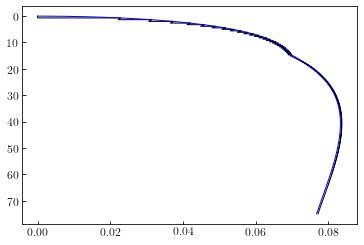

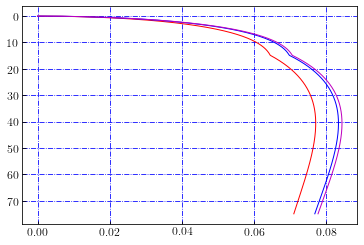

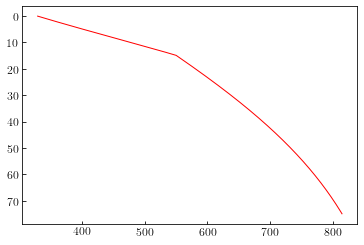

0.0 330.0 0.0
0.01 330.1373335994494 0.0
0.02 330.2746921948833 0.0
0.03 330.41207576409636 0.0
0.04 330.54948428486415 0.0
0.05 330.6869177349439 0.0
0.06 330.82437609207426 0.0
0.07 330.96185933397527 0.0
0.08 331.0993674383483 0.0
0.09 331.2369003828761 0.0
0.1 331.374458145223 0.0
0.11 331.51204070303464 0.0
0.12 331.64964803393826 0.0
0.13 331.7872801155426 0.0
0.14 331.92493692543775 0.0
0.15 332.0626184411951 0.0
0.16 332.2003246403681 0.0
0.17 332.33805550049124 0.0
0.18 332.4758109990807 0.0
0.19 332.61359111363424 0.0
0.2 332.75139582163115 0.0
0.21 332.8892251005323 0.0
0.22 333.02707892778 0.0
0.23 333.1649572807983 0.0
0.24 333.30286013699276 0.0
0.25 333.44078747375085 0.0
0.26 333.5787392684411 0.0
0.27 333.7167154984141 0.0
0.28 333.854716141002 0.0
0.29 333.99274117351865 0.022231990541014546
0.3 334.1307905732592 0.022222805176972043
0.31 334.2688643175012 0.022213625782042126
0.32 334.40696238350324 0.022204452352345784
0.33 334.545084748506 0.022195284884006492
0.34

3.72 382.61010842188233 0.07241635189122377
3.73 382.7550600966898 0.07238892737726062
3.74 382.90002733887206 0.07236152068512913
3.75 383.04501012030175 0.07233413180324783
3.7600000000000002 383.1900084128394 0.07230676072004265
3.77 383.3350221883326 0.07227940742394713
3.7800000000000002 383.4800514186165 0.07225207190340234
3.79 383.6250960755138 0.07222475414685679
3.8000000000000003 383.7701561308346 0.07219745414276658
3.81 383.91523155637657 0.07217017187959524
3.8200000000000003 384.06032232392477 0.07214290734581384
3.83 384.205428405252 0.07211566052990093
3.84 384.3505497721184 0.07208843142034252
3.85 384.49568639627194 0.07206122000563217
3.86 384.6408382494481 0.07203402627427084
3.87 384.7860053033699 0.07200685021476702
3.88 384.9311875297482 0.07197969181563664
3.89 385.0763849002814 0.07195255106540306
3.9 385.22159738665545 0.07192542795259724
3.91 385.3668249605445 0.07189832246575738
3.92 385.51206759360986 0.0718712345934293
3.93 385.65732525750104 0.0718441643

5.55 409.3667132544248 0.08256409271374666
5.5600000000000005 409.51403367282677 0.08253439073607699
5.57 409.6613643233317 0.08250470806024969
5.58 409.8087051758728 0.0824750446737215
5.59 409.9560562003749 0.08244540056395723
5.6000000000000005 410.1034173667544 0.08241577571842988
5.61 410.2507886449193 0.08238617012462056
5.62 410.39817000476893 0.08235658377001857
5.63 410.5455614161947 0.08420572511791521
5.64 410.6929628490792 0.08417550291870013
5.65 410.840374273297 0.08414530035939363
5.66 410.9877956587144 0.08411511742723268
5.67 411.1352269751892 0.0840849541094626
5.68 411.28266819257084 0.084054810393337
5.69 411.43011928070086 0.0840246862661177
5.7 411.57758020941253 0.08399458171507485
5.71 411.7250509485308 0.08396449672748685
5.72 411.87253146787236 0.08393443129064043
5.73 412.02002173724605 0.0839043853918305
5.74 412.16752172645243 0.08387435901836025
5.75 412.315031405284 0.08384435215754116
5.76 412.46255074352524 0.08381436479669288
5.7700000000000005 412.610

9.19 463.4228389987397 0.09659320718783118
9.200000000000001 463.57184792822824 0.09656215860180671
9.21 463.7208557862166 0.09653113019271868
9.22 463.8698625412331 0.09650012194745503
9.23 464.0188681618067 0.0964691338529123
9.24 464.16787261646715 0.09643816589599558
9.25 464.31687587374546 0.09640721806361836
9.26 464.46587790217364 0.09637629034270272
9.27 464.6148786702844 0.09634538272017924
9.28 464.76387814661183 0.09631449518298699
9.290000000000001 464.91287629969116 0.09743125072512611
9.3 465.06187309805847 0.0974000356433086
9.31 465.2108685102512 0.09736884084662481
9.32 465.35986250480784 0.09733766632189249
9.33 465.50885505026815 0.09730651205593786
9.34 465.6578461151732 0.09727537803559577
9.35 465.806835668065 0.09724426424770959
9.36 465.955823677487 0.09721317067913131
9.370000000000001 466.1048101119843 0.09718209731672127
9.38 466.2537949401028 0.0971510441473486
9.39 466.40277813038995 0.09712001115789083
9.4 466.5517596513947 0.09708899833523399
9.41 466.700

12.780000000000001 516.6094280576527 0.10349533664953106
12.790000000000001 516.7560548989272 0.10346597038636744
12.8 516.9026696299882 0.10343662320688196
12.81 517.0492722213611 0.10340729509867315
12.82 517.1958626435819 0.10337798604934753
12.83 517.3424408671967 0.10334869604651963
12.84 517.4890068627611 0.10331942507781215
12.85 517.6355606008415 0.1032901731308557
12.86 517.782102052014 0.10326094019328898
12.870000000000001 517.9286311868645 0.10323172625275878
12.88 518.0751479759898 0.10320253129691985
12.89 518.2216523899965 0.10317335531343493
12.9 518.368144399501 0.10314419828997488
12.91 518.5146239751305 0.10311506021421855
12.92 518.6610910875223 0.10308594107385269
12.93 518.8075457073239 0.10305684085657216
12.94 518.9539878051928 0.10377195018593212
12.950000000000001 519.1004173517975 0.10374267785420575
12.96 519.2468343178161 0.10371342454511623
12.97 519.3932386739377 0.1036841902463016
12.98 519.539630390861 0.10365497494540812
12.99 519.686009439296 0.103625

16.36 561.6515206106188 0.10713193861757016
16.37 561.7422336137106 0.10711463840530638
16.38 561.8329381033625 0.10709734540243687
16.39 561.9236340728954 0.10708005960595726
16.4 562.0143215156326 0.10706278101286444
16.41 562.1050004248999 0.1070455096201566
16.42 562.1956707940257 0.10754485100550788
16.43 562.2863326163417 0.1075275107082122
16.44 562.376985885182 0.1075101776370151
16.45 562.4676305938835 0.10749285178890527
16.46 562.5582667357861 0.10747553316087269
16.47 562.6488943042317 0.10745822174990866
16.48 562.739513292566 0.10744091755300554
16.490000000000002 562.8301236941364 0.10742362056715718
16.5 562.920725502294 0.10740633078935848
16.51 563.0113187103918 0.10738904821660573
16.52 563.1019033117864 0.10737177284589641
16.53 563.1924792998364 0.10735450467422926
16.54 563.2830466679035 0.10733724369860428
16.55 563.3736054093523 0.1073199899160227
16.56 563.4641555175497 0.10730274332348709
16.57 563.5546969858661 0.10728550391800107
16.580000000000002 563.64522

18.18 578.0145848156172 0.10932165660946444
18.19 578.1036411313625 0.10930481571230326
18.2 578.1926877646855 0.10928798183312916
18.21 578.2817247094314 0.10927115496901763
18.22 578.3707519594484 0.10925433511704531
18.23 578.4597695085876 0.10923752227429012
18.240000000000002 578.5487773507035 0.10966353674413983
18.25 578.6377754796533 0.10964666980250928
18.26 578.7267638892971 0.1096298098897192
18.27 578.8157425734986 0.10961295700284042
18.28 578.9047115261236 0.1095961111389452
18.29 578.993670741042 0.10957927229510679
18.3 579.082620212126 0.10956244046839984
18.31 579.1715599332509 0.10954561565590015
18.32 579.2604898982958 0.10952879785468467
18.330000000000002 579.3494101011414 0.10951198706183174
18.34 579.4383205356727 0.10949518327442077
18.35 579.5272211957775 0.10947838648953237
18.36 579.6161120753461 0.10946159670424853
18.37 579.7049931682723 0.1094448139156523
18.38 579.793864468453 0.10942803812082799
18.39 579.8827259697877 0.10941126931686118
18.40000000000

21.8 609.5742443444012 0.11224626782354204
21.81 609.6594180501422 0.11223058623099533
21.82 609.7445800525542 0.11221491117332696
21.830000000000002 609.8297303466529 0.11219924264781371
21.84 609.9148689274577 0.11218358065173349
21.85 609.9999957899913 0.11216792518236533
21.86 610.0851109292798 0.11215227623698941
21.87 610.1702143403528 0.11213663381288701
21.88 610.2553060182432 0.11212099790734055
21.89 610.3403859579872 0.11210536851763366
21.900000000000002 610.4254541546247 0.11241580131083402
21.91 610.5105106031986 0.11240013951851922
21.92 610.5955552987558 0.11238448425283148
21.93 610.6805882363461 0.11236883551105112
21.94 610.765609411023 0.11235319329045944
21.95 610.850618817843 0.11233755758833894
21.96 610.9356164518667 0.11232192840197316
21.97 611.0206023081574 0.11230630572864693
21.98 611.1055763817824 0.11229068956564604
21.990000000000002 611.1905386678119 0.11227507991025752
22.0 611.2754891613199 0.1122594767597695
22.01 611.3604278573838 0.1122438801114712

23.61 624.7953416794278 0.11311407212087492
23.62 624.8783192276502 0.11309905171116436
23.63 624.9612842264719 0.11308403756080214
23.64 625.0442366715343 0.11306902966717983
23.650000000000002 625.1271765584826 0.11305402802769013
23.66 625.2101038829652 0.1130390326397268
23.67 625.2930186406343 0.11302404350068468
23.68 625.3759208271456 0.11300906060795966
23.69 625.4588104381579 0.11299408395894883
23.7 625.5416874693341 0.11297911355105024
23.71 625.62455191634 0.11296414938166312
23.72 625.7074037748454 0.11294919144818767
23.73 625.7902430405233 0.11321340119856751
23.740000000000002 625.8730697090502 0.11319841878550692
23.75 625.9558837761062 0.11318344261596062
23.76 626.0386852373753 0.11316847268732673
23.77 626.1214740885439 0.1131535089970046
23.78 626.2042503253033 0.11313855154239451
23.79 626.2870139433471 0.11312360032089792
23.8 626.3697649383731 0.1131086553299174
23.81 626.4525033060825 0.11309371656685652
23.82 626.5352290421798 0.11307878402911992
23.8300000000

27.19 653.6686759051049 0.11378907157338218
27.2 653.7469089399485 0.11377545458448407
27.21 653.8251280901624 0.1137618432700967
27.22 653.9033333526496 0.11374823762785542
27.23 653.9815247243172 0.11373463765539651
27.240000000000002 654.0597022020752 0.11372104335035726
27.25 654.1378657828376 0.1137074547103759
27.26 654.2160154635216 0.11369387173309169
27.27 654.2941512410482 0.11388553845022667
27.28 654.3722731123415 0.11387194228831311
27.29 654.4503810743297 0.11385835179223122
27.3 654.528475123944 0.11384476695961997
27.310000000000002 654.6065552581193 0.11383118778811922
27.32 654.6846214737938 0.1138176142753699
27.330000000000002 654.7626737679097 0.11380404641901384
27.34 654.8407121374122 0.11379048421669392
27.35 654.9187365792502 0.11377692766605399
27.36 654.9967470903764 0.1137633767647388
27.37 655.0747436677465 0.11374983151039418
27.38 655.1527263083198 0.11373629190066695
27.39 655.2306950090596 0.11372275793320478
27.400000000000002 655.308649766932 0.113709

28.990000000000002 667.5241288303027 0.11387425764885219
29.0 667.5998160867148 0.1138613474743289
29.01 667.6754889573394 0.11384844267977065
29.02 667.7511474397061 0.11383554326293552
29.03 667.8267915313479 0.11382264922158247
29.04 667.9024212298012 0.11380976055347143
29.05 667.9780365326061 0.11379687725636325
29.060000000000002 668.0536374373057 0.11378399932801969
29.07 668.129223941447 0.11377112676620345
29.080000000000002 668.2047960425799 0.11375825956867823
29.09 668.2803537382582 0.11374539773320858
29.1 668.3558970260391 0.11373254125755998
29.11 668.4314259034829 0.11371969013949891
29.12 668.5069403681538 0.1137068443767927
29.13 668.5824404176188 0.11386747614551308
29.14 668.6579260494491 0.11385462150333073
29.150000000000002 668.7333972612187 0.11384177221797184
29.16 668.8088540505053 0.11382892828720412
29.17 668.88429641489 0.11381608970879618
29.18 668.9597243519573 0.11380325648051756
29.19 669.0351378592954 0.11379042860013874
29.2 669.1105369344956 0.113777

32.57 693.6844227471677 0.11323369008892349
32.58 693.7548276726147 0.11322219869572402
32.59 693.825217542615 0.11333574622985002
32.6 693.8955923558842 0.11332425173115955
32.61 693.9659521111424 0.11331276202248959
32.62 694.0362968071116 0.11330127710184414
32.63 694.1066264425181 0.11328979696722778
32.64 694.1769410160904 0.11327832161664615
32.65 694.2472405265602 0.11326685104810569
32.660000000000004 694.3175249726634 0.11325538525961348
32.67 694.3877943531378 0.11324392424917766
32.68 694.4580486667252 0.11323246801480706
32.69 694.5282879121703 0.11322101655451139
32.7 694.5985120882207 0.11320956986630122
32.71 694.6687211936272 0.11319812794818791
32.72 694.7389152271445 0.1131866907981836
32.730000000000004 694.8090941875296 0.11329847995400036
32.74 694.8792580735428 0.11328703989223336
32.75 694.9494068839477 0.11327560459780184
32.76 695.0195406175113 0.11326417406871905
32.77 695.0896592730033 0.11325274830299925
32.78 695.1597628491967 0.11324132729865745
32.79 695.

36.21 718.3091519375871 0.11222607488323298
36.22 718.3740163495786 0.1122159416125526
36.230000000000004 718.4388654395318 0.11220581256463791
36.24 718.5036992072437 0.1121956877377292
36.25 718.5685176525142 0.1121855671300675
36.26 718.6333207751461 0.11217545073989453
36.27 718.6981085749449 0.11216533856545277
36.28 718.7628810517188 0.11215523060498542
36.29 718.8276382052786 0.11214512685673646
36.300000000000004 718.8923800354384 0.1121350273189505
36.31 718.9571065420141 0.11212493198987303
36.32 719.0218177248255 0.11211484086775009
36.33 719.0865135836945 0.11210475395082858
36.34 719.1511941184455 0.11217947758192685
36.35 719.215859328906 0.1121693914451529
36.36 719.2805092149067 0.11215930951150282
36.37 719.34514377628 0.11214923177922516
36.38 719.4097630128616 0.11213915824656913
36.39 719.4743669244903 0.11212908891178457
36.4 719.5389555110071 0.11211902377312213
36.410000000000004 719.603528772256 0.11210896282883323
36.42 719.6680867080831 0.11209890607717005
36.

39.83 740.7891977246635 0.11074417664751808
39.84 740.8485230262205 0.11073530853012148
39.85 740.9078331023937 0.11072644410827229
39.86 740.967127953894 0.11071758338043046
39.87 741.0264075814338 0.11070872634505662
39.88 741.0856719857283 0.11069987300061203
39.89 741.1449211674947 0.1106910233455586
39.9 741.2041551274524 0.1106821773783589
39.910000000000004 741.2633738663237 0.11067333509747608
39.92 741.3225773848325 0.11066449650137399
39.93 741.381765683705 0.1106556615885171
39.94 741.4409387636701 0.11064683035737051
39.95 741.5000966254587 0.11063800280639996
39.96 741.5592392698039 0.11068451591281493
39.97 741.6183666974414 0.11067569130571363
39.980000000000004 741.6774789091088 0.11066687037602795
39.99 741.736575905546 0.11065805312222547


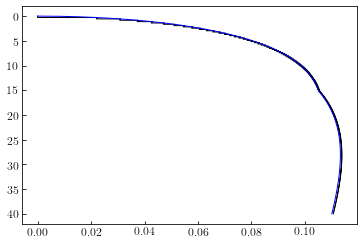

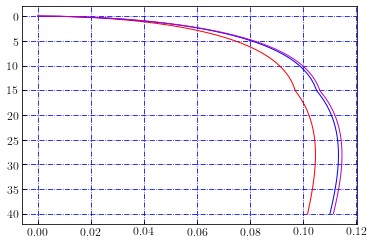

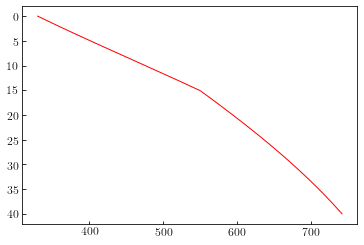

0.0 330.0 0.0
0.01 330.1405014112948 0.0
0.02 330.2810289843699 0.0
0.03 330.4215826954471 0.0
0.04 330.5621625207272 0.0
0.05 330.7027684363913 0.0
0.06 330.84340041859963 0.0
0.07 330.9840584434921 0.0
0.08 331.12474248718866 0.0
0.09 331.2654525257883 0.0
0.1 331.4061885353702 0.0
0.11 331.54695049199285 0.0
0.12 331.68773837169465 0.0
0.13 331.8285521504938 0.0
0.14 331.96939180438784 0.0
0.15 332.1102573093544 0.0
0.16 332.25114864135077 0.0
0.17 332.39206577631376 0.0
0.18 332.5330086901603 0.0
0.19 332.67397735878683 0.0
0.2 332.8149717580699 0.0
0.21 332.9559918638655 0.0
0.22 333.0970376520097 0.0
0.23 333.2381090983183 0.0
0.24 333.37920617858697 0.0
0.25 333.52032886859115 0.0
0.26 333.6614771440864 0.0
0.27 333.802650980808 0.0
0.28 333.9438503544711 0.0
0.29 334.0850752407707 0.0
0.3 334.2263256153822 0.0
0.31 334.36760145396033 0.0
0.32 334.50890273214003 0.0
0.33 334.6502294255363 0.0
0.34 334.79158150974405 0.0
0.35000000000000003 334.9329589603382 0.0
0.36 335.07436175

1.97 358.15280799676435 0.043991530744128274
1.98 358.2979794455328 0.043973706713243285
1.99 358.4431719955142 0.04395589453237711
2.0 358.5883856191932 0.04393809419365148
2.0100000000000002 358.73362028903745 0.043920305689193334
2.02 358.8788759774971 0.043902529011134846
2.0300000000000002 359.02415265700535 0.043884764151613416
2.04 359.1694502999776 0.04386701110277172
2.05 359.3147688788126 0.04384926985675757
2.06 359.4601083658916 0.043831540405724075
2.07 359.60546873357856 0.04381382274182953
2.08 359.7508499542204 0.04379611685723744
2.09 359.89625200014694 0.04377842274411654
2.1 360.0416748436709 0.04376074039464073
2.11 360.18711845708754 0.048890727120841235
2.12 360.3325828126753 0.048870990193196955
2.13 360.4780678826956 0.048851266387329985
2.14 360.6235736393924 0.04883155569451656
2.15 360.7691000549932 0.04881185810603864
2.16 360.91464710170806 0.048792173613184026
2.17 361.06021475173003 0.04877250220724632
2.18 361.20580297723535 0.048752843879524894
2.19 361

5.59 411.8567503959672 0.0710625928427156
5.6000000000000005 412.00764148865363 0.07103656732473144
5.61 412.15854275736103 0.07101055910939226
5.62 412.30945416974373 0.07098456818519465
5.63 412.4603756934473 0.07095859454064289
5.64 412.6113072961085 0.07093263816424887
5.65 412.7622489453552 0.07090669904453216
5.66 412.9132006088068 0.0708807771700199
5.67 413.06416225407366 0.07085487252924694
5.68 413.2151338487576 0.07082898511075567
5.69 413.3661153604517 0.07080311490309615
5.7 413.5171067567406 0.07077726189482603
5.71 413.6681080051999 0.0707514260745106
5.72 413.8191190733971 0.07072560743072268
5.73 413.97013992889066 0.07069980595204277
5.74 414.12117053923106 0.07067402162705891
5.75 414.2722108719597 0.07064825444436675
5.76 414.4232608946099 0.0706225043925695
5.7700000000000005 414.5743205747064 0.07059677146027797
5.78 414.7253898797654 0.07057105563611055
5.79 414.87646877729486 0.07054535690869317
5.8 415.0275572347944 0.07051967526665931
5.8100000000000005 415.17

9.23 467.1906382491465 0.08236044554904043
9.24 467.3430463509186 0.08233358647995778
9.25 467.49545249778714 0.08230674526769308
9.26 467.64785665608593 0.08227992190037449
9.27 467.8002587921506 0.08225311636613808
9.28 467.9526588723183 0.08222632865312786
9.290000000000001 468.1050568629282 0.08219955874949565
9.3 468.2574527303216 0.08217280664340115
9.31 468.409846440841 0.08214607232301199
9.32 468.5622379608315 0.08211935577650362
9.33 468.71462725663974 0.08209265699205934
9.34 468.8670142946143 0.08206597595787035
9.35 469.0193990411059 0.0820393126621357
9.36 469.17178146246744 0.08201266709306221
9.370000000000001 469.32416152505334 0.08198603923886465
9.38 469.47653919522077 0.08195942908776553
9.39 469.6289144393286 0.08193283662799526
9.4 469.78128722373793 0.08190626184779203
9.41 469.9336575148119 0.08187970473540189
9.42 470.0860252789162 0.08185316527907864
9.43 470.2383904824186 0.08182664346708396
9.44 470.39075309168885 0.08326684092900638
9.450000000000001 470.54

12.82 521.5246907750488 0.08751849433983346
12.83 521.67426699981 0.0874934007386953
12.84 521.8238295188766 0.08746832382063227
12.85 521.9733783010613 0.08744326357455288
12.86 522.1229133151886 0.08741821998937303
12.870000000000001 522.2724345300948 0.087393193054016
12.88 522.421941914628 0.08736818275741241
12.89 522.5714354376483 0.08734318908850022
12.9 522.7209150680275 0.08731821203622485
12.91 522.8703807746494 0.08729325158953895
12.92 523.0198325264098 0.0872683077374026
12.93 523.1692702922167 0.08724338046878315
12.94 523.3186940409895 0.08817868261986461
12.950000000000001 523.4681037416603 0.08815351441862826
12.96 523.617499363173 0.08812836295006367
12.97 523.7668808744834 0.08810322820304643
12.98 523.9162482445595 0.08807811016645949
12.99 524.0656014423815 0.08805300882919316
13.0 524.2149404369419 0.08802792418014518
13.01 524.3642651972452 0.08800285620822064
13.02 524.5135756923078 0.08797780490233209
13.030000000000001 524.6628718911589 0.08795277025139929
13.

16.41 562.8771893139387 0.09189598688371442
16.42 562.9539373545048 0.09188345861725918
16.43 563.0306792217074 0.09187093477364007
16.44 563.1074149115083 0.09185841535129574
16.45 563.1841444198702 0.09184590034866534
16.46 563.2608677427579 0.09183338976418856
16.47 563.3375848761369 0.09182088359630569
16.48 563.4142958159749 0.0918083818434575
16.490000000000002 563.49100055824 0.09179588450408545
16.5 563.5676990989027 0.09178339157663136
16.51 563.6443914339344 0.09177090305953775
16.52 563.721077559308 0.09175841895124764
16.53 563.797757470998 0.09174593925020456
16.54 563.8744311649803 0.09173346395485264
16.55 563.9510986372318 0.09172099306363656
16.56 564.0277598837313 0.09170852657500152
16.57 564.1044149004589 0.09169606448739331
16.580000000000002 564.1810636833964 0.09168360679925819
16.59 564.2577062285262 0.09167115350904306
16.6 564.3343425318332 0.09165870461519532
16.61 564.4109725893027 0.09164626011616295
16.62 564.4875963969226 0.09163382001039436
16.63 564.564

20.04 590.3002375515551 0.09569952158927658
20.05 590.37449105266 0.09568748511981565
20.06 590.4487370132173 0.0956754528995725
20.07 590.5229754297483 0.09566342492704699
20.080000000000002 590.5972062987756 0.09565140120073956
20.09 590.6714296168235 0.0956393817191512
20.1 590.7456453804182 0.09562736648078336
20.11 590.8198535860869 0.09561535548413813
20.12 590.8940542303592 0.095603348727718
20.13 590.9682473097662 0.09559134621002602
20.14 591.0424328208398 0.09557934792956592
20.150000000000002 591.116610760115 0.09556735388484171
20.16 591.1907811241273 0.09606742289012893
20.17 591.2649439094142 0.09605537308448722
20.18 591.3390991125149 0.09604332753277132
20.19 591.4132467299705 0.09603128623347942
20.2 591.4873867583233 0.09601924918511036
20.21 591.5615191941173 0.09600721638616343
20.22 591.6356440338984 0.09599518783513845
20.23 591.7097612742142 0.09598316353053578
20.240000000000002 591.7838709116137 0.09597114347085631
20.25 591.8579729426475 0.0959591276546015
20.

23.66 616.661201901887 0.09825983787978614
23.67 616.7325116355876 0.09824847658012952
23.68 616.8038126803788 0.0982371192913364
23.69 616.8751050334046 0.09822576601199086
23.7 616.9463886918111 0.09821441674067741
23.71 617.0176636527459 0.0982030714759811
23.72 617.0889299133582 0.09819173021648757
23.73 617.1601874707999 0.09818039296078275
23.740000000000002 617.2314363222235 0.09816905970745322
23.75 617.302676464784 0.09855081904194597
23.76 617.3739078956378 0.09853944843531295
23.77 617.4451306119437 0.09852808184282903
23.78 617.5163446108614 0.09851671926307716
23.79 617.5875498895531 0.09850536069464072
23.8 617.6587464451826 0.09849400613610355
23.81 617.7299342749152 0.09848265558605011
23.82 617.8011133759182 0.09847130904306527
23.830000000000002 617.8722837453607 0.09845996650573442
23.84 617.9434453804137 0.09844862797264343
23.85 618.0145982782497 0.0984372934423787
23.86 618.0857424360431 0.09842596291352712
23.87 618.1568778509702 0.09841463638467607
23.88 618.228

25.46 629.3543214246864 0.09920996611713818
25.47 629.4240228567481 0.09919897976062485
25.48 629.4937151147111 0.09918799728260935
25.490000000000002 629.5633981960427 0.0991770186817225
25.5 629.6330720982126 0.09916604395659553
25.51 629.7027368186914 0.09915507310586026
25.52 629.7723923549528 0.09914410612814885
25.53 629.8420387044713 0.09913314302209401
25.54 629.9116758647235 0.099122183786329
25.55 629.9813038331881 0.09911122841948744
25.560000000000002 630.0509226073453 0.09910027692020351
25.57 630.1205321846772 0.09908932928711184
25.580000000000002 630.1901325626677 0.09907838551884754
25.59 630.2597237388026 0.09906744561404625
25.6 630.3293057105691 0.09905650957134404
25.61 630.3988784754569 0.09938817346614294
25.62 630.468442030957 0.09937720734276538
25.63 630.5379963745623 0.09936624509074282
25.64 630.6075415037677 0.09935528670870854
25.650000000000002 630.6770774160697 0.09934433219529637
25.66 630.7466041089668 0.0993333815491405
25.67 630.8161215799591 0.09932

27.25 641.6824199388959 0.09986344893192732
27.26 641.7504405692061 0.09985286417138509
27.27 641.8184516010416 0.09984228314756584
27.28 641.8864530321949 0.09983170585915045
27.29 641.9544448604611 0.09982113230482019
27.3 642.0224270836363 0.09981056248325683
27.310000000000002 642.0903996995191 0.09979999639314258
27.32 642.1583627059094 0.09978943403316015
27.330000000000002 642.2263161006096 0.09977887540199266
27.34 642.2942598814227 0.09976832049832383
27.35 642.3621940461551 0.09975776932083763
27.36 642.4301185926139 0.09974722186821866
27.37 642.4980335186083 0.09973667813915192
27.38 642.5659388219492 0.09972613813232294
27.39 642.6338345004499 0.09971560184641759
27.400000000000002 642.7017205519246 0.09970506928012235
27.41 642.7695969741902 0.09969454043212403
27.42 642.8374637650649 0.09968401530111001
27.43 642.9053209223688 0.09997250730919195
27.44 642.9731684439239 0.09996195805585219
27.45 643.041006327554 0.0999514125267004
27.46 643.1088345710847 0.09994087072042

30.830000000000002 665.404919790863 0.10045245232769937
30.84 665.4693768894347 0.10044272254320993
30.85 665.5338237151922 0.10043299619361254
30.86 665.5982602665748 0.10042327327769453
30.87 665.6626865420234 0.10041355379424376
30.88 665.7271025399809 0.10040383774204843
30.89 665.7915082588918 0.10039412511989725
30.900000000000002 665.8559036972024 0.10038441592657928
30.91 665.9202888533606 0.10037471016088409
30.92 665.9846637258166 0.10036500782160158
30.93 666.049028313022 0.10035530890752216
30.94 666.1133826134297 0.10034561341743665
30.95 666.1777266254957 0.10033592135013623
30.96 666.2420603476766 0.10032623270441257
30.970000000000002 666.306383778431 0.10054454903837293
30.98 666.3706969162197 0.10053484522716674
30.990000000000002 666.4349997595049 0.10052514484168329
31.0 666.4992923067506 0.10051544788071315
31.01 666.5635745564226 0.10050575434304743
31.02 666.6278465069889 0.10049606422747753
31.03 666.6921081569186 0.1004863775327954
31.04 666.7563595046829 0.100

32.63 676.84028546814 0.10045949432506694
32.64 676.902870005623 0.10045020612248028
32.65 676.9654440177677 0.10044092119889461
32.660000000000004 677.0280075033295 0.10043163955315233
32.67 677.0905604610653 0.10042236118409632
32.68 677.1531028897341 0.10041308609056974
32.69 677.215634788096 0.10040381427141633
32.7 677.2781561549137 0.10059344949980291
32.71 677.3406669889508 0.10058416586937384
32.72 677.4031672889732 0.10057488551633165
32.730000000000004 677.4656570537483 0.10056560843951935
32.74 677.5281362820451 0.10055633463778028
32.75 677.5906049726344 0.10054706410995835
32.76 677.6530631242892 0.10053779685489767
32.77 677.7155107357835 0.10052853287144294
32.78 677.7779478058933 0.10051927215843913
32.79 677.8403743333967 0.1005100147147317
32.8 677.9027903170727 0.10050076053916653
32.81 677.9651957557031 0.10049150963058981
32.82 678.0275906480705 0.10048226198784824
32.83 678.0899749929598 0.10047301760978887
32.84 678.1523487891571 0.1004637764952592
32.85 678.2147

36.27 698.9169954566722 0.10018997887216097
36.28 698.9756800933328 0.10032934566250104
36.29 699.034353863171 0.10032092447275136
36.300000000000004 699.0930167655486 0.10031250625592236
36.31 699.1516687998286 0.10030409101096453
36.32 699.2103099653757 0.1002956787368287
36.33 699.2689402615566 0.10028726943246603
36.34 699.3275596877389 0.10027886309682822
36.35 699.3861682432923 0.10027045972886713
36.36 699.4447659275879 0.10026205932753511
36.37 699.5033527399984 0.10025366189178488
36.38 699.5619286798982 0.10024526742056945
36.39 699.6204937466628 0.10023687591284235
36.4 699.6790479396701 0.10022848736755728
36.410000000000004 699.737591258299 0.10022010178366848
36.42 699.79612370193 0.10021171916013047
36.43 699.8546452699455 0.10020333949589816
36.44 699.9131559617296 0.1001949627899268
36.45 699.9716557766669 0.10018658904117213
36.46 700.0301447141453 0.10017821824859006
36.47 700.0886227735526 0.10016985041113707
36.480000000000004 700.1470899542793 0.10030684000892331


39.9 719.5015963329164 0.0995810752537838
39.910000000000004 719.5563066090191 0.09957350377109135
39.92 719.6110058873006 0.09956593496134875
39.93 719.6656941676688 0.09955836882361228
39.94 719.7203714500317 0.09955080535693868
39.95 719.7750377342994 0.0996495897605098
39.96 719.8296930203833 0.09964202355854661
39.97 719.8843373081955 0.09963446002766901
39.980000000000004 719.938970597651 0.09962689916693396
39.99 719.9935928886646 0.09961934097539889
40.0 720.0482041811537 0.09961178545212143
40.01 720.1028044750366 0.09960423259615962
40.02 720.1573937702329 0.09959668240657185
40.03 720.2119720666637 0.09958913488241683
40.04 720.2665393642518 0.09958159002275355
40.050000000000004 720.3210956629208 0.0995740478266414
40.06 720.3756409625962 0.09956650829314004
40.07 720.4301752632049 0.09955897142130948
40.08 720.4846985646749 0.09955143721021013
40.09 720.539210866936 0.0995439056589026
40.1 720.5937121699185 0.09953637676644801
40.11 720.6482024735554 0.09952885053190762
40

43.52 738.5883420726649 0.09861748431579766
43.53 738.6390757147816 0.09868521209559108
43.54 738.6897984130495 0.09867843580025387
43.550000000000004 738.7405101678485 0.0986716618971426
43.56 738.7912109795594 0.09866489038541276
43.57 738.8419008485649 0.09865812126422006
43.58 738.8925797752481 0.09865135453272066
43.59 738.9432477599936 0.09864459019007088
43.6 738.9939048031875 0.09863782823542737
43.61 739.0445509052167 0.09863106866794713
43.62 739.0951860664693 0.09862431148678744
43.63 739.1458102873348 0.0986175566911058
43.64 739.196423568204 0.09861080428006012
43.65 739.2470259094683 0.09860405425280855
43.660000000000004 739.2976173115212 0.0985973066085095
43.67 739.3481977747566 0.09859056134632177
43.68 739.3987672995698 0.09858381846540439
43.69 739.4493258863578 0.0985770779649167
43.7 739.499873535518 0.09857033984401833
43.71 739.5504102474495 0.09856360410186922
43.72 739.6009360225524 0.0986299939385393
43.730000000000004 739.6514508612282 0.09862325795738683
43

47.15 756.2894369842098 0.09746847083297085
47.160000000000004 756.3362320283278 0.09746244039148252
47.17 756.3830163405909 0.09745641207891245
47.18 756.4297899217754 0.09745038589450901
47.19 756.4765527726586 0.09744436183752087
47.2 756.5233048940179 0.09743833990719708
47.21 756.5700462866328 0.09748122474663737
47.22 756.6167769512828 0.09747520404690921
47.230000000000004 756.6634968887489 0.09746918547266016
47.24 756.7102060998135 0.09746316902313981
47.25 756.7569045852589 0.09745715469759812
47.26 756.8035923458693 0.09745114249528525
47.27 756.8502693824295 0.09744513241545164
47.28 756.8969356957252 0.09743912445734798
47.29 756.9435912865433 0.09743311862022526
47.300000000000004 756.9902361556715 0.09742711490333471
47.31 757.0368703038986 0.09742111330592781
47.32 757.0834937320143 0.09741511382725634
47.33 757.1301064408093 0.09740911646657231
47.34 757.1767084310752 0.09740312122312803
47.35 757.2232997036047 0.09739712809617604
47.36 757.2698802591913 0.097391137084

50.730000000000004 772.3627818171111 0.09617481232124146
50.74 772.4057914875444 0.0961694570442258
50.75 772.4487907621243 0.09616410365777597
50.76 772.4917796419398 0.0961587521612246
50.77 772.5347581280813 0.09615340255390446
50.78 772.5777262216394 0.09614805483514863
50.79 772.6206839237058 0.09614270900429034
50.800000000000004 772.6636312353725 0.09613736506066317
50.81 772.7065681577329 0.09616119418049833
50.82 772.7494946918811 0.0961558523888646
50.83 772.7924108389111 0.09615051248303604
50.84 772.8353165999187 0.09614517446234683
50.85 772.8782119759999 0.09613983832613152
50.86 772.9210969682517 0.09613450407372479
50.870000000000005 772.9639715777719 0.09612917170446161
50.88 773.0068358056585 0.09612384121767725
50.89 773.0496896530113 0.09611851261270703
50.9 773.0925331209298 0.09611318588888669
50.910000000000004 773.1353662105151 0.0961078610455521
50.92 773.1781889228683 0.09610253808203942
50.93 773.2210012590921 0.09609721699768498
50.94 773.2638032202892 0.096

54.31 787.1046678615227 0.09478463512847303
54.32 787.1440308700274 0.0947798951974663
54.33 787.1833839174557 0.0947751569397907
54.34 787.2227270051359 0.09478489605883178
54.35 787.262060134397 0.09478016042281238
54.36 787.3013833065685 0.09477542645860786
54.370000000000005 787.3406965229807 0.09477069416562797
54.38 787.379999784964 0.0947659635432828
54.39 787.4192930938497 0.09476123459098251
54.4 787.4585764509698 0.09475650730813755
54.410000000000004 787.4978498576562 0.09475178169415858
54.42 787.5371133152424 0.09474705774845638
54.43 787.5763668250617 0.09474233547044204
54.44 787.6156103884479 0.09473761485952684
54.45 787.654844006736 0.09473289591512217
54.46 787.6940676812609 0.09472817863663979
54.47 787.7332814133586 0.09472346302349152
54.480000000000004 787.7724852043652 0.09471874907508948
54.49 787.8116790556178 0.09471403679084596
54.5 787.8508629684535 0.09470932617017347
54.51 787.8900369442107 0.09470461721248472
54.52 787.9292009842276 0.09471357157443097
5

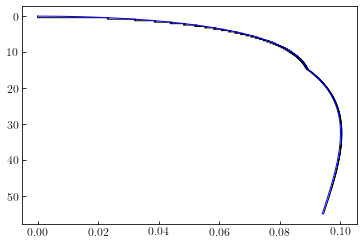

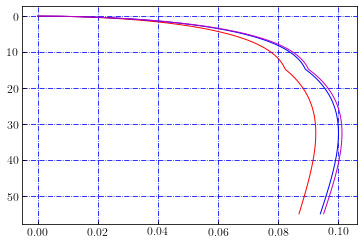

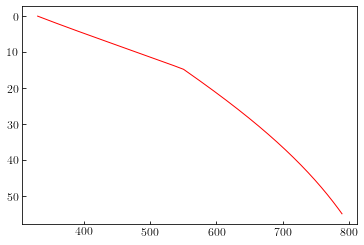

0.0 330.0 0.0
0.01 330.14195572788 0.0
0.02 330.2839381616367 0.0
0.03 330.42594727674566 0.0
0.04 330.56798304866066 0.0
0.05 330.71004545281465 0.0
0.06 330.85213446461887 0.0
0.07 330.99425005946387 0.0
0.08 331.1363922127185 0.0
0.09 331.2785608997306 0.0
0.1 331.420756095827 0.0
0.11 331.5629777763132 0.0
0.12 331.7052259164734 0.0
0.13 331.8475004915708 0.0
0.14 331.9898014768475 0.0
0.15 332.1321288475246 0.0
0.16 332.27448257880155 0.0
0.17 332.41686264585746 0.0
0.18 332.5592690238499 0.0
0.19 332.7017016879154 0.0
0.2 332.8441606131694 0.0
0.21 332.98664577470674 0.0
0.22 333.1291571476007 0.0
0.23 333.2716947069038 0.0
0.24 333.41425842764744 0.0
0.25 333.55684828484226 0.0
0.26 333.69946425347786 0.0
0.27 333.8421063085226 0.0
0.28 333.9847744249243 0.0
0.29 334.12746857760976 0.0
0.3 334.2701887414845 0.0
0.31 334.41293489143374 0.0
0.32 334.5557070023216 0.0
0.33 334.69850504899074 0.0
0.34 334.841329006264 0.0
0.35000000000000003 334.9841788489427 0.0
0.36 335.1270545518

3.7600000000000002 385.02607872316474 0.06630304443592377
3.77 385.17617290446475 0.06627720768414012
3.7800000000000002 385.32628321531655 0.0662513882872258
3.79 385.47640962442705 0.06622558623352338
3.8000000000000003 385.62655210048973 0.06619980151138316
3.81 385.77671061218376 0.06617403410916332
3.8200000000000003 385.92688512817455 0.06614828401522985
3.83 386.0770756171132 0.06612255121795661
3.84 386.2272820476378 0.06609683570572514
3.85 386.3775043883717 0.06607113746692488
3.86 386.5277426079246 0.0660454564899531
3.87 386.6779966748929 0.06601979276321476
3.88 386.82826655785874 0.06599414627512269
3.89 386.97855222539056 0.06596851701409745
3.9 387.1288536460432 0.06594290496856745
3.91 387.27917078835765 0.06591731012696878
3.92 387.4295036208614 0.06906175969234563
3.93 387.5798521120682 0.06903496951913811
3.94 387.7302162304781 0.06900819734122503
3.95 387.88059594457764 0.06898144314651872
3.96 388.0309912228397 0.06895470692293966
3.97 388.1814020337237 0.06892798

7.390000000000001 440.31401259153034 0.08497159579563965
7.4 440.46781412470386 0.08494192561023566
7.41 440.62161972235526 0.08491227535466632
7.42 440.77542934992243 0.08488264501554456
7.43 440.92924297284 0.08485303457949218
7.44 441.0830605565387 0.08482344403314009
7.45 441.2368820664458 0.08479387336312813
7.46 441.39070746798507 0.08476432255610507
7.47 441.5445367265767 0.08473479159872874
7.48 441.69836980763756 0.08470528047766582
7.49 441.85220667658064 0.0846757891795921
7.5 442.00604729881604 0.08464631769119219
7.51 442.15989163975036 0.08461686599915963
7.5200000000000005 442.31373966478645 0.08458743409019705
7.53 442.4675913393243 0.08455802195101586
7.54 442.6214466287606 0.08452862956833644
7.55 442.7753054984885 0.0844992569288881
7.5600000000000005 442.9291679138979 0.08446990401940911
7.57 443.0830338403759 0.08444057082664658
7.58 443.2369032433061 0.08441125733735652
7.59 443.390776088069 0.08438196353830389
7.6000000000000005 443.5446523400421 0.08613182417095

9.22 468.49253974215355 0.0893037156175532
9.23 468.64650727683306 0.08927437607758468
9.24 468.80047252205554 0.08924505624535216
9.25 468.95443544311536 0.08921575610761767
9.26 469.1083960053085 0.08918647565115222
9.27 469.26235417393343 0.0891572148627356
9.28 469.4163099142906 0.09055806338800483
9.290000000000001 469.5702631916827 0.09052837302695406
9.3 469.72421397141466 0.09049870260929019
9.31 469.87816221879365 0.09046905212161699
9.32 470.03210789912924 0.09043942155054722
9.33 470.1860509777329 0.09040981088270271
9.34 470.339991419919 0.09038022010471415
9.35 470.493929191004 0.0903506492032213
9.36 470.6478642563068 0.09032109816487287
9.370000000000001 470.8017965811488 0.09029156697632652
9.38 470.9557261308537 0.0902620556242489
9.39 471.10965287074777 0.09023256409531563
9.4 471.26357676616 0.09020309237621124
9.41 471.41749778242183 0.0901736404536292
9.42 471.5714158848672 0.09014420831427197
9.43 471.72533103883285 0.09011479594485088
9.44 471.87924320965783 0.09

12.82 523.5082343019405 0.09534440577323945
12.83 523.6591722576062 0.09531692398650873
12.84 523.8100958006406 0.09528946065963796
12.85 523.9610048990421 0.09526201578022735
12.86 524.1118995208212 0.09523458933588556
12.870000000000001 524.2627796340018 0.09612896272288904
12.88 524.4136452066193 0.09610130792950433
12.89 524.564496206723 0.09607367171219022
12.9 524.7153326023744 0.09604605405846893
12.91 524.8661543616473 0.09601845495587116
12.92 525.0169614526294 0.09599087439193581
12.93 525.1677538434207 0.09596331235421021
12.94 525.3185315021335 0.09593576883025014
12.950000000000001 525.4692943968939 0.09590824380761963
12.96 525.6200424958404 0.09588073727389113
12.97 525.7707757671246 0.09585324921664534
12.98 525.9214941789108 0.0958257796234715
12.99 526.0721976993768 0.09579832848196694
13.0 526.2228862967128 0.09577089577973753
13.01 526.3735599391223 0.09574348150439738
13.02 526.5242185948223 0.09571608564356882
13.030000000000001 526.674862232042 0.0956887081848826

16.41 565.2825833710947 0.10009020281510321
16.42 565.365989381431 0.10007543693840149
16.43 565.4493879134357 0.10006067674109861
16.44 565.5327789619444 0.10004592222101005
16.45 565.6161625217939 0.10003117337595227
16.46 565.6995385878239 0.10001643020374237
16.47 565.7829071548753 0.10000169270219854
16.48 565.8662682177917 0.09998696086913954
16.490000000000002 565.9496217714184 0.09997223470238517
16.5 566.0329678106028 0.09995751419975599
16.51 566.1163063301943 0.09994279935907342
16.52 566.1996373250446 0.09992809017815966
16.53 566.2829607900072 0.09991338665483782
16.54 566.3662767199372 0.0998986887869319
16.55 566.449585109693 0.0998839965722665
16.56 566.5328859541338 0.09986931000866732
16.57 566.6161792481216 0.09985462909396074
16.580000000000002 566.6994649865197 0.0998399538259741
16.59 566.7827431641944 0.10045958647056337
16.6 566.8660137760136 0.10044482931274262
16.61 566.9492768168468 0.10043007783096719
16.62 567.0325322815662 0.10041533202305389
16.63 567.115

20.04 595.0282832969541 0.10377627659028038
20.05 595.108652152015 0.10376226170324776
20.06 595.1890117956173 0.10374825220676077
20.07 595.2693622233986 0.10373424809874614
20.080000000000002 595.3497034309997 0.10372024937713124
20.09 595.4300354140631 0.10370625603984433
20.1 595.5103581682343 0.10417172516044924
20.11 595.5906716891607 0.10415767793233387
20.12 595.6709759724923 0.1041436361072035
20.13 595.7512710138811 0.10412959968298004
20.14 595.831556808982 0.10411556865758613
20.150000000000002 595.9118333534522 0.10410154302894517
20.16 595.9921006429506 0.10408752279498144
20.17 596.0723586731393 0.10407350795361998
20.18 596.1526074396824 0.10405949850278666
20.19 596.2328469382464 0.10404549444040806
20.2 596.3130771645 0.1040314957644117
20.21 596.3932981141147 0.10401750247272575
20.22 596.4735097827639 0.10400351456327928
20.23 596.5537121661238 0.10398953203400209
20.240000000000002 596.6339052598727 0.10397555488282482
20.25 596.714089059691 0.10396158310767893
20.

23.66 623.4874163602085 0.10638366359122006
23.67 623.5641846175164 0.10637056648163391
23.68 623.6409422433919 0.10635747440958876
23.69 623.7176892343649 0.10634438737314693
23.7 623.794425586967 0.10633130537037168
23.71 623.871151297733 0.10631822839932684
23.72 623.9478663632002 0.1063051564580771
23.73 624.0245707799082 0.10629208954468782
23.740000000000002 624.1012645443993 0.10627902765722509
23.75 624.1779476532181 0.10626597079375591
23.76 624.254620102912 0.1062529189523478
23.77 624.3312818900308 0.10623987213106917
23.78 624.407933011127 0.1062268303279891
23.79 624.4845734627554 0.10621379354117748
23.8 624.5612032414735 0.10620076176870483
23.81 624.6378223438413 0.10618773500864256
23.82 624.7144307664213 0.10617471325906273
23.830000000000002 624.7910285057785 0.10616169651803814
23.84 624.8676155584807 0.10614868478364235
23.85 624.9441919210979 0.1064915562972485
23.86 625.0207575902027 0.10647851097489258
23.87 625.0973125623706 0.10646547067015867
23.88 625.173856

27.25 650.3392302038815 0.10748128849508824
27.26 650.4119782700417 0.10746926679784455
27.27 650.484714622993 0.107457249724506
27.28 650.557439260183 0.10744523727329414
27.29 650.6301521790617 0.10743322944243108
27.3 650.7028533770821 0.10742122623013975
27.310000000000002 650.7755428516995 0.10740922763464365
27.32 650.8482206003714 0.1073972336541671
27.330000000000002 650.9208866205585 0.107385244286935
27.34 650.9935409097235 0.10737325953117294
27.35 651.0661834653322 0.10736127938510719
27.36 651.1388142848523 0.1073493038469648
27.37 651.2114333657546 0.10733733291497335
27.38 651.2840407055123 0.1073253665873612
27.39 651.3566363016013 0.10731340486235735
27.400000000000002 651.4292201514993 0.10730144773819156
27.41 651.5017922526877 0.10728949521309414
27.42 651.5743526026496 0.10727754728529618
27.43 651.6469011988709 0.10726560395302945
27.44 651.7194380388403 0.10725366521452628
27.45 651.7919631200486 0.10750770634456756
27.46 651.8644764399894 0.10749574720123638
27.

30.830000000000002 675.6168844222286 0.10757064163547761
30.84 675.6852952979654 0.10755975046787482
30.85 675.7536937083854 0.10754886348934153
30.86 675.8220796518353 0.1075379806982666
30.87 675.8904531266644 0.10752710209303933
30.88 675.9588141312241 0.10751622767204976
30.89 676.0271626638688 0.10750535743368844
30.900000000000002 676.0954987229546 0.10769317705816339
30.91 676.1638223068403 0.10768229510385896
30.92 676.2321334138878 0.10767141733508033
30.93 676.3004320424604 0.10766054375021769
30.94 676.3687181909248 0.1076496743476617
30.95 676.4369918576492 0.10763880912580386
30.96 676.5052530410054 0.10762794808303597
30.970000000000002 676.5735017393665 0.10761709121775073
30.98 676.6417379511084 0.10760623852834139
30.990000000000002 676.7099616746102 0.10759539001320167
31.0 676.7781729082521 0.10758454567072613
31.01 676.8463716504181 0.10757370549930977
31.02 676.9145578994935 0.10756286949734829
31.03 676.9827316538668 0.10755203766323801
31.04 677.0508929119286 0.1

34.45 699.555858637694 0.10724337330232887
34.46 699.6196678692663 0.10723359210612195
34.47 699.6834641928209 0.10722381467205637
34.480000000000004 699.7472476075552 0.10721404099868502
34.49 699.8110181126683 0.10720427108456142
34.5 699.8747757073616 0.1071945049282397
34.51 699.9385203908388 0.10718474252827444
34.52 700.0022521623059 0.10717498388322083
34.53 700.0659710209706 0.1071652289916347
34.54 700.1296769660438 0.10715547785207226
34.550000000000004 700.1933699967376 0.10714573046309046
34.56 700.2570501122674 0.10713598682324661
34.57 700.3207173118495 0.10712624693109879
34.58 700.3843715947039 0.10711651078520541
34.59 700.4480129600518 0.10710677838412563
34.6 700.5116414071166 0.10709704972641909
34.61 700.5752569351248 0.10722972289583477
34.62 700.6388595433044 0.10721998879393953
34.63 700.7024492308858 0.1072102584360717
34.64 700.7660259971016 0.10720053182079119
34.65 700.8295898411865 0.10719080894665851
34.660000000000004 700.8931407623777 0.10718108981223472

38.07 721.806617151819 0.10632828409756014
38.08 721.865718216147 0.10631957871842967
38.09 721.9248062219574 0.106310876687649
38.1 721.9838811692066 0.10630217800393026
38.11 722.042943057853 0.10629348266598601
38.12 722.101991887857 0.10628479067252943
38.13 722.1610276591813 0.10627610202227405
38.14 722.2200503717899 0.10626741671393404
38.15 722.279060025649 0.10625873474622398
38.160000000000004 722.3380566207268 0.10625005611785898
38.17 722.3970401569937 0.1062413808275546
38.18 722.4560106344217 0.10623270887402694
38.19 722.5149680529846 0.10632417408218904
38.2 722.5739124126588 0.1063155006298937
38.21 722.632843713422 0.10630683051366814
38.22 722.6917619552538 0.1062981637322292
38.230000000000004 722.7506671381365 0.10628950028429421
38.24 722.8095592620535 0.106280840168581
38.25 722.8684383269908 0.10627218338380788
38.26 722.9273043329356 0.10626352992869374
38.27 722.9861572798781 0.10625487980195779
38.28 723.0449971678091 0.1062462330023199
38.29 723.103823996722

39.89 732.347965979023 0.10571439850107332
39.9 732.4046915671521 0.10570621079897675
39.910000000000004 732.4614041201354 0.10569802624611584
39.92 732.5181036382702 0.1056898448412793
39.93 732.5747901218556 0.10568166658325634
39.94 732.6314635711926 0.10575652408525821
39.95 732.6881239865841 0.10574834569613349
39.96 732.7447713683341 0.10574017045266242
39.97 732.8014057167495 0.10573199835363505
39.980000000000004 732.8580270321384 0.1057238293978419
39.99 732.9146353148102 0.10571566358407407
40.0 732.9712305650767 0.10570750091112302
40.01 733.0278127832514 0.10569934137778068
40.02 733.0843819696498 0.10569118498283946
40.03 733.1409381245888 0.10568303172509223
40.04 733.1974812483871 0.10567488160333235
40.050000000000004 733.2540113413653 0.10566673461635363
40.06 733.3105284038458 0.10565859076295034
40.07 733.3670324361527 0.10565045004191717
40.08 733.4235234386122 0.10564231245204934
40.09 733.4800014115517 0.10563417799214253
40.1 733.5364663553006 0.10562604666099286

43.51 752.0344464315647 0.10436676858817373
43.52 752.0864861391575 0.10435954705684744
43.53 752.1385130292084 0.1043523283031386
43.54 752.1905271026042 0.10434511232597882
43.550000000000004 752.2425283602323 0.10439202134871578
43.56 752.2945168029826 0.1043848071812531
43.57 752.3464924317454 0.1043775957885755
43.58 752.3984552474133 0.10437038716961572
43.59 752.4504052508798 0.10436318132330687
43.6 752.5023424430401 0.10435597824858255
43.61 752.5542668247911 0.10434877794437666
43.62 752.6061783970306 0.10434158040962363
43.63 752.6580771606581 0.10433438564325823
43.64 752.7099631165748 0.10432719364421564
43.65 752.7618362656829 0.1043200044114315
43.660000000000004 752.8136966088862 0.10431281794384181
43.67 752.8655441470905 0.10430563424038294
43.68 752.9173788812019 0.10429845329999185
43.69 752.9692008121293 0.10429127512160564
43.7 753.0210099407822 0.10428409970416201
43.71 753.0728062680713 0.10432968325393902
43.72 753.1245897949095 0.10432250972777081
43.730000000

45.32 761.2457590436996 0.10363223805328929
45.33 761.2954945947455 0.10362546774333437
45.34 761.3452175115696 0.10361870003744361
45.35 761.3949277953075 0.1036119349346154
45.36 761.4446254470957 0.10360517243384856
45.37 761.4943104680729 0.10359841253414222
45.38 761.543982859378 0.10359165523449596
45.39 761.593642622152 0.1035849005339097
45.4 761.6432897575366 0.10361988920407855
45.410000000000004 761.6929242666755 0.10361313697864252
45.42 761.7425461507129 0.10360638735031485
45.43 761.7921554107947 0.10359964031809654
45.44 761.8417520480681 0.10359289588098912
45.45 761.8913360636816 0.10358615403799434
45.46 761.9409074587847 0.10357941478811451
45.47 761.9904662345286 0.1035726781303522
45.480000000000004 762.0400123920654 0.10356594406371042
45.49 762.0895459325487 0.10355921258719253
45.5 762.1390668571332 0.10355248369980231
45.51 762.1885751669752 0.10354575740054392
45.52 762.238070863232 0.10353903368842184
45.53 762.2875539470622 0.103532312562441
45.54 762.337024

47.14 770.090708976074 0.10284572557591556
47.15 770.1381650387037 0.10283938820242118
47.160000000000004 770.1856086941589 0.10283305326647066
47.17 770.2330399437957 0.10282672076712636
47.18 770.2804587889703 0.10282039070345118
47.19 770.3278652310413 0.10281406307450823
47.2 770.3752592713674 0.10280773787936107
47.21 770.4226409113088 0.10280141511707357
47.22 770.4700101522267 0.10279509478671
47.230000000000004 770.5173669954839 0.10282021310195175
47.24 770.5647114424435 0.10281389570115038
47.25 770.6120434944705 0.1028075807302107
47.26 770.6593631529306 0.10280126818819815
47.27 770.7066704191905 0.10279495807417853
47.28 770.7539652946185 0.10278865038721789
47.29 770.8012477805835 0.10278234512638276
47.300000000000004 770.8485178784558 0.10277604229074
47.31 770.8957755896072 0.1027697418793567
47.32 770.9430209154095 0.10276344389130053
47.33 770.9902538572369 0.10275714832563933
47.34 771.0374744164635 0.10275085518144146
47.35 771.0846825944657 0.10274456445777547
47.

48.94 778.4342628337314 0.10204041888184746
48.95 778.4795084841471 0.10203448823746868
48.96 778.5247419887097 0.10202855987419349
48.97 778.5699633489633 0.10202263379114454
48.980000000000004 778.6151725664531 0.10201670998744475
48.99 778.660369642725 0.1020107884622175
49.0 778.7055545793264 0.10200486921458632
49.01 778.7507273778051 0.10199895224367525
49.02 778.7958880397102 0.10199303754860854
49.03 778.8410365665917 0.10198712512851087
49.04 778.8861729600003 0.10200348140087377
49.050000000000004 778.9312972214881 0.10199757223817378
49.06 778.9764093526079 0.1019916653483149
49.07 779.0215093549136 0.10198576073042291
49.08 779.0665972299598 0.101979858383624
49.09 779.1116729793024 0.10197395830704459
49.1 779.156736604498 0.1019680604998115
49.11 779.2017881071041 0.10196216496105187
49.120000000000005 779.2468274886795 0.1019562716898932
49.13 779.2918547507836 0.10195038068546326
49.14 779.3368698949771 0.10194449194689024
49.15 779.3818729228212 0.10193860547330261
49.

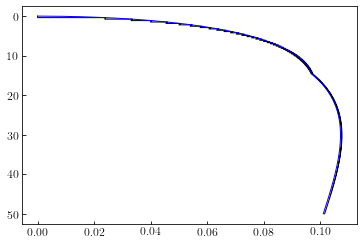

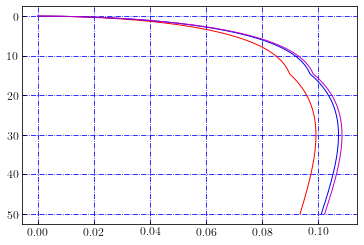

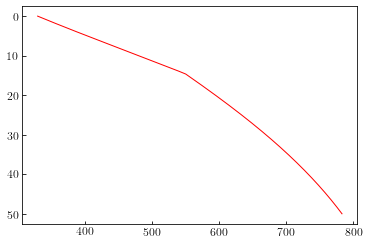

In [30]:
sigma_18O = []

for i in range(len(T0)):
    sigma_18O.append(sigma_inst.experiment2(P = 1, temp = T0[i], accum = Accum0[i], rho_o = 330.0, \
                        fo = 1, f1 = 1, dz = 0.01, z_final = zs[i], fileout = False))

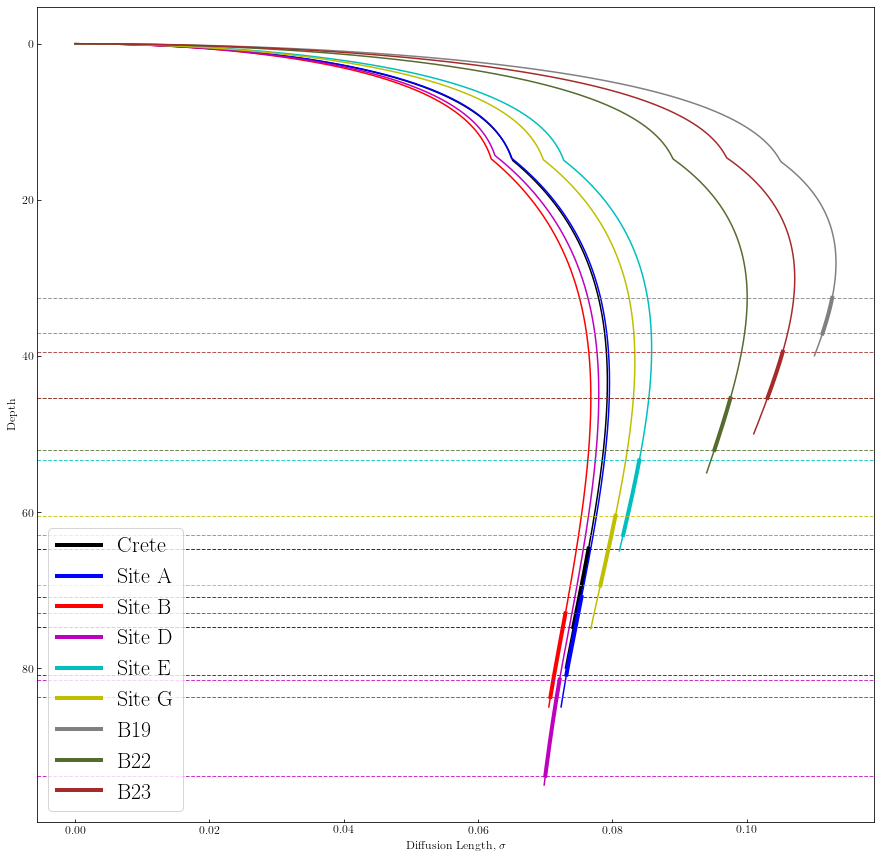

In [36]:
depths = []
depths_LT = []
sigma_LT = []

colors = ['k','b','r','m','c','y','gray', 'darkolivegreen', 'brown']
figDiffLens, axDiffLens = plt.subplots(figsize=(15,15))
for i in range(len(sigma_18O)):
    depths.append(np.arange(0,int(len(sigma_18O[i])*0.01),0.01))
    sigma_LT.append(sigma_18O[i][(depths[i] >= TambDepth[i]) & (depths[i] <= LakiDepth[i])]) 
    depths_LT.append(depths[i][(depths[i] >= TambDepth[i]) & (depths[i] <= LakiDepth[i])])
    
    axDiffLens.axhline(y = TambDepth[i], alpha=0.8, color=colors[i], ls='--', lw=1)
    axDiffLens.axhline(y = LakiDepth[i], alpha=0.8, color=colors[i], ls='--', lw=1)
    axDiffLens.plot(sigma_LT[i], depths_LT[i], label=coreNames[i], color=colors[i], lw=4)
    axDiffLens.plot(sigma_18O[i], depths[i], label=coreNames[i], color=colors[i])
axDiffLens.legend()
axDiffLens.set(xlabel='Diffusion Length, $\sigma$', ylabel='Depth')
plt.gca().invert_yaxis()

In [45]:
sigma_maxs = []
sigma_mins = []

for i in range(len(depths_LT)):
    sigma_maxs.append(max(sigma_LT[i]))
    sigma_mins.append(min(sigma_LT[i]))

In [46]:
sigma_maxs

[0.07647320522992593,
 0.07542018083096282,
 0.0730251883299818,
 0.07215903400187486,
 0.0840286812484305,
 0.08047856730788001,
 0.11275453127730335,
 0.09759582797686535,
 0.10539522109785524]

In [47]:
sigma_mins

[0.07420159383464801,
 0.07318047765033527,
 0.07079314823632839,
 0.0700349248758044,
 0.08162470450618413,
 0.07823311448379731,
 0.11131379189684477,
 0.0952147815586007,
 0.10312400469656192]